<a href="https://colab.research.google.com/github/cabicho/ds_in_deploy/blob/modulo07_machine_learning_modelling_01/m04_v01_h6_store_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalations

In [197]:
!pip install sklearn
!pip install inflection==0.5.1
#!pip install import-ipynb==0.1.4
!pip install boruta

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [198]:
!pip freeze | grep sklearn #sklearn-pandas==2.2.0
#!pip freeze | gre

sklearn-pandas==2.2.0


In [199]:
!pip freeze | grep inflec #inflect==7.0.0 inflection==0.5.1
!pip freeze | grep import-ipynb
!pip freeze | grep import-ipynb

inflect==7.0.0
inflection==0.5.1


# 0.0 IMPORTS

In [200]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [201]:
import pandas as pd
#!pip install inflection
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use('seaborn-white')
import datetime
#import import-ipynb #import-ipynb

from IPython.core.display   import HTML
from IPython.display        import Image
#%matplotlib inline
from boruta                 import BorutaPy

from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder #trocando letras por números
from sklearn.ensemble       import RandomForestRegressor

from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.linear_model   import LinearRegression, Lasso


# 0.1 Helper Functions

In [202]:
#import-ipynb


## 0.1 Helper Functions

In [203]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize']=[25,12]
    plt.rcParams['font.size']=24

    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING
def mean_absolute_percentage_error(y, yhat):
  return np.mean(np.abs((y-yhat)/y))

def ml_error(model_name, y, yhat):
  mae= mean_absolute_error(y, yhat)
  mape= mean_absolute_percentage_error(y, yhat)
  rmse= np.sqrt(mean_squared_error(y, yhat))

  return pd.DataFrame({'Model Name' : model_name,
                       'MAE'        : mae,
                       'MAPE'       : mape,
                       'RMSE'       : rmse },
                      index=[0])


In [204]:
jupyter_settings()

In [205]:
!ls

drive  sample_data


# 0.2 Loading Data

In [206]:
!ls ../Rossmann-Store-Sales-Prediction/dataset/store.csv

ls: cannot access '../Rossmann-Store-Sales-Prediction/dataset/store.csv': No such file or directory


In [207]:
!ls data_set/data

ls: cannot access 'data_set/data': No such file or directory


In [208]:
#df_train_raw=pd.read_csv("../ds/data_set/data/train.csv", low_memory=False)
#df_train_raw=pd.read_csv("/dataset/data/train.csv", low_memory=False)
df_train_raw=pd.read_csv("/content/drive/MyDrive/dataset/train.csv", low_memory=False)

#df_store_raw=pd.read_csv("../ds/data_set/data/store.csv", low_memory=False)
df_store_raw=pd.read_csv("/content/drive/MyDrive/dataset/store.csv", low_memory=False)


# print("read_csv("data_set/stores.csv)")
# pd.read_csv("Rossmann-Store-Sales-Prediction/dataset/train.csv", low_memory=False)
#df_sales_raw=pd.read_csv("Rossmann-Store-Sales-Prediction/dataset/train.csv", low_memory=False)

#pd.read_csv("Rossmann-Store-Sales-Prediction/dataset/store.csv", low_memory=False)
#pd.read_csv("../dataset/stores.csv", low_memory=False)


#df_store_raw=pd.read_csv("../Rossmann-Store-Sales-Prediction/dataset/stores.csv", low_memory=False)
# /home/cab/ds_in_deploy/Rossmann-Store-Sales-Prediction/dataset

In [209]:
df_train_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id
751800,1076,2,2013-08-13,3517,533,1,1,0,1,668677


In [210]:
df_store_raw.sample()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
763,764,a,c,26490.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"


In [211]:
df_train_raw.shape #(1001599, 10)
df_train_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id
800314,530,7,2013-06-30,5160,859,1,0,0,0,978159


In [212]:
df_store_raw.shape #(1115, 10)
df_store_raw.sample()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
589,590,d,c,4520.0,9.0,2010.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"


In [213]:
#df_sales_raw # 1001599 rows × 10 columns
df_store_raw # 1115 rows × 10 columns

# arquivo_referencia, anexado a referencia, como faremos o merge, a coluna igual nos dois
df_raw=pd.merge(df_train_raw, df_store_raw, how='left', on='Store') #1001599 rows × 19 columns

# so alterou o numero de colunas
df_raw.shape #(1001599, 19)

(1001599, 19)

In [214]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
139020,761,7,2015-03-15,0,0,0,0,0,0,490156,a,a,2390.0,9.0,2012.0,0,NaN,NaN,NaN


# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

## 1.1 Rename Columns

In [215]:
# fazendo uma copia da seccao anterior
df1=df_raw.copy()
#list(df1.columns)

In [216]:
cols_old=list(df1.columns)
cols_old #.list()

['Store',
 'DayOfWeek',
 'Date',
 'Sales',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'Id',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval']

In [217]:
snakecase = lambda x: inflection.underscore(x)
#mapeando a função
cols_new = list(map(snakecase, cols_old))
#rename
df1.columns=cols_new
#cols_new

## 1.2 Data Dimensions

In [218]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1001599
Number of Cols: 19


## 1.3 Data Types

In [219]:
df1.dtypes
df1['date']=pd.to_datetime(df1['date'])
#df1.dtypes

## 1.4 Check NA

In [220]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
id                                   0
store_type                           0
assortment                           0
competition_distance              2600
competition_open_since_month    318392
competition_open_since_year     318392
promo2                               0
promo2_since_week               500415
promo2_since_year               500415
promo_interval                  500415
dtype: int64

## 1.5 Fillout NA

In [221]:
df1.sample().T

,935597
store,898
day_of_week,5
date,2013-03-01 00:00:00
sales,7020
customers,864
open,1
promo,0
state_holiday,0
school_holiday,0
id,302095


In [222]:
atributo='competition_open_since_month'
df1[atributo]= df1.apply(lambda x: x['date'].month if math.isnan(x[atributo]) else x[atributo], axis=1) #axis=1 aplicando ao longo das colunas

In [223]:
atributo='competition_open_since_year'
df1[atributo]= df1.apply(lambda x: x['date'].year if math.isnan(x[atributo]) else x[atributo], axis=1) #axis=1 aplicando ao longo das colunas

In [224]:
atributo='promo2_since_week'
df1[atributo]= df1.apply(lambda x: x['date'].week if math.isnan(x[atributo]) else x[atributo], axis=1) #axis=1 aplicando ao longo das colunas

In [225]:
atributo='promo2_since_year'
df1[atributo]= df1.apply(lambda x: x['date'].year if math.isnan(x[atributo]) else x[atributo], axis=1) #axis=1 aplicando ao longo das colunas

In [226]:
#competition_distance              2600
#print(df1[1])
#df1['competition_distance'] =df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month    318392
# se for verdade extraimos o mes
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].moth if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
print('done')
df1.sample(10)
#competition_open_since_year     318392
#atributo='competition_open_since_year'
#df1[atributo] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week               500415
#promo2_since_year               500415
#promo_interval                  500415

done


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,id,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
850976,1017,4,2013-05-16,7912,1133,1,1,0,0,436307,c,a,110.0,11.0,2008.0,0,20.0,2013.0,NaN
28861,987,1,2015-06-22,6557,909,1,0,0,0,513845,c,a,1690.0,6.0,2007.0,0,26.0,2015.0,NaN
994733,939,1,2013-01-07,8799,705,1,1,0,0,835791,d,a,1340.0,1.0,2013.0,0,2.0,2013.0,NaN
766304,1085,3,2013-07-31,10562,995,1,1,0,1,805236,c,a,4030.0,2.0,2015.0,0,31.0,2013.0,NaN
630493,189,5,2013-11-29,10079,960,1,0,0,0,1001634,d,a,5760.0,7.0,2014.0,0,48.0,2013.0,NaN
758610,81,2,2013-08-06,5140,474,1,0,0,1,861557,a,a,2370.0,3.0,2011.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
646110,196,5,2013-11-15,5320,758,1,0,0,0,924017,c,a,3850.0,11.0,2005.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
492964,920,3,2014-04-02,6104,622,1,1,0,0,7522,a,a,850.0,2.0,2012.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
275346,411,1,2014-11-03,15070,990,1,1,0,0,251960,d,c,8460.0,11.0,2014.0,0,45.0,2014.0,NaN
158941,612,3,2015-02-25,4751,319,1,0,0,0,439688,d,c,2490.0,11.0,2012.0,1,31.0,2009.0,"Jan,Apr,Jul,Oct"


In [227]:
#promo_interval                  500415
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df1['promo_interval'].fillna(0, inplace=True) # fazendo modificação directa na coluna
#criando a coluna month_map, que indica o mês que ocorreu a venda
df1['month_map'] = df1['date'].dt.month.map(month_map) # os numeros serão trocados pelas letras
# A venda foi realizada num mês promocional
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
# criando lista dos elementos da coluna promo_interval e verificar se month_map está dentro da lista do intervalo

In [228]:
df1[['date', 'month_map']].sample(12)

,date,month_map
651386,2013-11-11,Nov
265612,2014-11-14,Nov
258569,2014-11-21,Nov
774291,2013-07-23,Jul
593067,2014-01-02,Jan
78253,2015-05-08,May
985453,2013-01-15,Jan
230766,2014-12-21,Dec
73996,2015-05-12,May
578177,2014-01-15,Jan


## 1.6 Check Type

In [229]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
id                                       int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [230]:

#competition_open_since_month           float64
atributo='competition_open_since_month'
df1[atributo]=df1[atributo].astype(int)
#competition_open_since_year            float64
atributo='competition_open_since_year'
df1[atributo]=df1[atributo].astype(int)
#promo2_since_week                      float64
atributo='promo2_since_week'
df1[atributo]=df1[atributo].astype(int)
#promo2_since_year                      float64
atributo='promo2_since_year'
df1[atributo]=df1[atributo].astype(int)

## 1.7 Descriptive Statistical, ganhando conhecimento do negocio e detectar alguns erros

In [231]:
num_attributes = df1.select_dtypes(include=['int64', 'float64']) # todos os atributos sao de variavel numerica
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']) #include=['object']
obj_attributes = df1.select_dtypes(include=['object']) #include=['object']

In [232]:
#cat_attributes.sample(2)
#if (cat_attributes == obj_attributes):
#  print('True')
#else:
#  print('False')

In [233]:
obj_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
570850,0,a,c,"Jan,Apr,Jul,Oct",Jan
763222,0,a,a,0,Aug


In [234]:
num_attributes.sample() #

,store,day_of_week,sales,customers,open,promo,school_holiday,id,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
235206,488,2,6067,500,1,1,0,211778,2890.0,4,2014,0,51,2014,0


In [235]:
# Central tendency - mean, median
# Dispersion - std, min, max, range, skew, kurtosis

### 1.7.1 Numerical Attributes

In [236]:
# Central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply(np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1=pd.DataFrame(num_attributes.apply(np.std)).T
d2=pd.DataFrame(num_attributes.apply(min)).T
d3=pd.DataFrame(num_attributes.apply(max)).T
d4=pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5=pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6=pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
#nomeando os atributos, as colunas
m.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.436424,558.0,321.909047,-0.000970,-1.200532
1,day_of_week,1.0,7.0,6.0,3.998315,4.0,1.997349,0.001618,-1.246824
2,sales,0.0,41551.0,41551.0,5770.573039,5741.0,3852.565888,0.643199,1.780100
3,customers,0.0,7388.0,7388.0,633.302988,610.0,464.942753,1.596438,7.073761
4,open,0.0,1.0,1.0,0.829645,1.0,0.375944,-1.753697,1.075454
5,promo,0.0,1.0,1.0,0.381894,0.0,0.485851,0.486181,-1.763631
6,school_holiday,0.0,1.0,1.0,0.173460,0.0,0.378644,1.724790,0.974903
7,id,0.0,1017207.0,1017207.0,508518.856749,508810.0,293464.542300,-0.000361,-1.199537
8,competition_distance,20.0,75860.0,75840.0,5430.478119,NaN,7716.182396,2.928578,12.999457
9,competition_open_since_month,1.0,12.0,11.0,6.781137,7.0,3.319975,-0.039549,-1.241021


seaborn==0.13.1


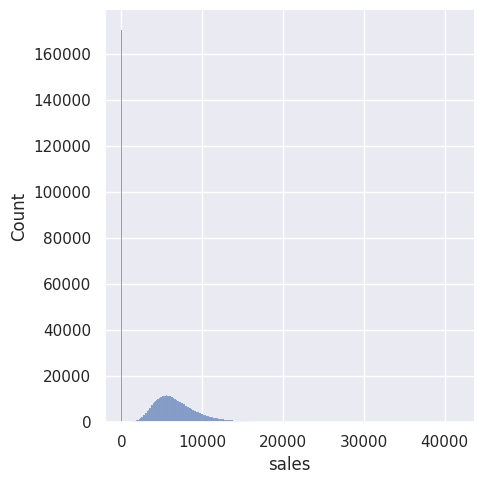

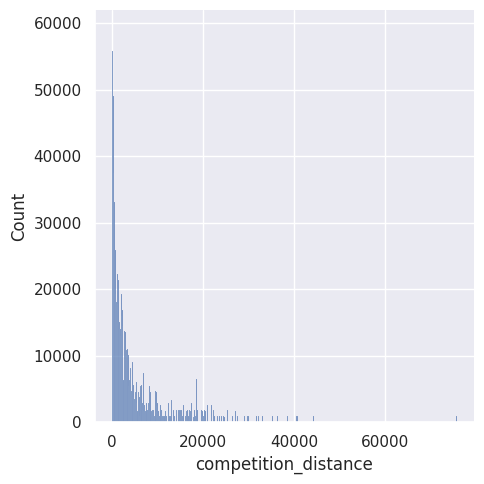

In [237]:
#sns.distplot(df1['sales']) #`distplot` is a deprecated function and will be removed in seaborn v0.14.0.
sns.displot(df1['sales'])
sns.displot(df1['competition_distance'])
!pip freeze | grep seaborn

### 1.7.2 Categorial Attributes

In [238]:
#Quantos niveis cada variável categorica tem? Como aplicar 1 função em todas as colunas?
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [239]:
#Quantos niveis cada variável categorica tem? Como aplicar 1 função em todas as colunas?
cat_attributes.apply(lambda x: x.unique())

state_holiday                                          [0, a, b, c]
store_type                                             [c, a, d, b]
assortment                                                [a, c, b]
promo_interval    [0, Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Jun,...
month_map         [Jul, Jun, May, Apr, Mar, Fev, Jan, Dec, Nov, ...
dtype: object

In [240]:
# a dimensão das variáveis está muito diferente
# provavel razão, dias fechado tendo vendas igual a zero

<Axes: xlabel='state_holiday', ylabel='sales'>

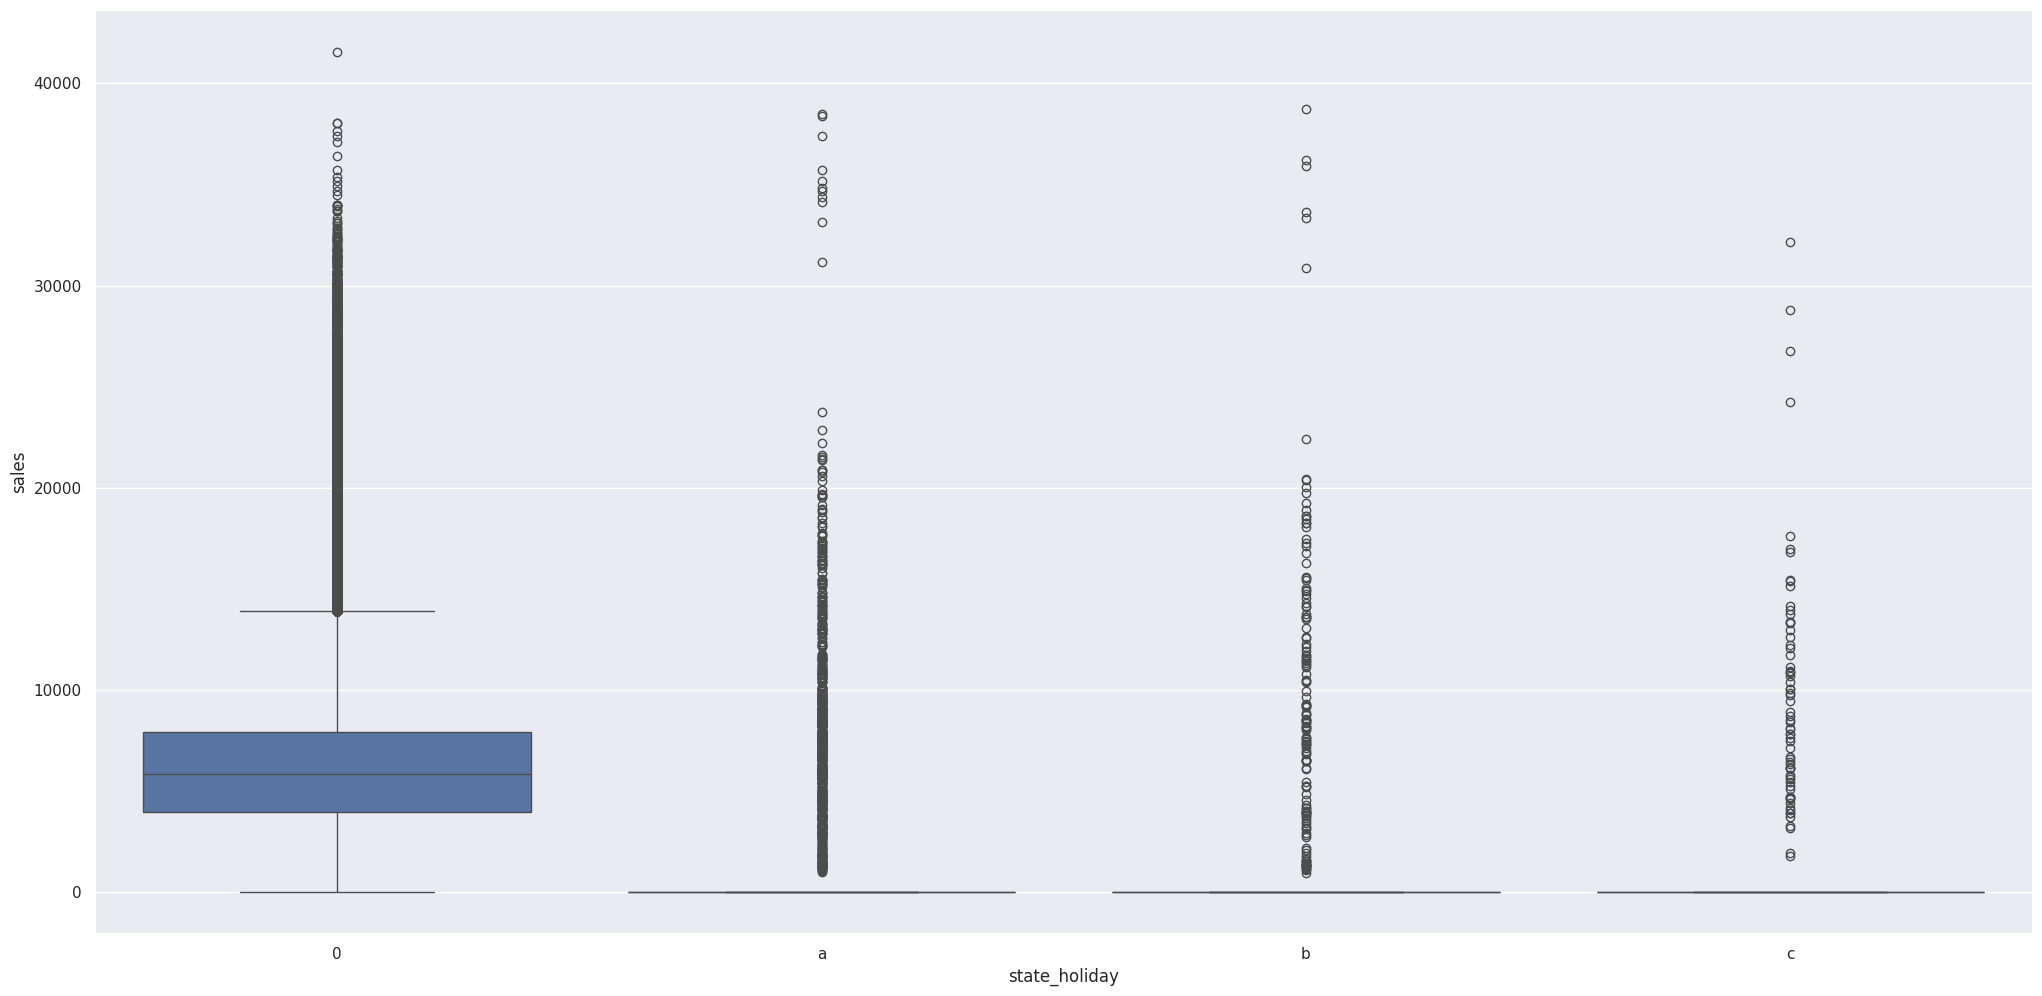

In [241]:
aux1=df1[(df1['state_holiday']!=0) & (df1['sales']>0)]
sns.boxplot(x='state_holiday', y='sales', data=df1)

<Axes: xlabel='assortment', ylabel='sales'>

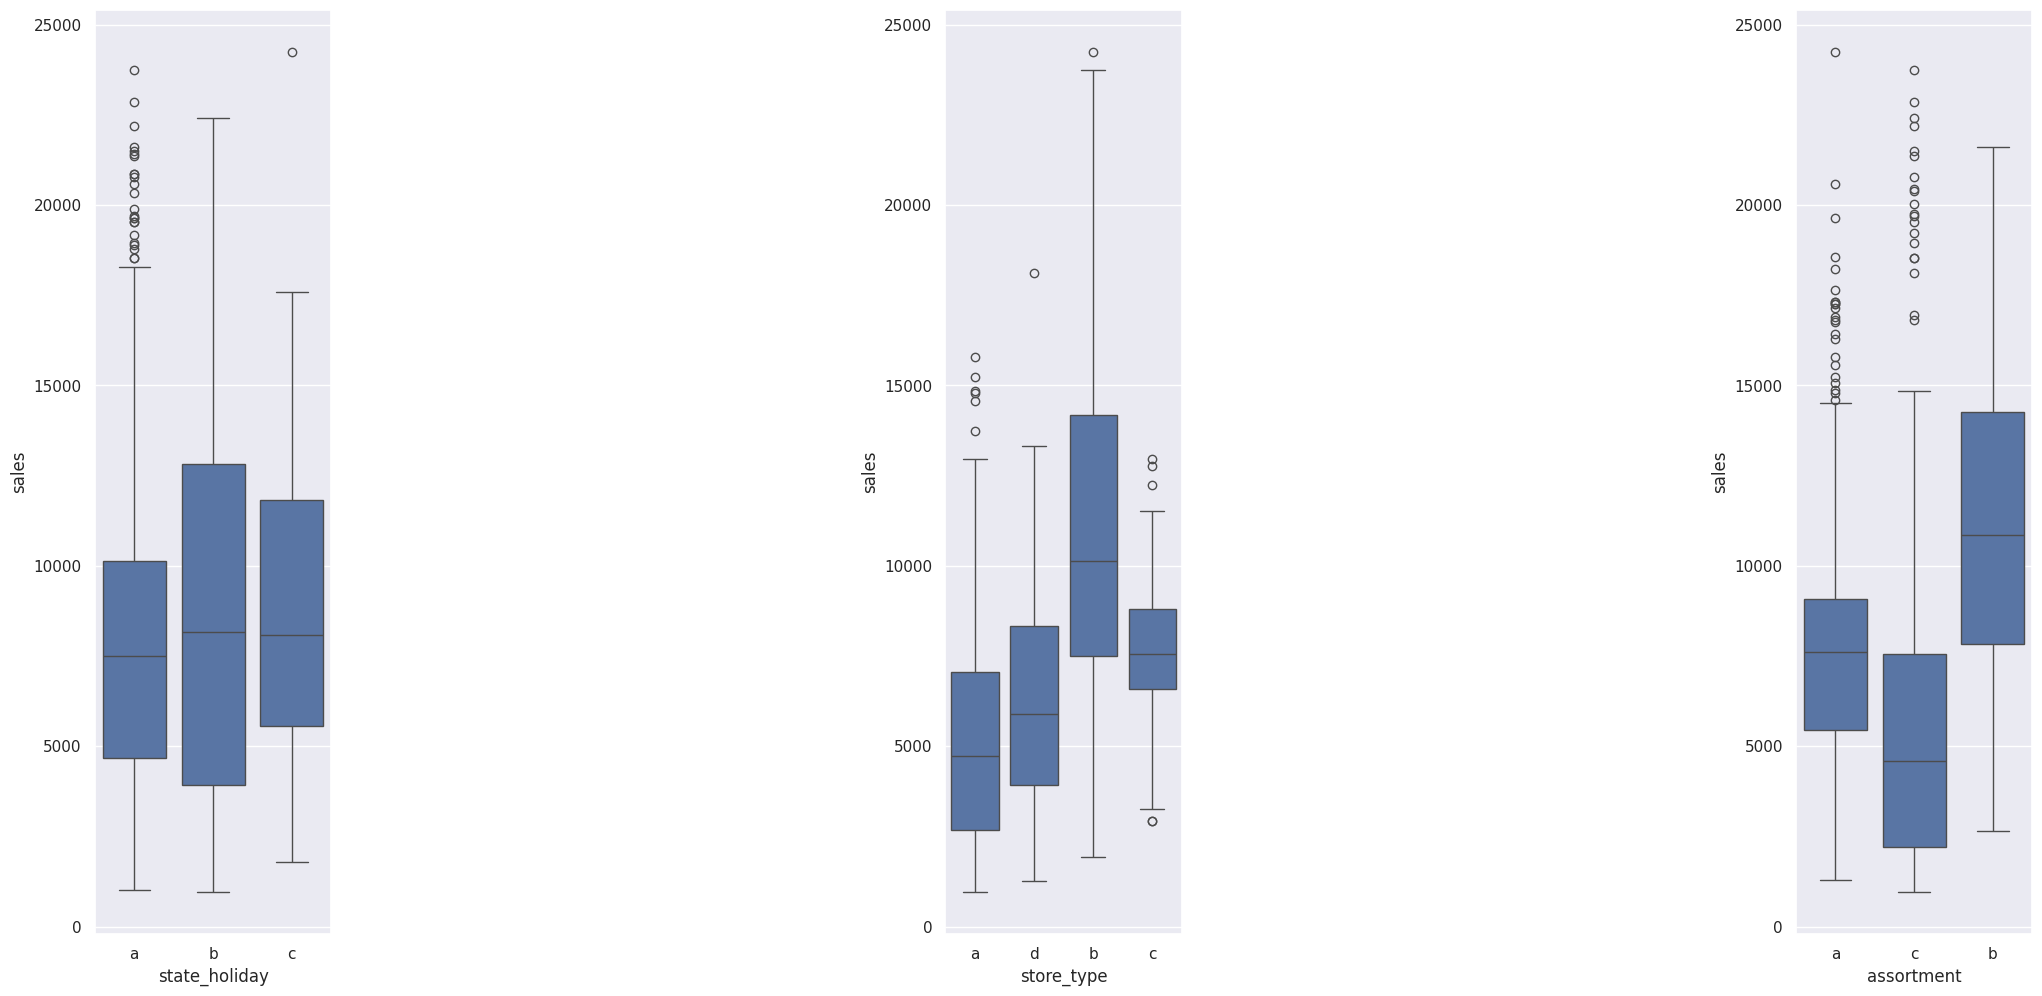

In [242]:
aux1=df1[(df1['state_holiday']!='0') & (df1['sales']>0) & (df1['sales']<25000)] #dia diferente do feriado e com vendas acima de zero

plt.subplot(1,7,1) #1 linha, 3 colunas, na posicão 1
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,7,4) #1 linha, 3 colunas, na posicão 2
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,7,7) #1 linha, 3 colunas, na posicão 1
sns.boxplot(x='assortment', y='sales', data=aux1)


# 2.0. PASSO 02 - FEATURE ENGINEERING

In [243]:
df2=df1.copy()

## 2.1. Mapa Mental de Hipoteses

In [244]:
Image('img/MindMapHipoteses_m03.png')

FileNotFoundError: No such file or directory: 'img/MindMapHipoteses_m03.png'

FileNotFoundError: No such file or directory: 'img/MindMapHipoteses_m03.png'

<IPython.core.display.Image object>

## 2.1. Criação de Hipoteses

### 2.1.1. Hipóteses Loja

** 1.** Lojas com maior quadro de funcionários deveriam vender mais.

** 1. ** Lojas com maior estoque deveriam vender mais.

**1.** Lojas com porte maior deveriam vender mais.

**1.** Lojas com menor porte deveriam vender menos.

**1.** Lojas com maior sortimento deveriam vender mais.

### 2.1.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos nas vitrines deveriam vender mais.

**3.** Lojas com produtos com preços menores deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promoções activas por mais tempo deveriam vender mais.

**6.** Lojas com + dias de promoção deveriam vender +.

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais.

**5.** Lojas com + promoções consecutivas deveriam vender +.

### 2.1.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender menos.

**1.** Lojas ao longo do ano deveriam vender mais.

**1.** Lojas no segundo semestre do ano deveriam vender mais.

**1.** Lojas depois do dia 10 de cada mes deveriam vender mais.

**1.** Lojas nos finais de semana deveriam vender menos.

**1.** Lojas nos Feriados escolares deveriam vender menos.
    

## 2.2. Lista Final de Hipóteses

**[1., 3.]** Lojas com [maior sortimento/ competidores à + tempo]  deveriam vender +.

**[2., ]** Lojas com competidores + próximo deveriam vender - .

** Produtos **

**[4., 5., 6.]** Lojas [promoções activas por mais tempo, com + [dias de promoção, promoções consecutivas]]  deveriam vender +

** Tempo **

**7.** Lojas abertas durante o feriado de Natal deveriam vender menos.

**8.** Lojas ao longo do ano deveriam vender mais.

**9.** Lojas no segundo semestre do ano deveriam vender mais.

**10.** Lojas depois do dia 10 de cada mes deveriam vender mais.

**11.** Lojas nos finais de semana deveriam vender menos.

**12.** Lojas nos Feriados escolares deveriam vender menos.

## 2.3. Feature Engineeringn

In [245]:
df2.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,id,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
468069,555,4,2014-04-24,3524,349,1,0,0,1,593982,d,a,1560.0,1,2014,1,10,2013,"Mar,Jun,Sept,Dec",Apr,0


In [246]:
# year
df2['year']=df2['date'].dt.year

# month
df2['month']=df2['date'].dt.month

# day
df2['day']=df2['date'].dt.day

# week of year
# df2['week_of_year']=df2['date'].dt.weekofyear #AttributeError: 'DatetimeProperties' object has no attribute 'weekofyear'
# Deprecated since version 1.1.0.
#https://pandas.pydata.org/pandas-docs/version/1.3/reference/api/pandas.Series.dt.weekofyear.html

#df2['week_of_year']=df2['date'].dt.isocalendar()
#df2['week_of_year']=df2['date'].dt.isocalendar().week

#df2['week_of_year']=df2['date'].dt.week #AttributeError: 'DatetimeProperties' object has no attribute 'week'

# year week
df2['year_week']=df2['date'].dt.strftime('%Y-%W') #AttributeError: 'DatetimeProperties' object has no attribute 'srtftime'
df2['year_week'].sample(5)
# competition since
#competition_open_since_month	competition_open_since_year
year='competition_open_since_year'
month='competition_open_since_month'
# considerou-se que o primeiro dia do mes, o dia que iniciou a competição #tempo desde que a competição começou em meses
df2['competition_open_since']=df2.apply( lambda x: datetime.datetime(year=x[year],month=x[month],day=1), axis=1)
df2['competition_time_month']=((df2['date']-df2['competition_open_since'])/30).apply(lambda x: x.days).astype(int)
df2['competition_time_month'].sample()

# promo since
# promo2_since_week	promo2_since_year

# assortment
# state holiday

281572    28
Name: competition_time_month, dtype: int64

In [247]:
# promo since
# promo2_since_week	promo2_since_year
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'].sample()


65280    2014-40
Name: promo_since, dtype: object

In [248]:
#passando a campo 'promo_since' de string para datetime64
df2['promo_since']=df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_since'].sample()

831264   2013-05-27
Name: promo_since, dtype: datetime64[ns]

In [249]:
# calculando o tempo, em semanas, desde que a promoção está activa, entre duas datas
# sinal negativo, vendas no período tradicional da promoção
# sinal positivo, vendas no período extendido da promoção
df2['promo_time_week']=((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
df2['promo_time_week'].sample(5)

785531    119
439219    125
7434      304
310664      0
127661    289
Name: promo_time_week, dtype: int64

In [250]:
# assortment

df2['assortment']=df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended')
df2['assortment'].sample(5)


898115    extended
165599    extended
134365       basic
743500       basic
122242    extended
Name: assortment, dtype: object

In [251]:
#df2=df1.copy()

In [252]:
df2['state_holiday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [253]:
# state holiday
# a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday']=df2['state_holiday'].apply(lambda x: 'public holiday' if x=='a' else 'Easter holiday' if x=='b'  else 'Christmas' if x=='c' else 'regular_day')
df2['state_holiday'].unique()

array(['regular_day', 'public holiday', 'Easter holiday', 'Christmas'],
      dtype=object)

# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [254]:
df3=df2.copy()

In [255]:
df3['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

In [256]:
df3.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,id,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,year_week,competition_open_since,competition_time_month,promo_since,promo_time_week
505756,332,5,2014-03-21,4086,552,1,1,regular_day,0,418788,a,basic,1840.0,3,2006,0,12,2014,0,Mar,0,2014,3,21,2014-11,2006-03-01,98,2014-03-17,0


## 3.1 Filtragem das linhas

In [257]:
df3 = df3[( df3['open'] != 0) & (df3['sales']>0)]

## 3.2 Seleção das colunas

In [258]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1) #axis=1 são colunas

In [259]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'id', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'month', 'day', 'year_week',
       'competition_open_since', 'competition_time_month', 'promo_since',
       'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - ANÁLISE EXPLORATÓRIA DE DADOS

### 4.1. Análise Univariada

In [260]:
df4 = df3.copy()

In [261]:
df4['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

#### 4.1.1. Response Variable

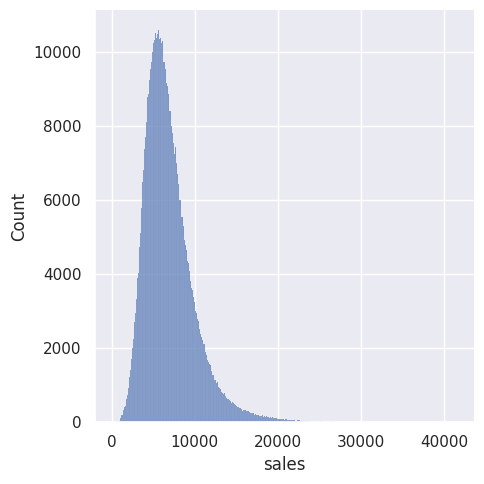

In [262]:
sns.displot(df4['sales'])

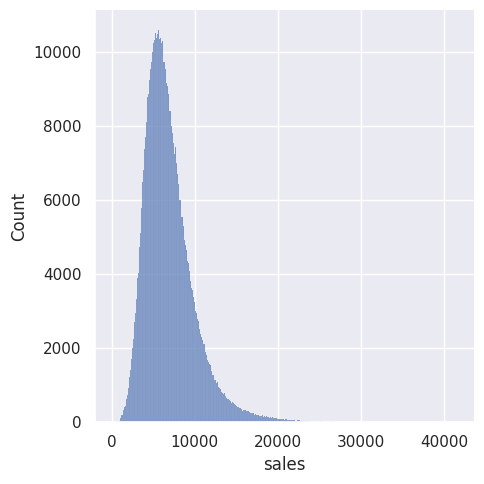

In [263]:
sns.displot(df4['sales'])

<ipython-input-264-03eab3dcf545>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(df4['sales']))


<Axes: xlabel='sales', ylabel='Density'>

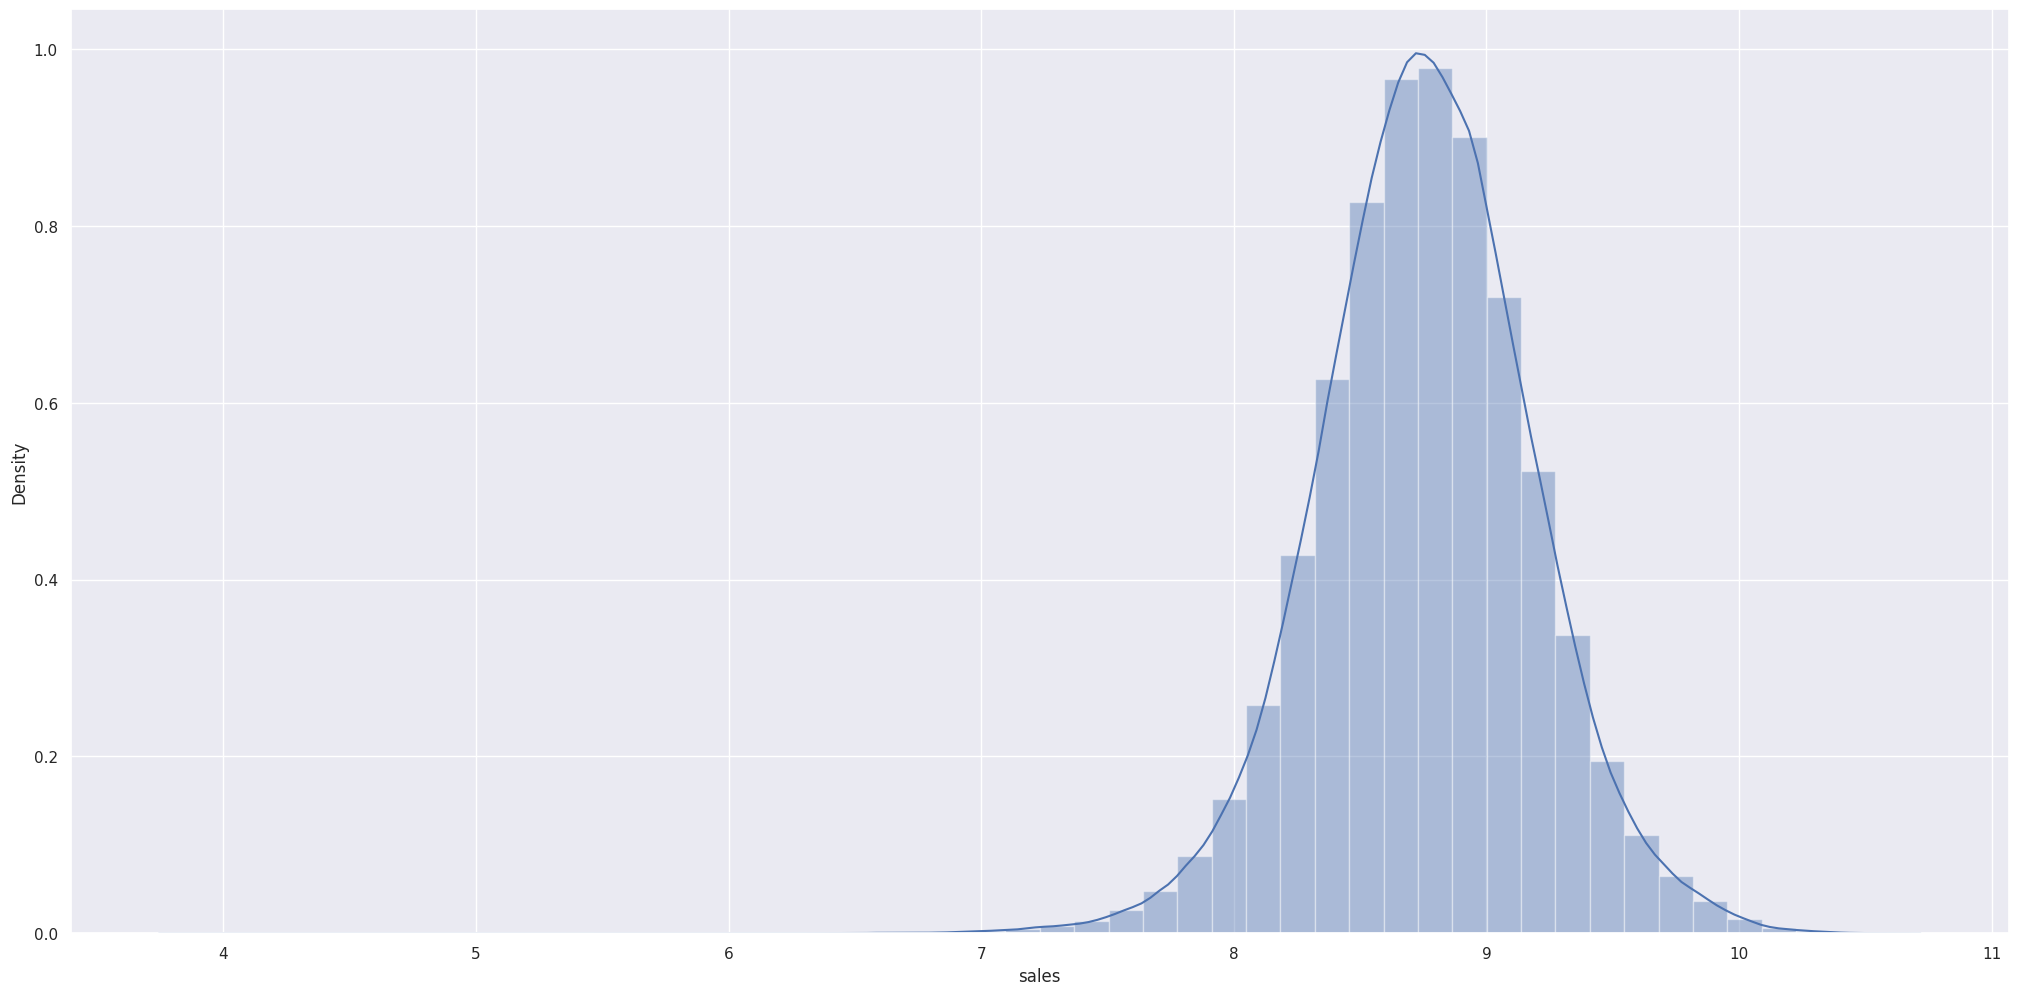

In [264]:
sns.distplot(np.log(df4['sales']))

#### 4.1.2. Numerical Variable

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'id'}>],
       [<Axes: title={'center': 'competition_distance'}>,
        <Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>],
       [<Axes: title={'center': 'promo2_since_week'}>,
        <Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >]], dtype=object)

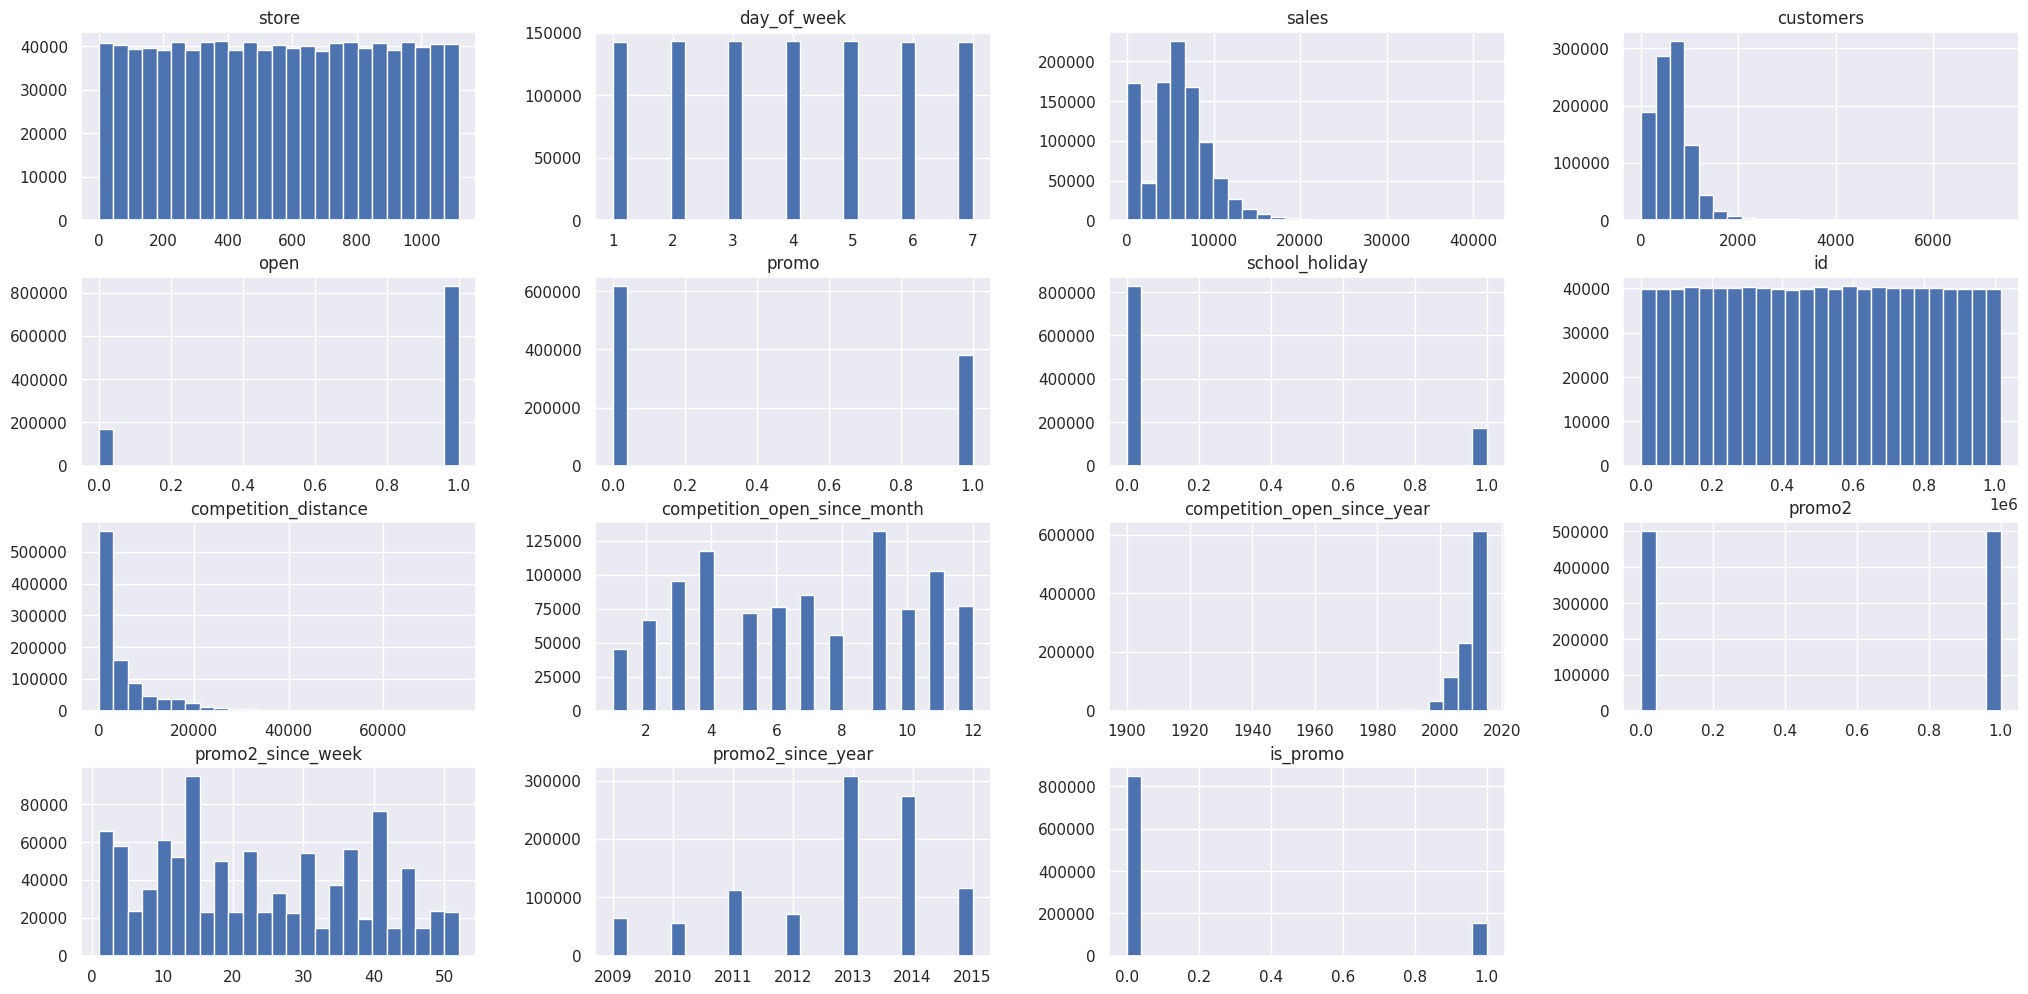

In [265]:
num_attributes.hist(bins=25)

In [266]:
cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_interval,month_map
823932,0,b,b,0,Jun
910927,0,a,c,0,Mar
83704,0,d,a,0,May
744539,0,a,a,"Feb,May,Aug,Nov",Aug
624412,0,a,a,0,Dec


In [267]:
df4['state_holiday'].drop_duplicates()

0            regular_day
47949     public holiday
113814    Easter holiday
225516         Christmas
Name: state_holiday, dtype: object

In [268]:
#df4[df4['state_holiday']!='public holiday']

In [269]:
#sns.countplot(df4['state_holiday'], orient='v')

In [270]:
#state_holiday,store_type,assortment

#### 4.1.3. Categorical Variable

In [271]:
df4['state_holiday'].drop_duplicates()

0            regular_day
47949     public holiday
113814    Easter holiday
225516         Christmas
Name: state_holiday, dtype: object

In [272]:
df4['state_holiday'].sample(4)

759250    regular_day
350293    regular_day
910193    regular_day
133421    regular_day
Name: state_holiday, dtype: object

In [273]:
df4[(df4['state_holiday']!='regular_day')&(df4['state_holiday']!='public holiday')&(df4['state_holiday']!='Easter holiday')].sample(5)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,id,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,year_week,competition_open_since,competition_time_month,promo_since,promo_time_week
225737,353,5,2014-12-26,8057,0,Christmas,1,211483,b,extra,900.0,12,2014,1,14,2013,0,2014,12,26,2014-51,2014-12-01,0,2013-04-01,90
226942,676,4,2014-12-25,10410,0,Christmas,1,81398,b,extra,1410.0,9,2008,0,52,2014,0,2014,12,25,2014-51,2008-09-01,76,2014-12-22,0
601826,512,3,2013-12-25,5608,0,Christmas,1,133748,b,extra,590.0,12,2013,1,5,2013,1,2013,12,25,2013-51,2013-12-01,0,2013-01-28,47
225660,262,5,2014-12-26,32169,0,Christmas,1,548186,b,basic,1180.0,5,2013,0,52,2014,0,2014,12,26,2014-51,2013-05-01,20,2014-12-22,0
226735,423,4,2014-12-25,10060,0,Christmas,1,854438,b,basic,1270.0,5,2014,0,52,2014,0,2014,12,25,2014-51,2014-05-01,7,2014-12-22,0


In [274]:
df5=df4[df4['state_holiday'] != 'regular_day']

In [275]:
# lista diferente de 'regular_day'
df5.state_holiday.unique()

array(['public holiday', 'Easter holiday', 'Christmas'], dtype=object)

In [276]:
#recebendo o tamanho da lista
for i in range(len(df4.state_holiday.unique())): # identificando o tamanho da lista
    if df4.state_holiday.unique()[i]!='regular_day': # verificando o valor do indice
        print(df4.state_holiday.unique()[i]) #visualizando o valor
        print (i) # mostrando o indice

public holiday
1
Easter holiday
2
Christmas
3


public holiday
Easter holiday
Christmas


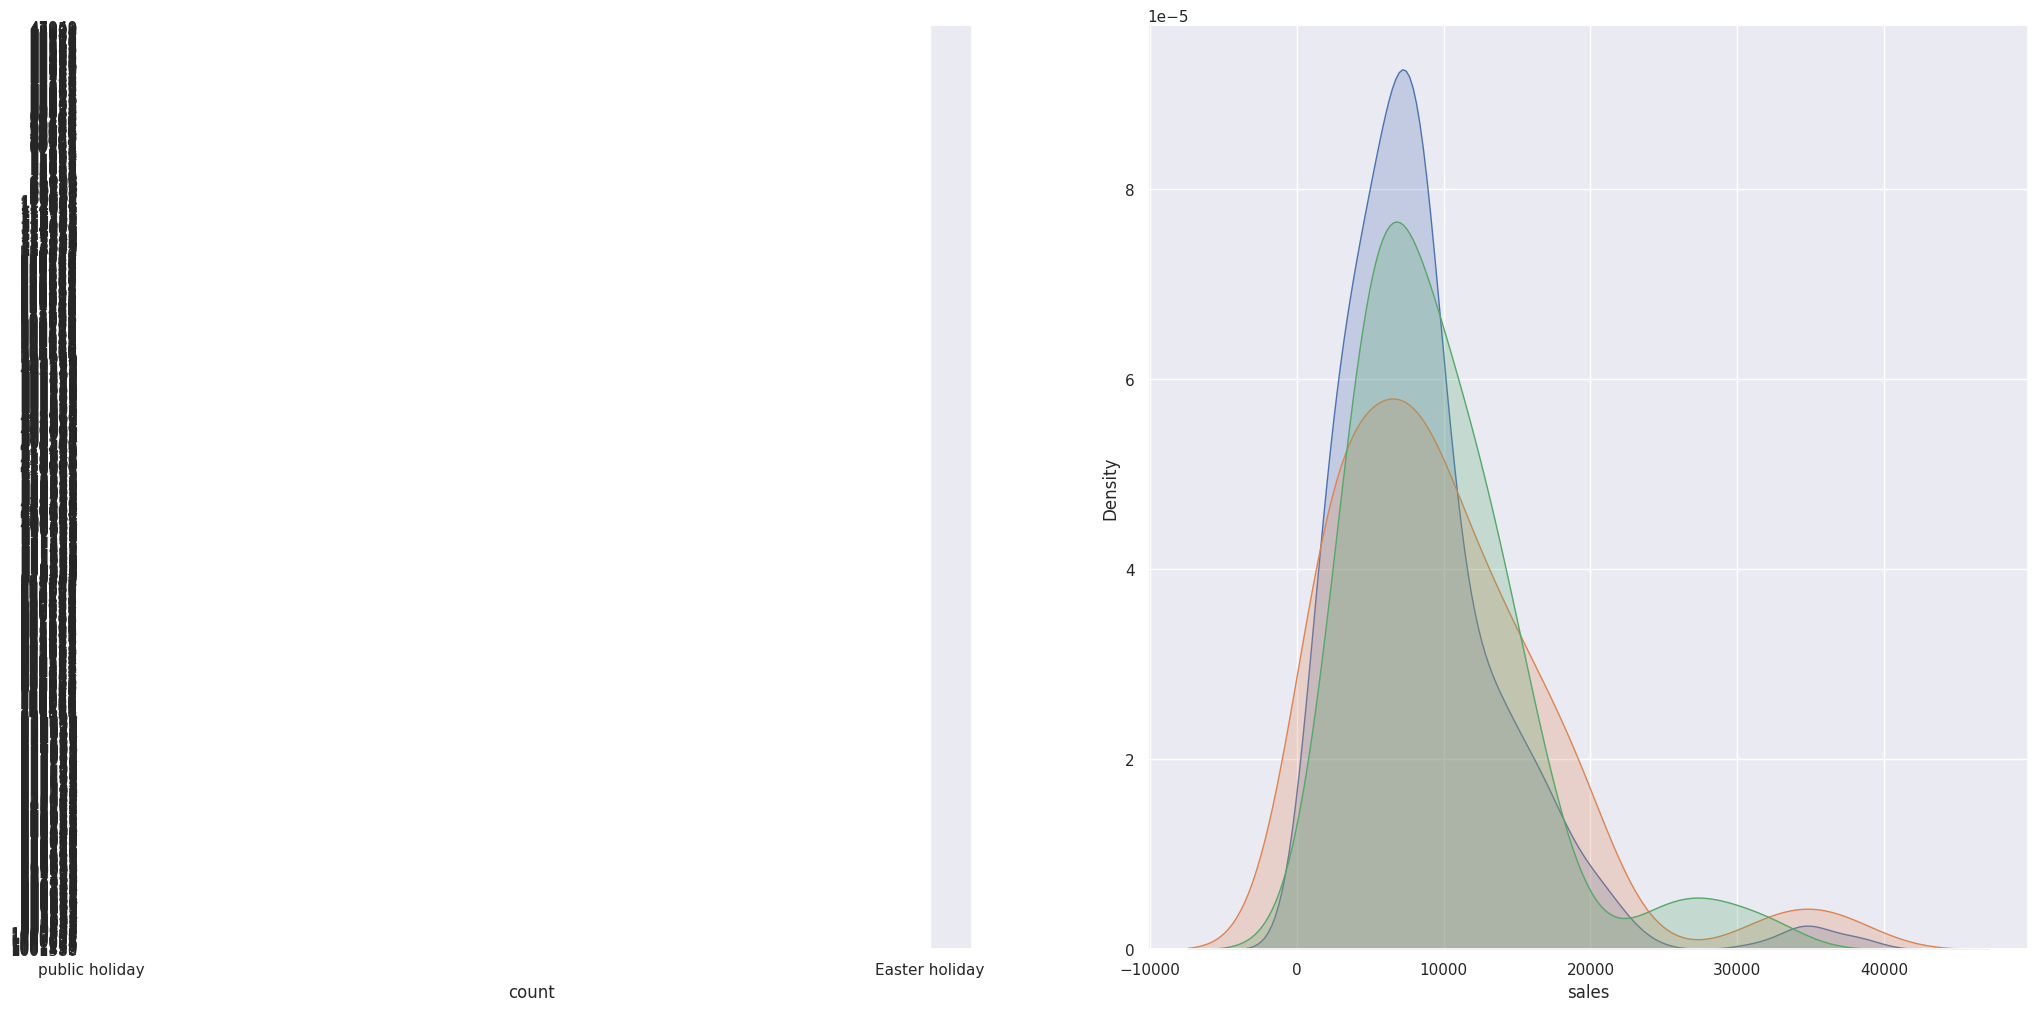

In [277]:
def plots(df, n):
    #for i to n:
    #        plt.subplot(1,n,i+1)
    plt.subplot(1,n,1)
    sns.countplot(df5['state_holiday'], orient='h' ) # “y” | “h” |“v” |  “x” | “y”

    #plt.subplot(1,n,i+1)
    plt.subplot(1,n,2)
    #label='public holiday'
    #sns.kdeplot(df4[df4['state_holiday']==label]['sales'], label=label, shade=True) #'Easter holiday, Christmas
    # `shade` is now deprecated in favor of `fill`; setting `fill=True`.
    #This will become an error in seaborn v0.14.0; please update your code.
    #for i in
    #import numpy.dtype
    for i in range(len(df4.state_holiday.unique())): # identificando o tamanho da lista
        if df4.state_holiday.unique()[i]!='regular_day': # verificando o valor do indice
            #print(df4.state_holiday.unique()[i]) #visualizando o valor
            label=df4.state_holiday.unique()[i]
            #df4.state_holiday.unique()[i]
            #sns.kdeplot(df4[df==label]['sales'], label=label, fill=True) #'Easter holiday, Christmas
            #sns.kdeplot(df4[df==int(df4.state_holiday.unique()[i])]['sales'], label=label, fill=True)

            #np.dtype(df4.state_holiday.unique()[i]) # TypeError: data type 'public holiday' not understood
            #label=df4.state_holiday.unique()[i] #'public holiday'
            sns.kdeplot(df4[df4['state_holiday']==label]['sales'], label=label, fill=True)
            print(label)
    #o grafico sobreposto e transparente facilita a observação do pico e largura na distribuição das variáveis
    # visualizando as distribuições sobre postas

plots(df4['state_holiday'], 2)

In [278]:
#no primeiro plot não visualizo a categoria Christmas no grafico
#no segundo plot não visualiza a legenda das categorias

In [279]:
#df4[df4['state_holiday']==label]['sales']

In [280]:
#public_holiday

In [281]:
df5.shape

(910, 25)

In [282]:
#plot(df4['state_holiday'],
#def plot(df,
#a = df4[df4['state_holiday']!='regular_day'] #'regular_day' , KeyError: "None of [Index(['regular_day'
###a = df4[df4['state_holiday']!='regular_day'] #'regular_day' , KeyError: "None of [Index(['regular_day'
###plt.subplot(1,2,1)
###sns.countplot(a.state_holiday, orient='h') #orient=None , “v” | “h” | “x” | “y”
###a.state_holiday.unique()
# não apresenta informação de 'Christmas'] no grafico

###plt.subplot(1,2,2)
###for i in range(len(df4.state_holiday.unique())):
    #grafico com as
    ###label=df4.state_holiday.unique()[i]

    ###if label != 'regular_day':
        #print(df4.state_holiday.unique()[i])
        ###sns.kdeplot(df4[df4['state_holiday']==label]['sales'], label=label, fill=True)
        #print(i)
# o grafico 1,
# o grafico 2, não visualiza a legenda

In [283]:
##plt.subplot(1,2,2)
##label='public holiday'
#sns.kdeplot(df4[df4['state_holiday']==label]['sales'], label=label, shade=True) #'Easter holiday, Christmas
# `shade` is now deprecated in favor of `fill`; setting `fill=True`.
#This will become an error in seaborn v0.14.0; please update your code.
##sns.kdeplot(df4[df4['state_holiday']==label]['sales'], label=label, fill=True) #'Easter holiday, Christmas
#o grafico sobreposto e transparente facilita a observação do pico e largura na distribuição das variáveis
# visualizar as distribuições sobre postas


In [284]:
#plot(df4['state_holiday'],
#def plot(df,
#a = df4[df4['state_holiday']!='regular_day'] #'regular_day' , KeyError: "None of [Index(['regular_day'
###a = df4[df4['state_holiday']!='regular_day'] #'regular_day' , KeyError: "None of [Index(['regular_day'
###plt.subplot(1,2,1)
###sns.countplot(a.state_holiday, orient='h') #orient=None , “v” | “h” | “x” | “y”
###a.state_holiday.unique()
# não apresenta informação de 'Christmas'] no grafico

###plt.subplot(1,2,2)
###for i in range(len(df4.state_holiday.unique())):
    #grafico com as
    ###label=df4.state_holiday.unique()[i]

    ###if label != 'regular_day':
        #print(df4.state_holiday.unique()[i])
       ### sns.kdeplot(df4[df4['state_holiday']==label]['sales'], label=str(label), fill=True)
        #print(i)
# o grafico 1,
# o grafico 2, não visualiza a legenda

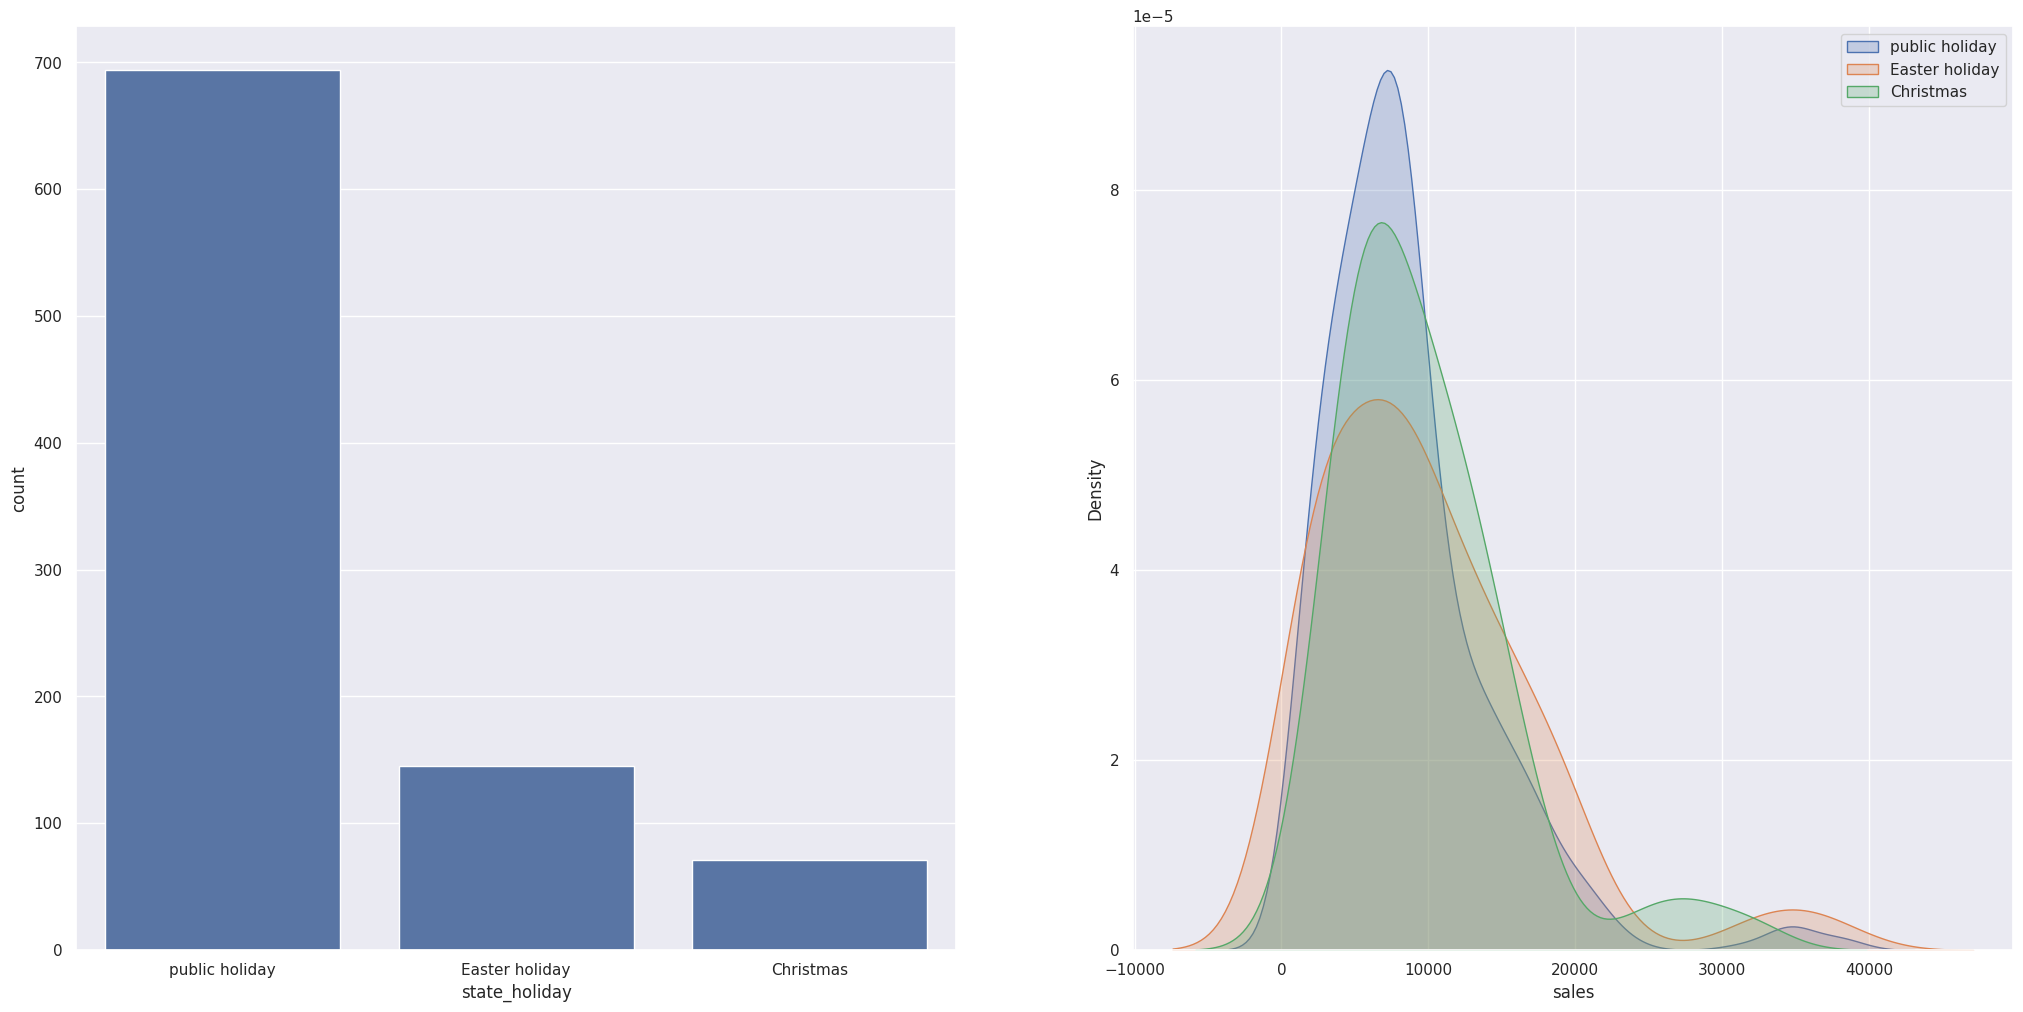

In [285]:
#plot(df4['state_holiday'],
#def plot(df,
#a = df4[df4['state_holiday']!='regular_day'] #'regular_day' , KeyError: "None of [Index(['regular_day'
a = df4[df4['state_holiday']!='regular_day'] #'regular_day' , KeyError: "None of [Index(['regular_day'
plt.subplot(1,2,1)
sns.countplot(a,x='state_holiday', orient='h') #orient=None , “v” | “h” | “x” | “y”
a.state_holiday.unique()
# não apresenta informação de 'Christmas'] no grafico

plt.subplot(1,2,2)
for i in range(len(df4.state_holiday.unique())):
    #grafico com as
    label=df4.state_holiday.unique()[i]

    if label != 'regular_day':
        #print(df4.state_holiday.unique()[i])
        g=sns.kdeplot(df4[df4['state_holiday']==label]['sales'], label=str(label), fill=True)
        #print(i)
g.legend(loc="upper right")

# o grafico 1,
# o grafico 2, não visualiza a legenda

In [286]:
#plot(df4['store_type'],
#def plot(df,
#a = df4[df4['store_type']!='regular_day'] #'regular_day' , KeyError: "None of [Index(['regular_day'
#a = df4[df4['store_type']!='regular_day'] #'regular_day' , KeyError: "None of [Index(['regular_day'
###plt.subplot(1,2,1)
###sns.countplot(df4,x='store_type', orient='h') #orient=None , “v” | “h” | “x” | “y”
###a.store_type.unique()
# não apresenta informação de 'Christmas'] no grafico

###plt.subplot(1,2,2)
###for i in range(len(df4.store_type.unique())):
    #grafico com as
   ### label=df4.state_holiday.unique()[i]

    #if label != 'regular_day':
        #print(df4.state_holiday.unique()[i])
    ###g=sns.kdeplot(df4[df4['store_type']==label]['sales'], label=str(label), fill=True)
        #print(i)
###g.legend(loc="upper right")

# o grafico 1,
# o grafico 2, não visualiza a legenda

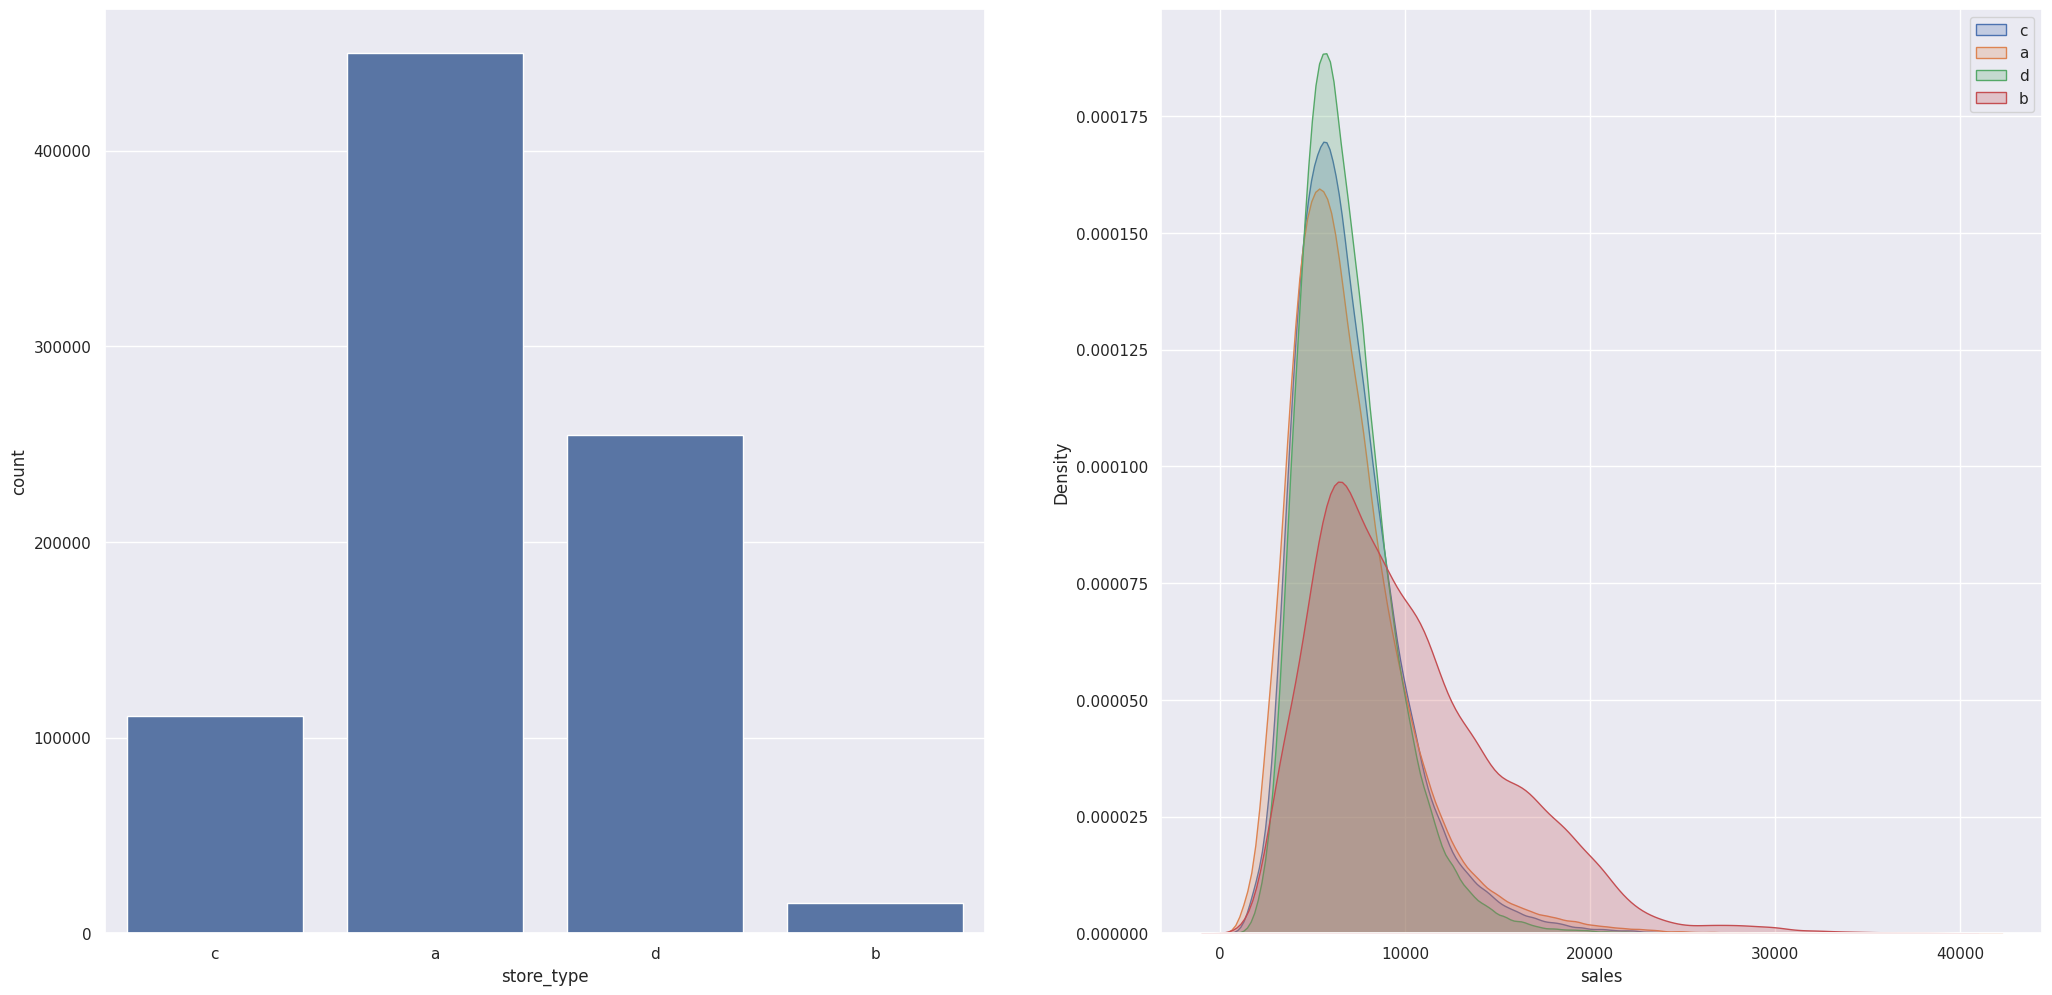

In [287]:
#plot(df4['store_type'],
#def plot(df,
#a = df4[df4['store_type']!='regular_day'] #'regular_day' , KeyError: "None of [Index(['regular_day'
#a = df4[df4['assortment']!='regular_day'] #'regular_day' , KeyError: "None of [Index(['regular_day'
plt.subplot(1,2,1)
sns.countplot(df4,x='store_type', orient='h') #orient=None , “v” | “h” | “x” | “y”
a.store_type.unique()
# não apresenta informação de 'Christmas'] no grafico

plt.subplot(1,2,2)
for i in range(len(df4.store_type.unique())):
    #grafico com as
    label=df4.store_type.unique()[i]

    #if label != 'regular_day':
        #print(df4.store_type.unique()[i])
    g=sns.kdeplot(df4[df4['store_type']==label]['sales'], label=str(label), fill=True)
        #print(i)
g.legend(loc="upper right")

# o grafico 1,
# o grafico 2, não visualiza a legenda

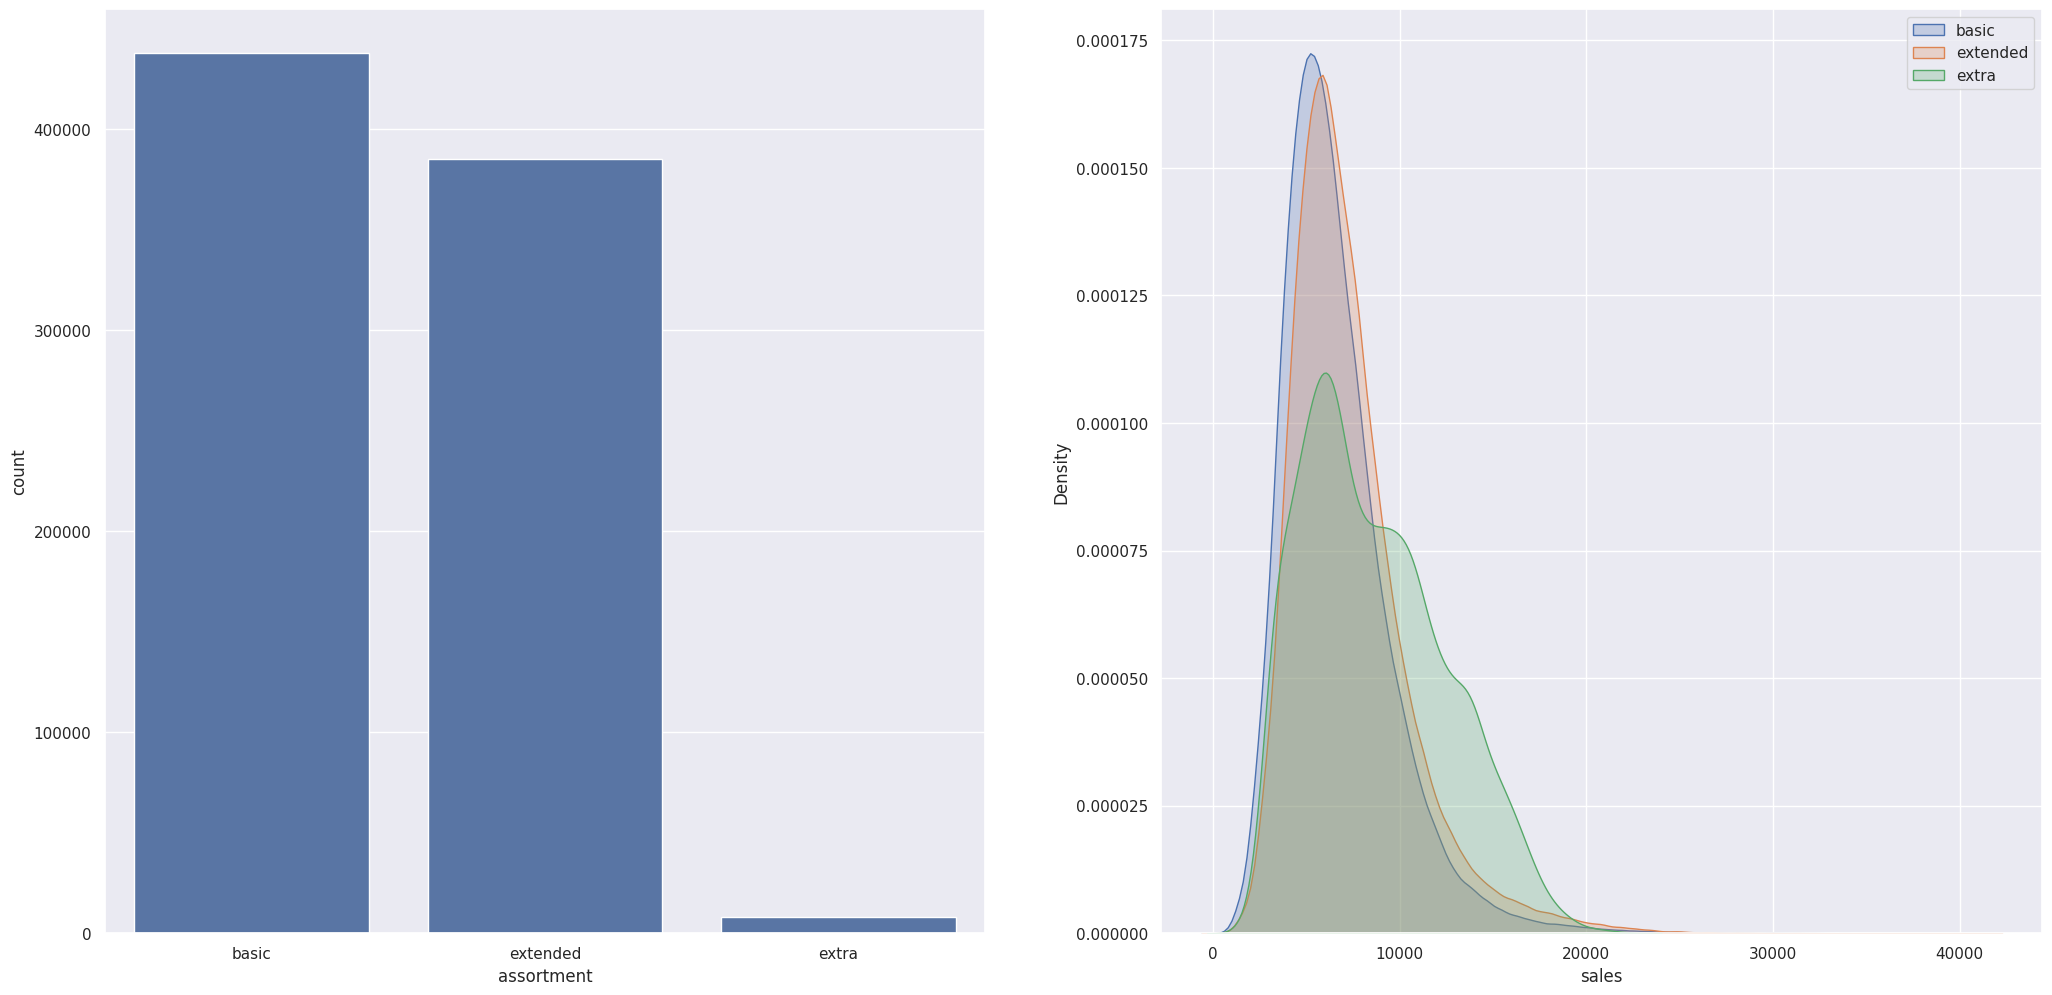

In [288]:
#plot(df4['assortment'],
#def plot(df,
#a = df4[df4['assortment']!='regular_day'] #'regular_day' , KeyError: "None of [Index(['regular_day'
#a = df4[df4['assortment']!='regular_day'] #'regular_day' , KeyError: "None of [Index(['regular_day'
plt.subplot(1,2,1)
sns.countplot(df4,x='assortment', orient='h') #orient=None , “v” | “h” | “x” | “y”
a.assortment.unique()
# não apresenta informação de 'Christmas'] no grafico

plt.subplot(1,2,2)
for i in range(len(df4.assortment.unique())):
    #grafico com as
    label=df4.assortment.unique()[i]

    #if label != 'regular_day':
        #print(df4.assortment.unique()[i])
    g=sns.kdeplot(df4[df4['assortment']==label]['sales'], label=str(label), fill=True)
        #print(i)
g.legend(loc="upper right")

# o grafico 1,
# o grafico 2, não visualiza a legenda

In [289]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
id                                       int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int32
month                                    int32
day                                      int32
year_week                               object
competition_o

In [290]:
#store_type
#change state_holiday to store_type object
#a = df4[df4['store_type']] #'regular_day' , KeyError: "None of [Index(['regular_day'
#plt.subplot(1,2,1)# change 1 to second line
#plt.subplot(2,2,1)

In [291]:
#change state_holiday to store_type object
###plt.subplot(1,2,1)
###sns.countplot(df4["store_type"], orient='h') #orient=None , “v” | “h” | “x” | “y”
#a.state_holiday.unique()
# não apresenta informação de 'Christmas' no grafico

##plt.subplot(1,2,2) #change 1 to 2
#plt.subplot(2,2,2)

###plt.subplot(1,2,2)

###try_="df4."  + "store_type" + ".unique()"
#for i in range(len(df4.state_holiday.unique())): change state_holiday to store_type#
#for i in range(len(df4.store_type.unique())):
###for i in range(len(try_)):
    #grafico com as
    #label=df4.state_holiday.unique()[i] change state_holiday to store_type###
    ###label=df4.store_type.unique()[i]

    ###if label != 'regular_day':
        #print(df4.state_holiday.unique()[i])
        #sns.kdeplot(df4[df4['state_holiday']==label]['sales'], label=label, fill=True) change state_holiday to store_type
        ###sns.kdeplot(df4[df4['store_type']==label]['sales'], label=label, fill=True)
    ###sns.kdeplot(df4[df4['store_type']==label]['sales'], label=label, fill=True)
        #print(i)
# o grafico 1,
# o grafico 2, não visualiza a legenda
#assortment                              object
#df4.store_type.unique()

In [292]:
#store_type
#change state_holiday to store_type object
####a = df4[df4['store_type']!='regular_day'] #'regular_day' , KeyError: "None of [Index(['regular_day'
#plt.subplot(1,2,1) change 1 to second line
####plt.subplot(2,2,1)

#change state_holiday to store_type object
####sns.countplot(a.store_type, orient='h') #orient=None , “v” | “h” | “x” | “y”
#a.state_holiday.unique()
# não apresenta informação de 'Christmas'] no grafico

#plt.subplot(1,2,2) change 1 to 2
####plt.subplot(2,2,2)
#for i in range(len(df4.state_holiday.unique())): change state_holiday to store_type
####for i in range(len(df4.store_type.unique())):
    #grafico com as
    #label=df4.state_holiday.unique()[i] change state_holiday to store_type
    ####label=df4.store_type.unique()[i]

    ####if label != 'regular_day':
        #print(df4.state_holiday.unique()[i])
        #sns.kdeplot(df4[df4['state_holiday']==label]['sales'], label=label, fill=True) change state_holiday to store_type
        ####sns.kdeplot(df4[df4['store_type']==label]['sales'], label=label, fill=True)
        #print(i)
# o grafico 1,
# o grafico 2, não visualiza a legenda
#assortment                              object
#df4.store_type.unique()

### 4.1.3. Categorical Variable, diamonds = sns.load_dataset('diamonds')

In [293]:
#https://www.youtube.com/watch?v=8U5h3EJuu8M
#Seaborn countplot | What is the countplot? | Seaborn countplot vs barplot
diamonds = sns.load_dataset('diamonds')
diamonds.sample()

,carat,cut,color,clarity,depth,table,price,x,y,z
39372,0.41,Premium,G,VVS1,59.7,60.0,1074,4.83,4.85,2.89


In [294]:
diamonds.clarity.isin(['SI1', 'VS2']).shape

(53940,)

In [295]:
diamonds[diamonds.clarity.isin(['SI1', 'VS2'])].shape

(25323, 10)

<Axes: xlabel='color', ylabel='count'>

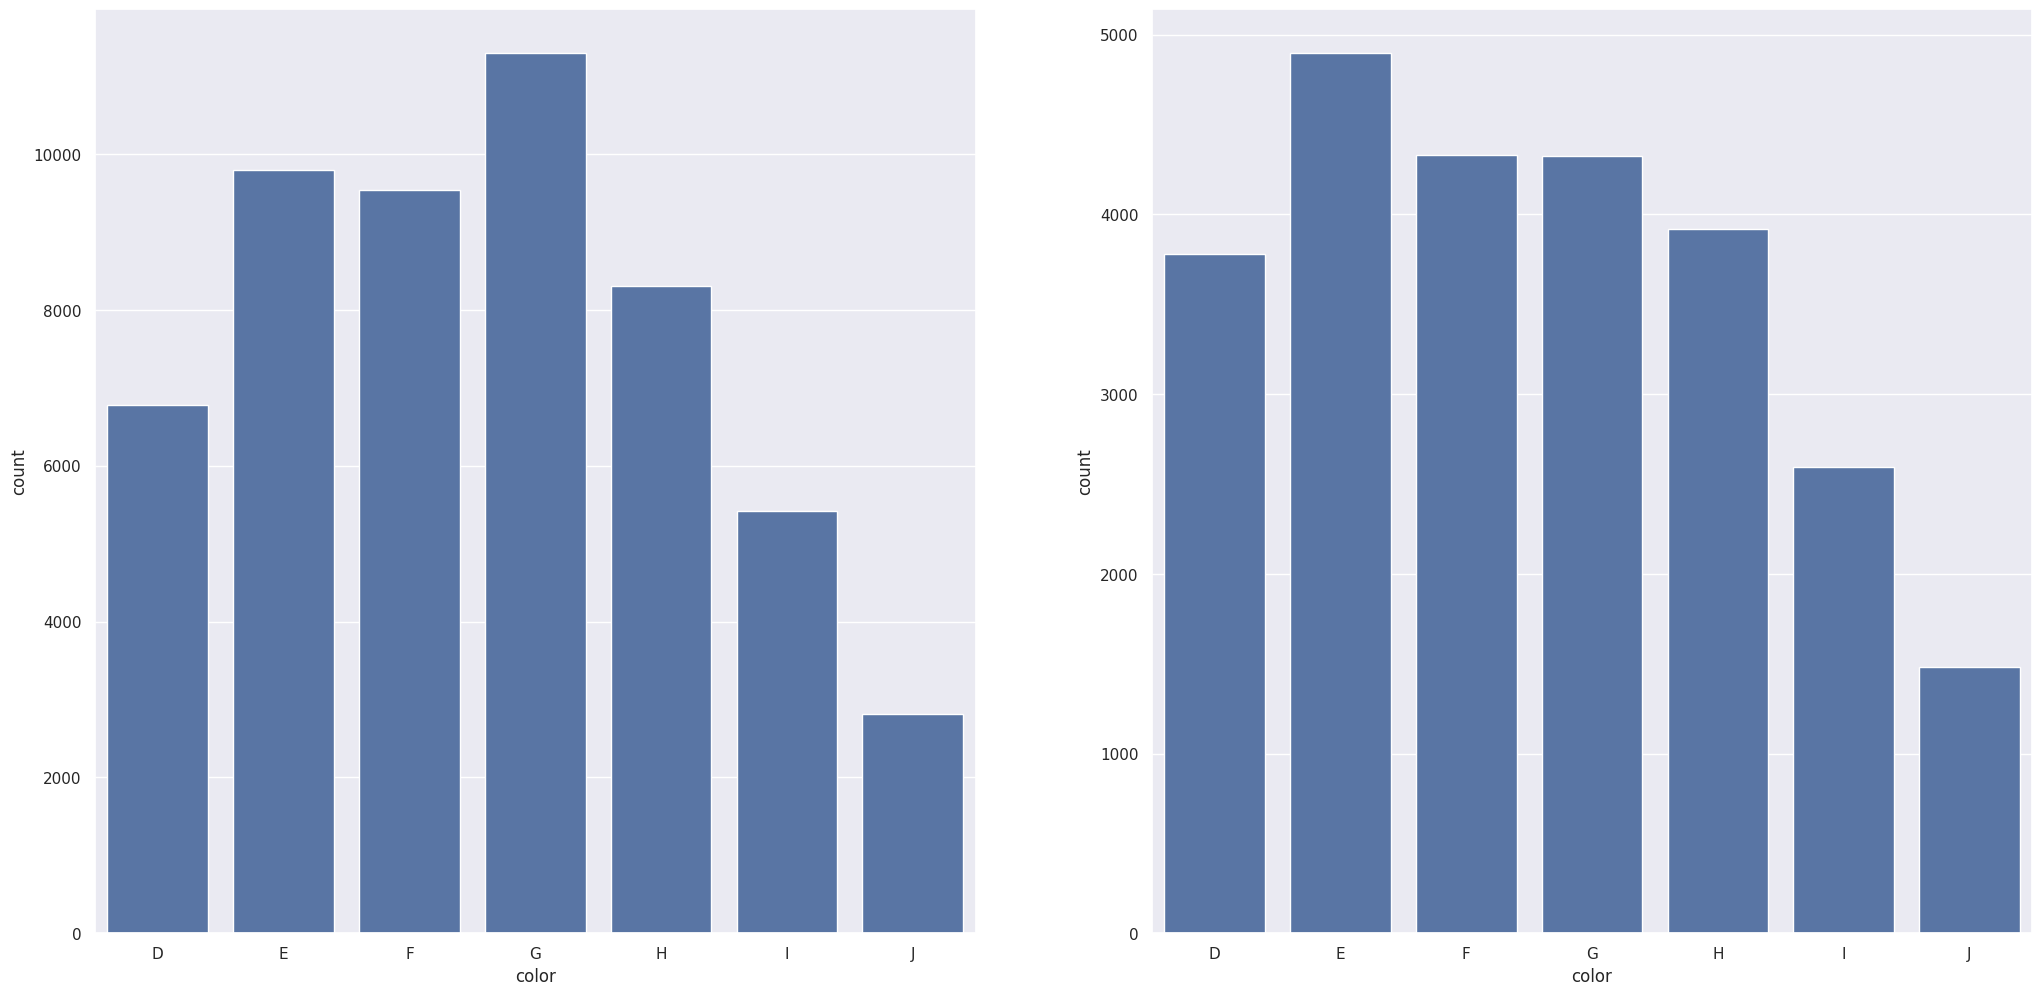

In [296]:
sns.set_style('darkgrid')
plt.subplot(1,2,1)
sns.countplot(x='color', data=diamonds)
plt.subplot(1,2,2)
sns.countplot(x='color', data=diamonds[diamonds.clarity.isin(['SI1', 'VS2'])])

In [297]:
diamonds.dtypes

carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object

0     E
3     I
4     J
7     H
12    F
25    G
28    D
Name: color, dtype: category
Categories (7, object): ['D', 'E', 'F', 'G', 'H', 'I', 'J']

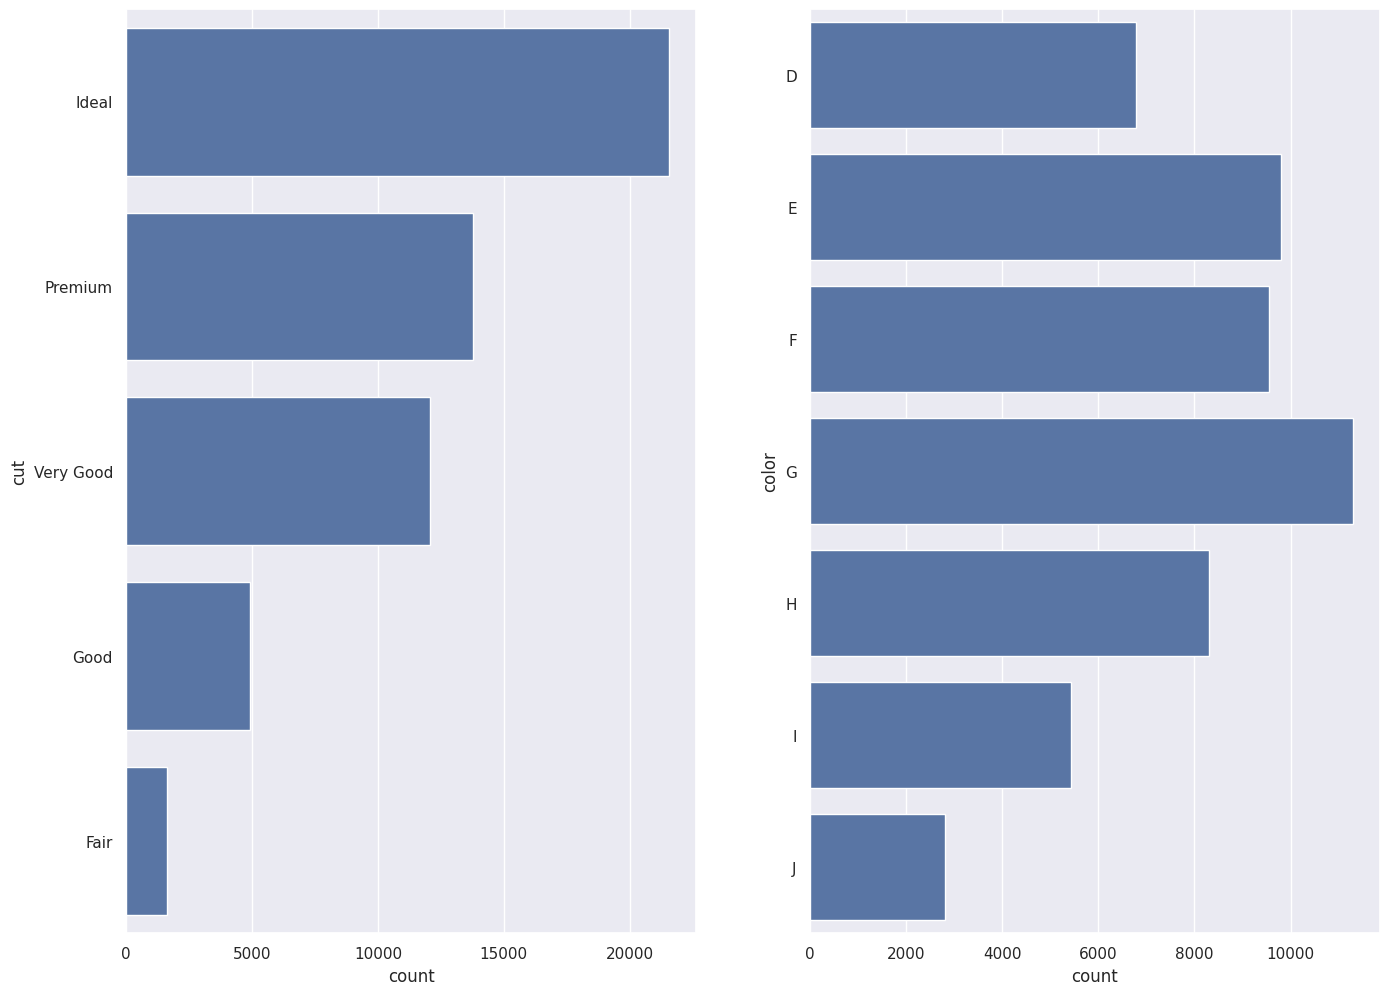

In [298]:
plt.subplot(1,3,1)
#cut
sns.countplot(diamonds.cut) #, orient="y") #orient“v” | “h” | “x” | “y”
#color
plt.subplot(1,3,2)
sns.countplot(diamonds.color) #, orient="y")
#diamonds.color.drop_duplicates()
diamonds['color'].drop_duplicates()
#clarity

In [299]:
diamonds.color.cat.categories

Index(['D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype='object')

In [300]:
diamonds.cut.cat.categories

Index(['Ideal', 'Premium', 'Very Good', 'Good', 'Fair'], dtype='object')

In [301]:
diamonds.clarity.cat.categories

Index(['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1'], dtype='object')

### 4.2. Análise Bivariada

### **2.2. Lista Final de Hipóteses**

#### **H1. Lojas com maior sortimento deveriam vender mais.**
#### **FALSA**, lojas com MAIOR SORTIMENTO vendem MENOS
[1., 3.] Lojas com [maior sortimento/ competidores à + tempo] deveriam vender +.

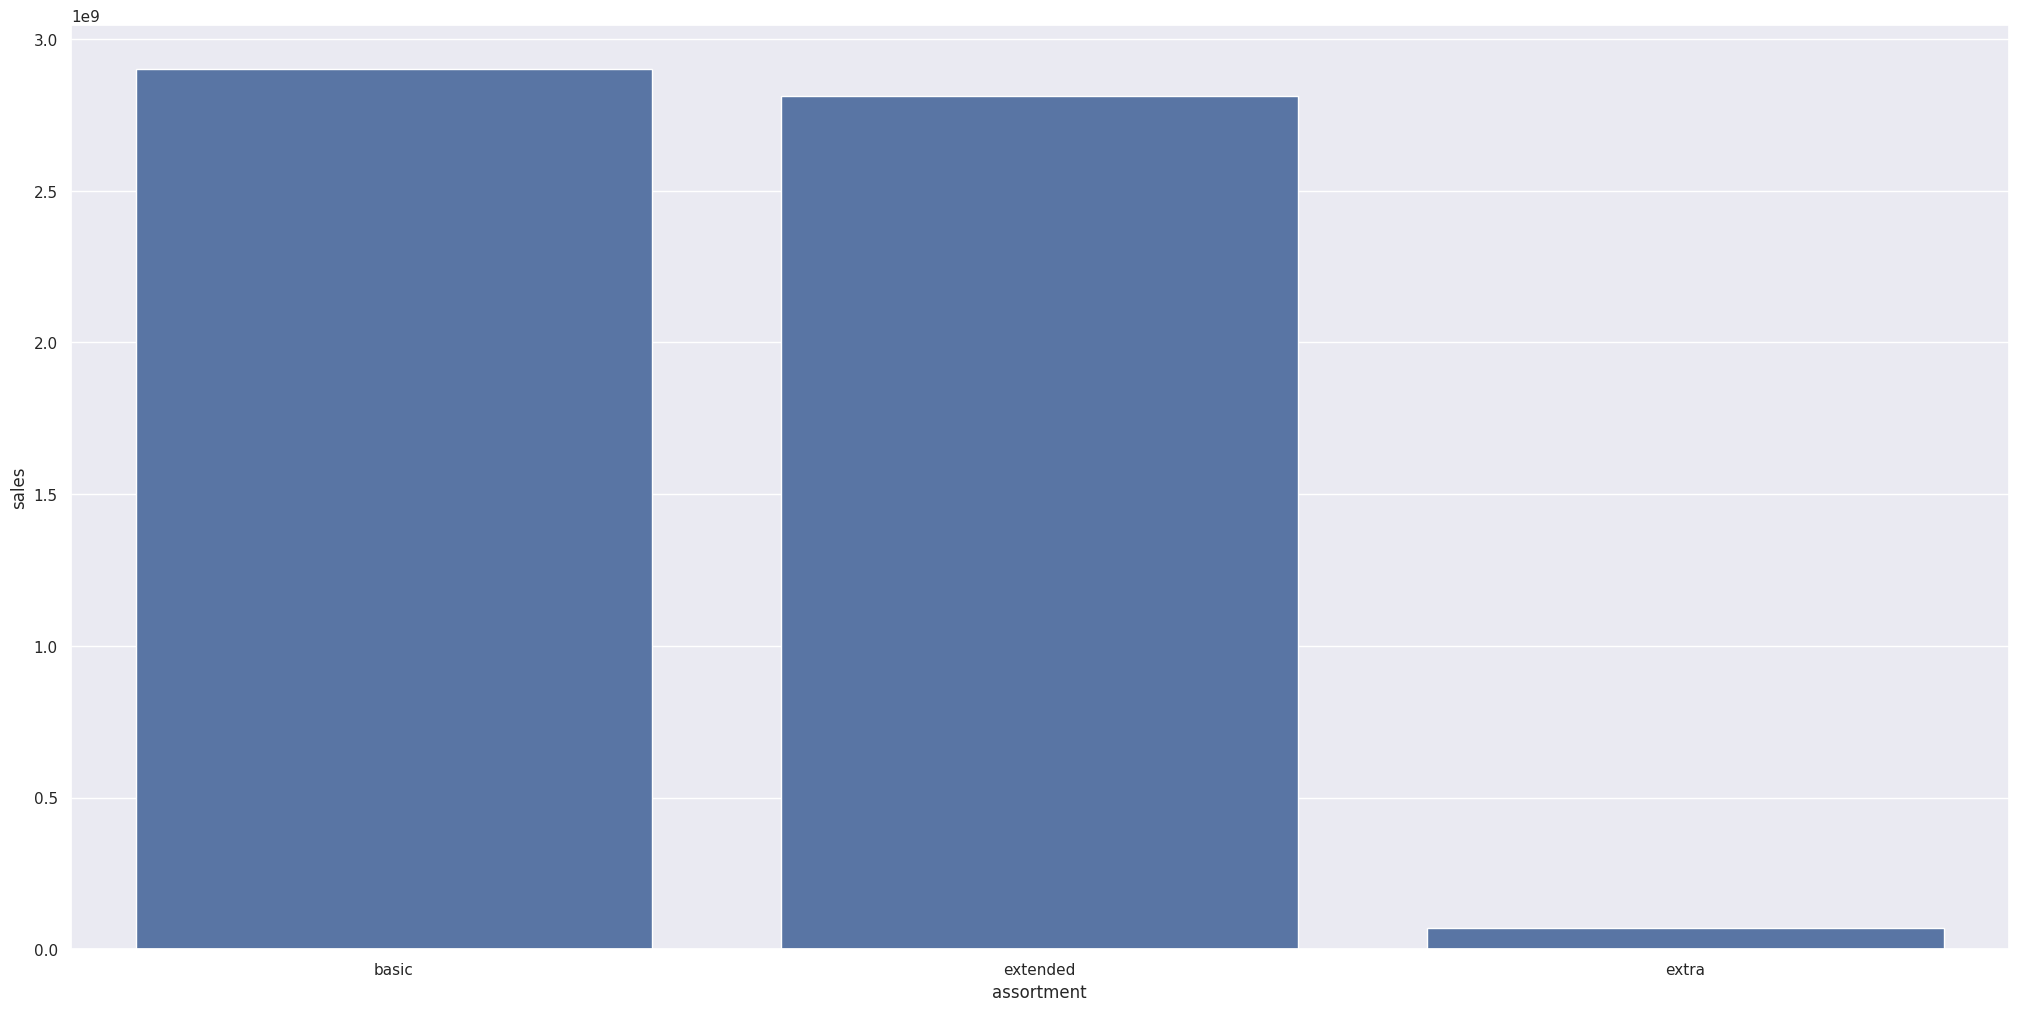

In [302]:
#[1., 3.] Lojas com [maior sortimento/ competidores à + tempo] deveriam vender +.
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
#soma de todas as vendas que tem o assortment do tipo ...
sns.barplot(x='assortment', y='sales', data=aux1);

#### assortment do tipo basic e o extended tem mais ou menos o mesmo tipo de vendas e o extra tem o volume de vendas bem menor
supondo que o extra é o maior assortment vemos um tendencia decrescente
Será que houve uma mudança do comportamento ao longo do tempo

In [303]:
# como o tempo, semanas do ano, afecta o fenomeno do assortment relativamente as vendas
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()

<Axes: xlabel='year_week'>

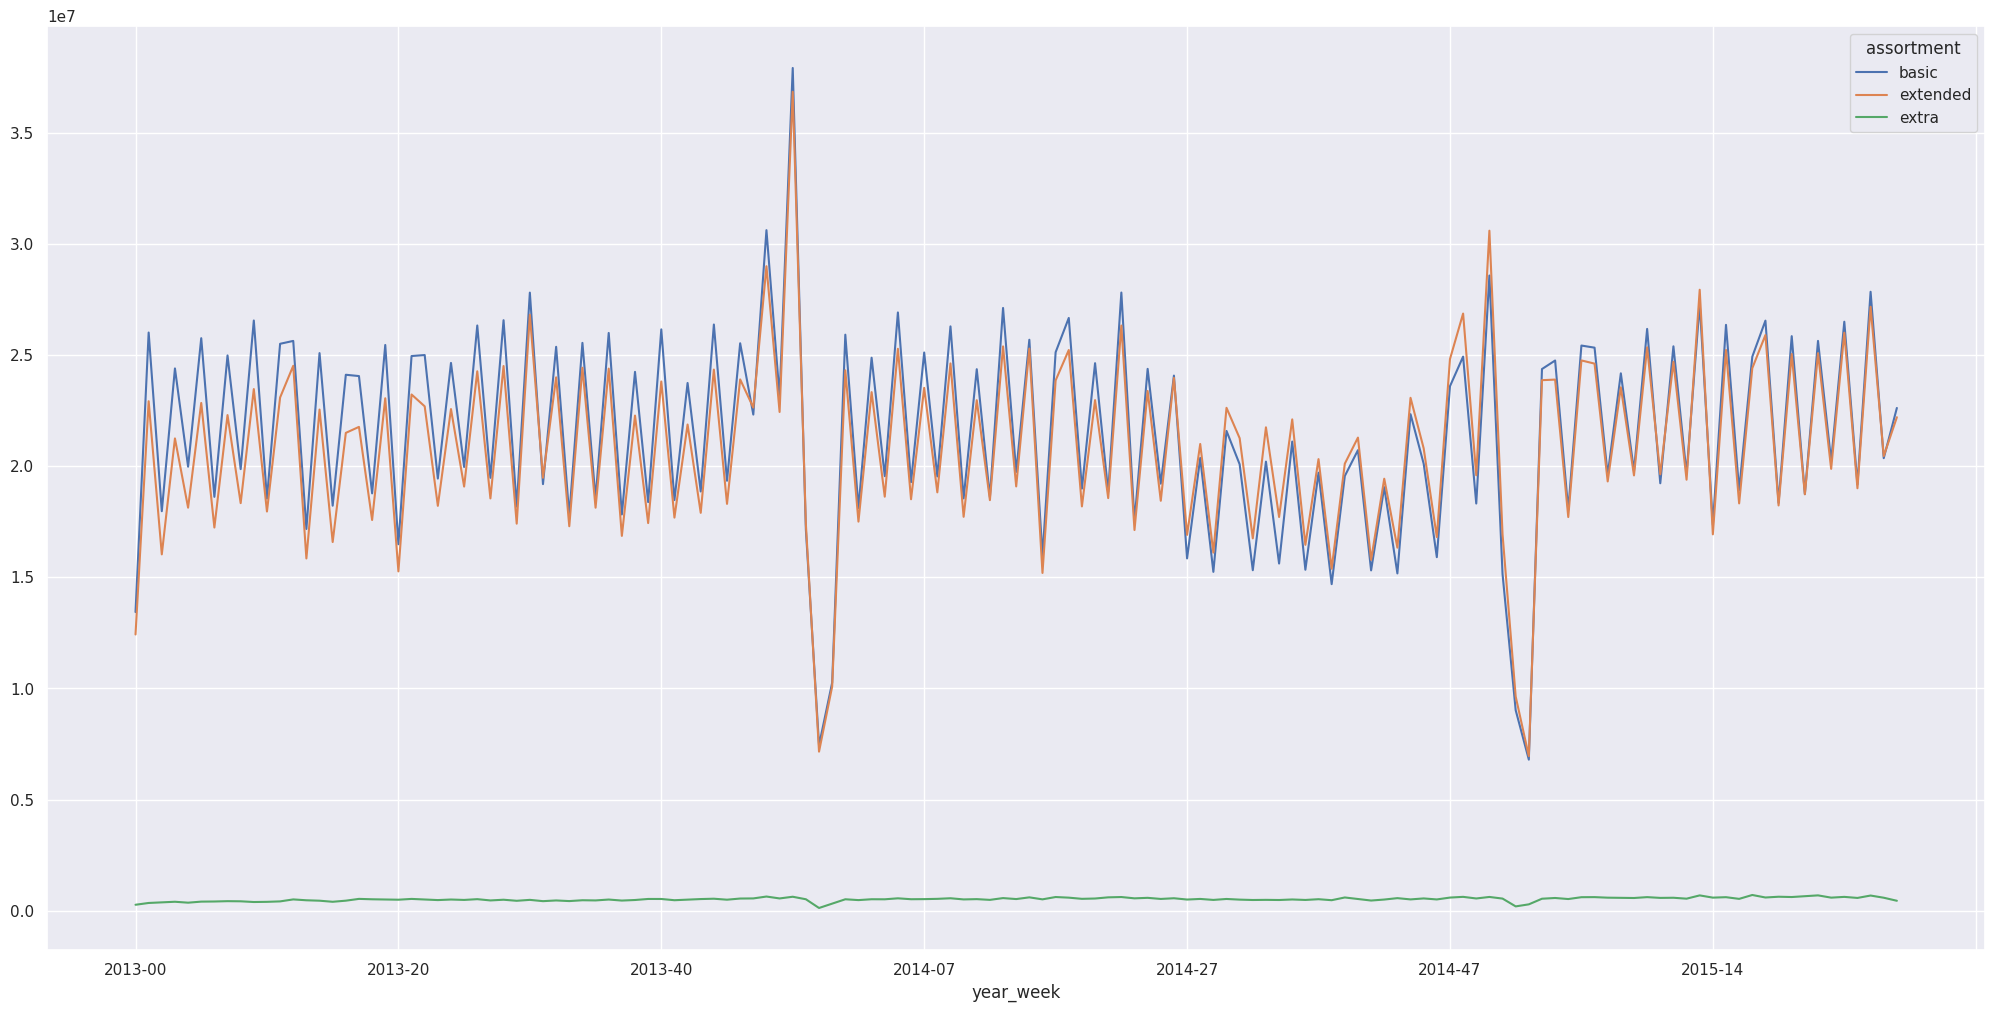

In [304]:
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

In [305]:
#o assortment extra sugere uma linha linear e horizontal

In [306]:
aux3=aux2[aux2['assortment']=='extra']

<Axes: xlabel='year_week'>

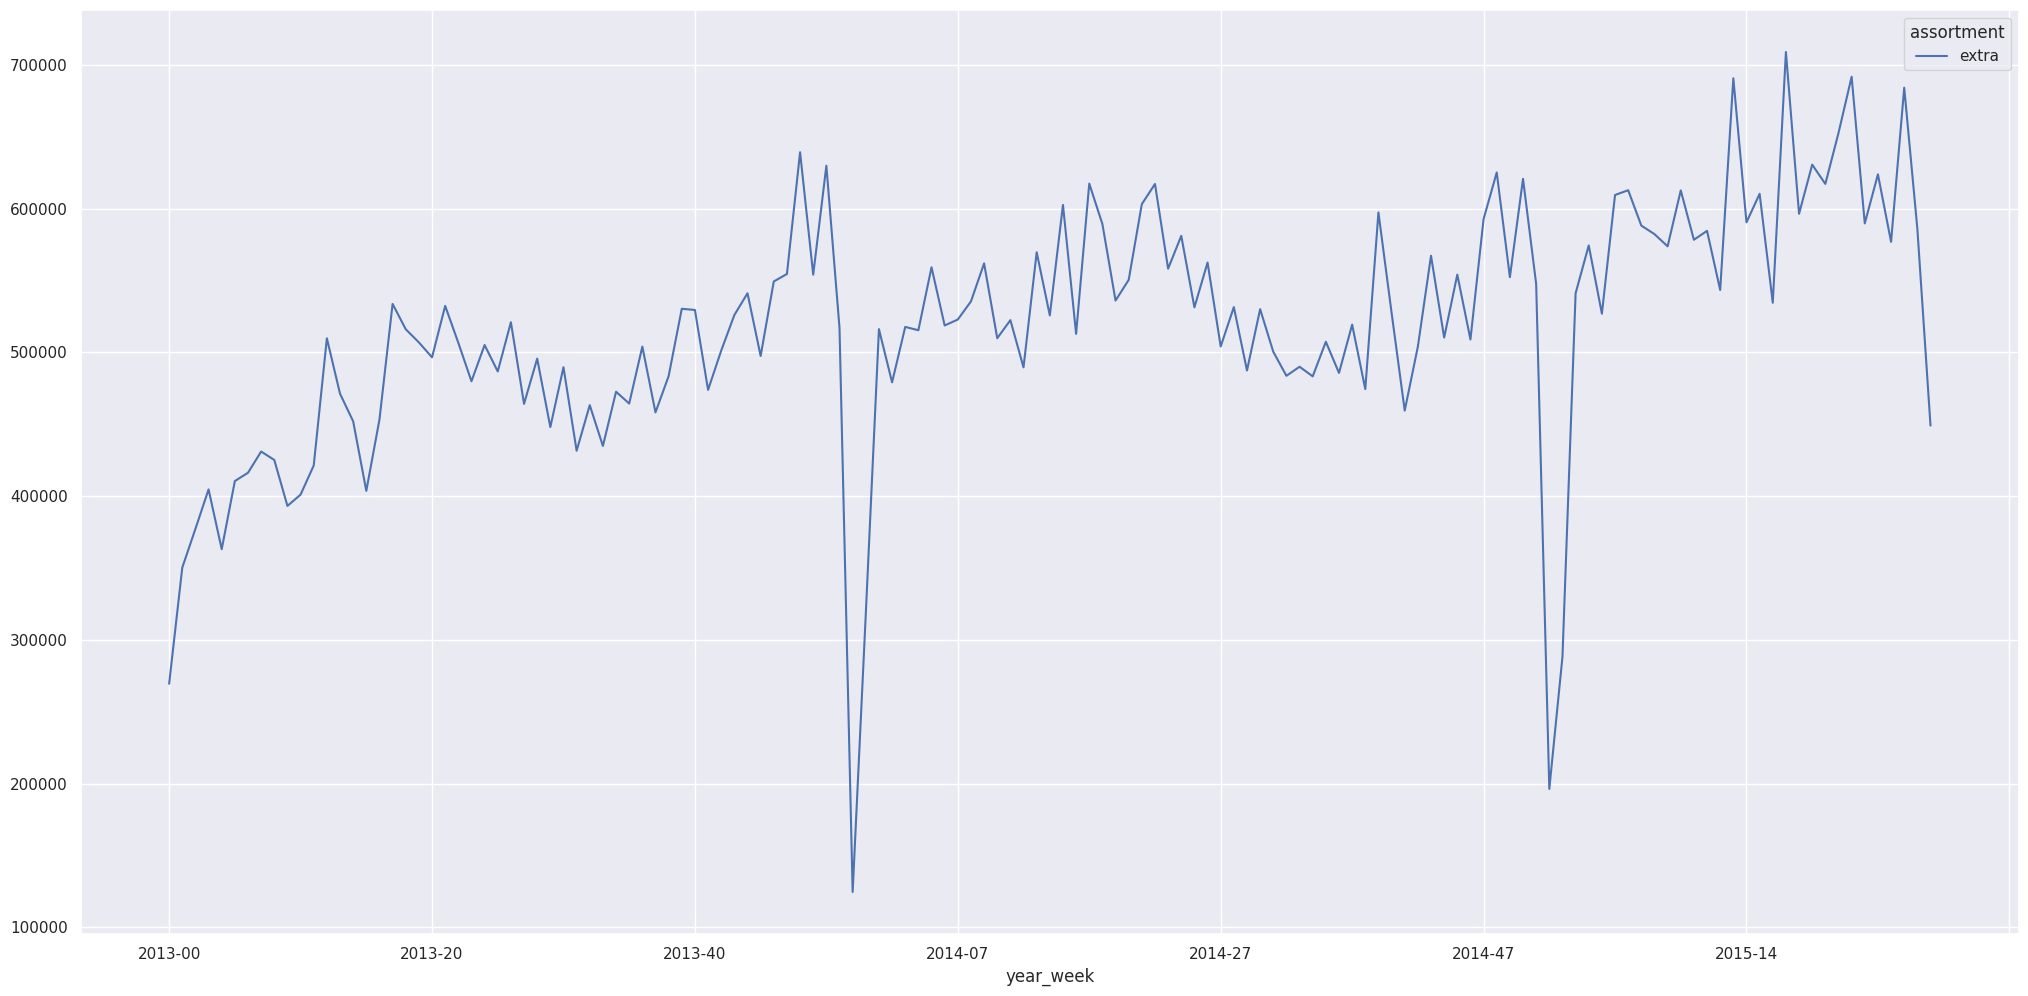

In [307]:

aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

2.2. Lista Final de Hipóteses
[0, 3.] Lojas com [0 / competidores à + tempo] deveriam vender +.

[2., ] Lojas com competidores + próximo deveriam vender - .

2.2. Lista Final de Hipóteses
[1., 3.] Lojas com [maior sortimento/ competidores à + tempo] deveriam vender +.





** Produtos **

[4., 5., 6.] Lojas [promoções activas por mais tempo, com + [dias de promoção, promoções consecutivas]] deveriam vender +

** Tempo **

7. Lojas abertas durante o feriado de Natal deveriam vender menos.

8. Lojas ao longo do ano deveriam vender mais.

9. Lojas no segundo semestre do ano deveriam vender mais.

10. Lojas depois do dia 10 de cada mes deveriam vender mais.

11. Lojas nos finais de semana deveriam vender menos.

12. Lojas nos Feriados escolares deveriam vender menos.

#### **H2. Lojas com competidores + próximos deveriam vender menos.**
#### **FALSA, Lojas com competidores + próximos deveriam vender mais.**


In [308]:
#### **2.2. Lista Final de Hipóteses**
#### **H1. Lojas com maior sortimento deveriam vender mais.**
#### **FALSA, lojas com MAIOR SORTIMENTO vendem MENOS**

In [309]:
df4.sample()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,id,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,year_week,competition_open_since,competition_time_month,promo_since,promo_time_week
42283,1029,3,2015-06-10,5733,0,regular_day,0,957831,a,basic,1590.0,3,2006,0,24,2015,0,2015,6,10,2015-23,2006-03-01,112,2015-06-08,0


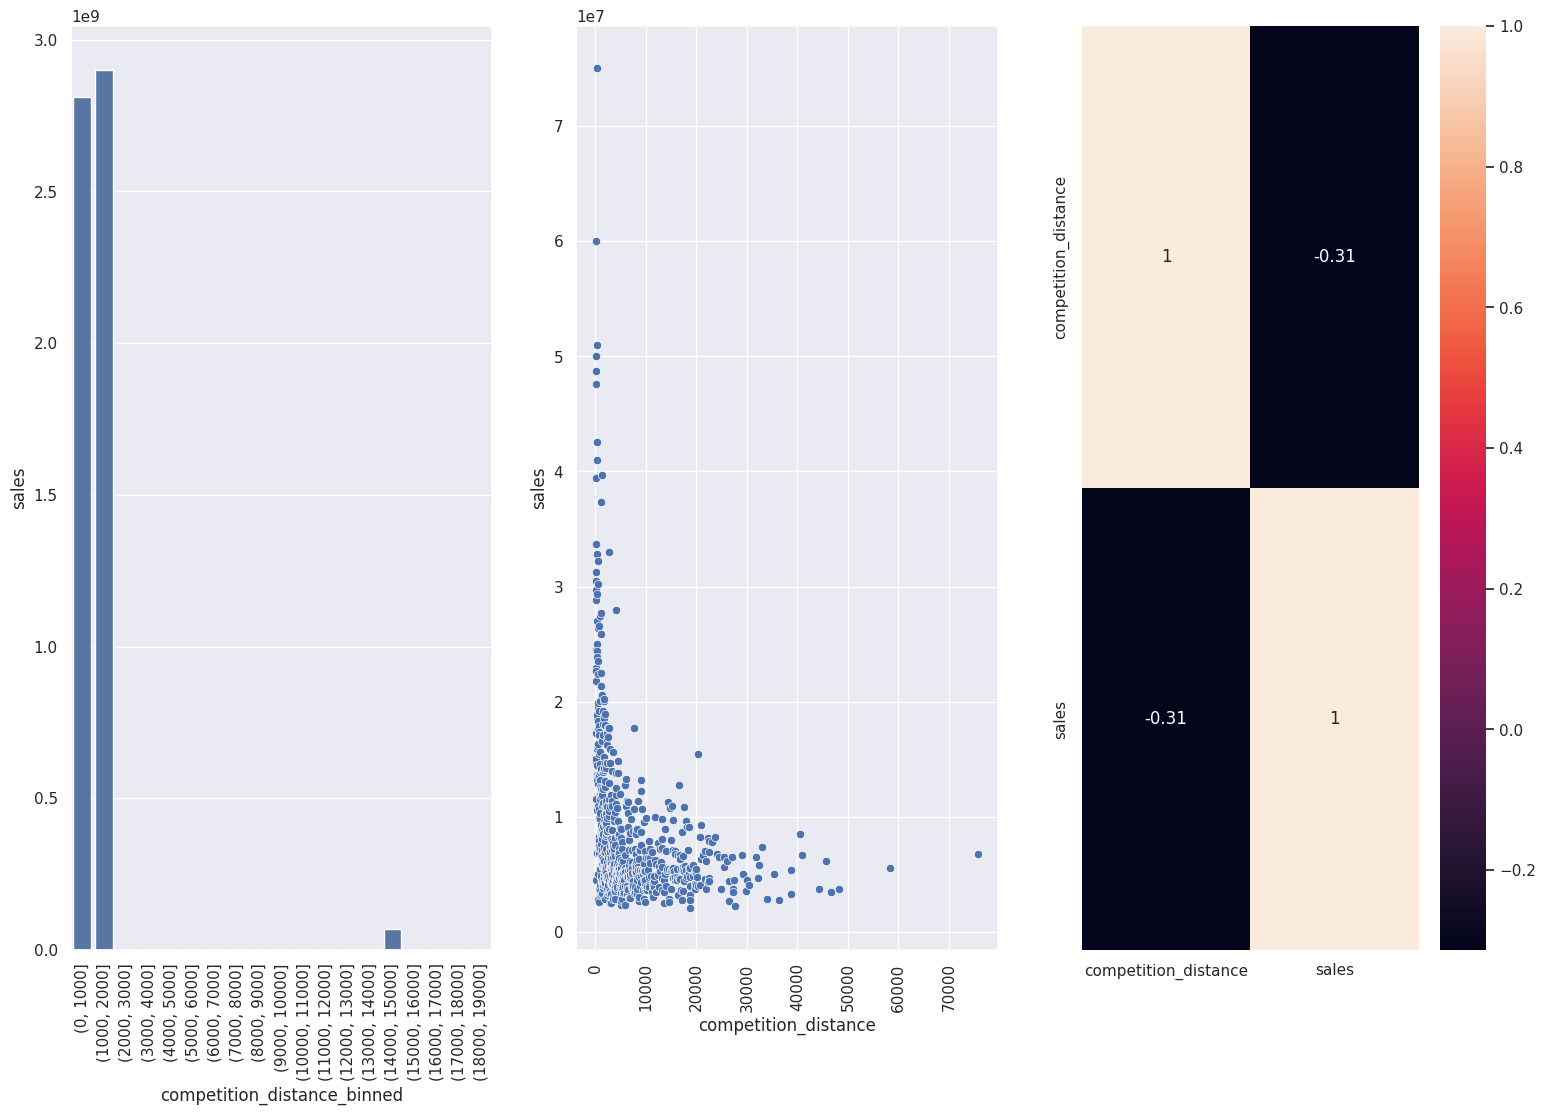

In [310]:
com_dis='competition_distance'
y = 'sales'

bins = list(np.arange(0, 20000, 1000))
com_dis_bin='competition_distance_binned'

aux1[com_dis_bin]=pd.cut(df4[com_dis], bins=bins)
aux2 = aux1[[com_dis_bin, y]].groupby(com_dis_bin).sum().reset_index()

aux3=df4[[com_dis,y]].groupby(com_dis).sum().reset_index()
plt.subplot(1,4,1)
sns.barplot(x=com_dis_bin, y=y, data=aux2); #como são as vendas por cada distância
plt.xticks(rotation=90)

plt.subplot(1,4,2)
sns.scatterplot(x=com_dis, y=y, data=aux3);
plt.xticks(rotation=90)

plt.subplot(1,4,3)
x = sns.heatmap(aux3.corr(method='pearson'), annot=True);
#bootom, top = x.get #AttributeError: 'Axes' object has no attribute 'get'
# medir a força de correlação

#### **H3. Lojas com competidores à + tempo deveriam vender +.**
#competition_open_since, competition_time_month, competition_open_since_month, competition_open_since_year
#### **False, lojas com COMPETIDORES à + tempo vendem MENOS

In [311]:
df4.sample()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,id,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,year_week,competition_open_since,competition_time_month,promo_since,promo_time_week
381784,239,6,2014-07-12,5296,0,regular_day,0,617598,d,extended,610.0,7,2014,0,28,2014,0,2014,7,12,2014-27,2014-07-01,0,2014-07-07,0


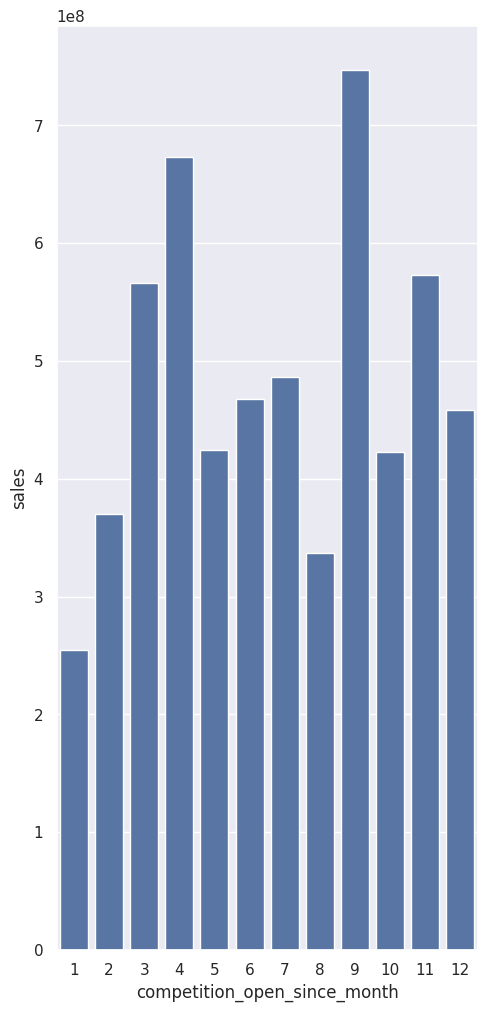

In [312]:
#competition_open_since_month
com_ope_sin_mon='competition_open_since_month'
y = 'sales'

#bins = list(np.arange(0, 20000, 1000))
#com_dis_bin='competition_distance_binned'
#aux1[com_dis_bin]=pd.cut(aux1[com_dis], bins=bins)
#aux2 = aux1[[com_dis_bin, y]].groupby(com_dis_bin).sum().reset_index()

aux3=df4[[com_ope_sin_mon,y]].groupby(com_ope_sin_mon).sum().reset_index()
plt.subplot(1,4,1)
sns.barplot(x=com_ope_sin_mon, y=y, data=aux3);
#plt.xticks(rotation=90)

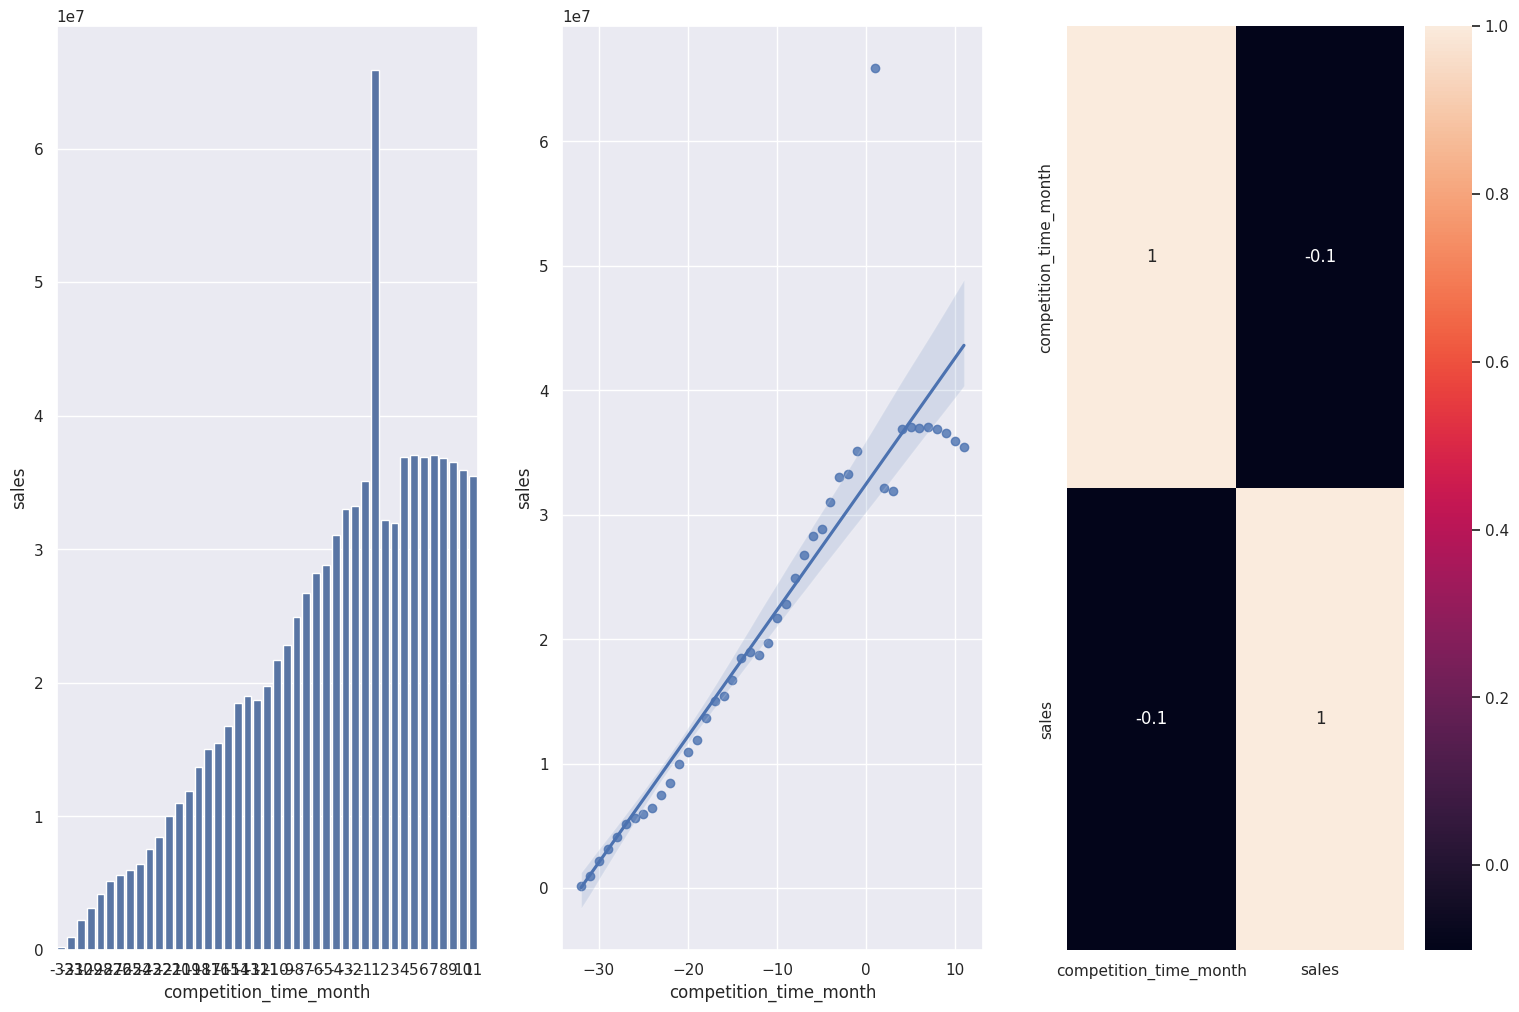

In [313]:
#competition_open_since_month
comp_tim_mon='competition_time_month'
y = 'sales'

#bins = list(np.arange(0, 20000, 1000))
#com_dis_bin='competition_distance_binned'
#aux1[com_dis_bin]=pd.cut(aux1[com_dis], bins=bins)
#aux2 = aux1[[com_dis_bin, y]].groupby(com_dis_bin).sum().reset_index()

aux1=df4[['competition_time_month',y]].groupby('competition_time_month').sum().reset_index()
plt.subplot(1,4,1)


#filtrando, todas as linhas e colunas, os primeiros 12 meses de competição e com tempo de competição diferente ao da realização da venda
aux2 = aux1[( aux1['competition_time_month']<12) & (aux1[comp_tim_mon]!=0)]
sns.barplot(x=comp_tim_mon, y=y, data=aux2);
#plt.xticks(rotation=60)

plt.subplot(1,4,2)
#exite alguma tendencia de crescimento?
sns.regplot(x=comp_tim_mon, y=y, data=aux2);

plt.subplot(1,4,3)
#sns.heatmap(x='competition_time_month', y=y, data=aux2);
#em termos de relevância para o modelo,
# é relevante pois tem uma correlação não tão próxima de zero
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);



In [314]:
#Quanto + recente forem as competições, a abertura das lojas do competidores, maior são as suas vendas.

#### **H4. Lojas com promoções activas por mais tempo, com + dias de promoção, deveriam vender + **
#### Falsa, lojas com promoções activas por mais tempo vendem menos, depois de um certo período de promoção
#### vende regularmente até um certo tempo, depois decai
#### validar a hipotese vs
#### a variável é relevante para o modelo ?

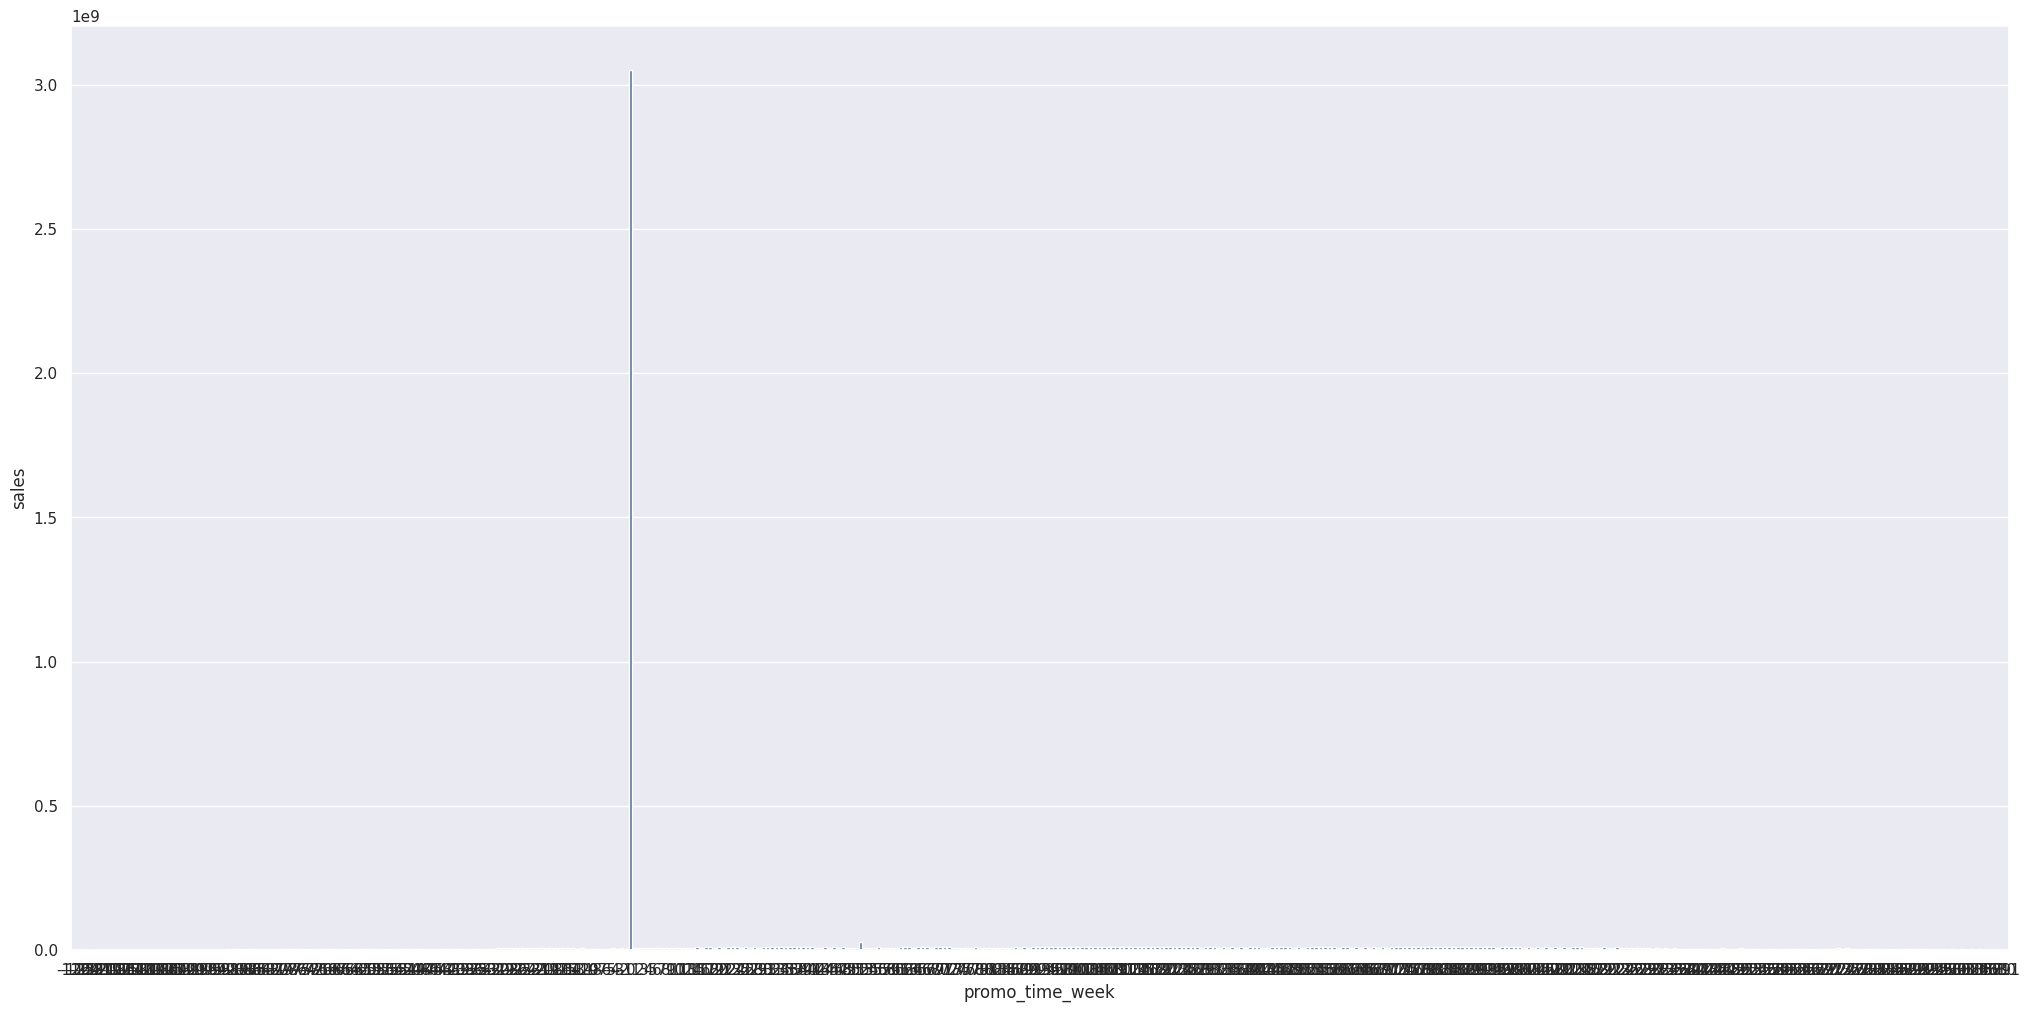

In [315]:
#### **H4. Lojas promoções activas por mais tempo, com + dias de promoção deveriam vender + o **
df4[['date','promo','is_promo','promo2', 'promo2_since_week','promo2_since_year', 'promo_since', 'promo_time_week']].sample(15)
#df4.sample()#.co
#['promo2', 'promo2_since_week',	'promo2_since_year', 'promo_since', 'promo_time_week']
aux1=df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot(x='promo_time_week', y='sales', data=aux1);
#promo_since	promo_time_week
#promo2	promo2_since_week	promo2_since_year

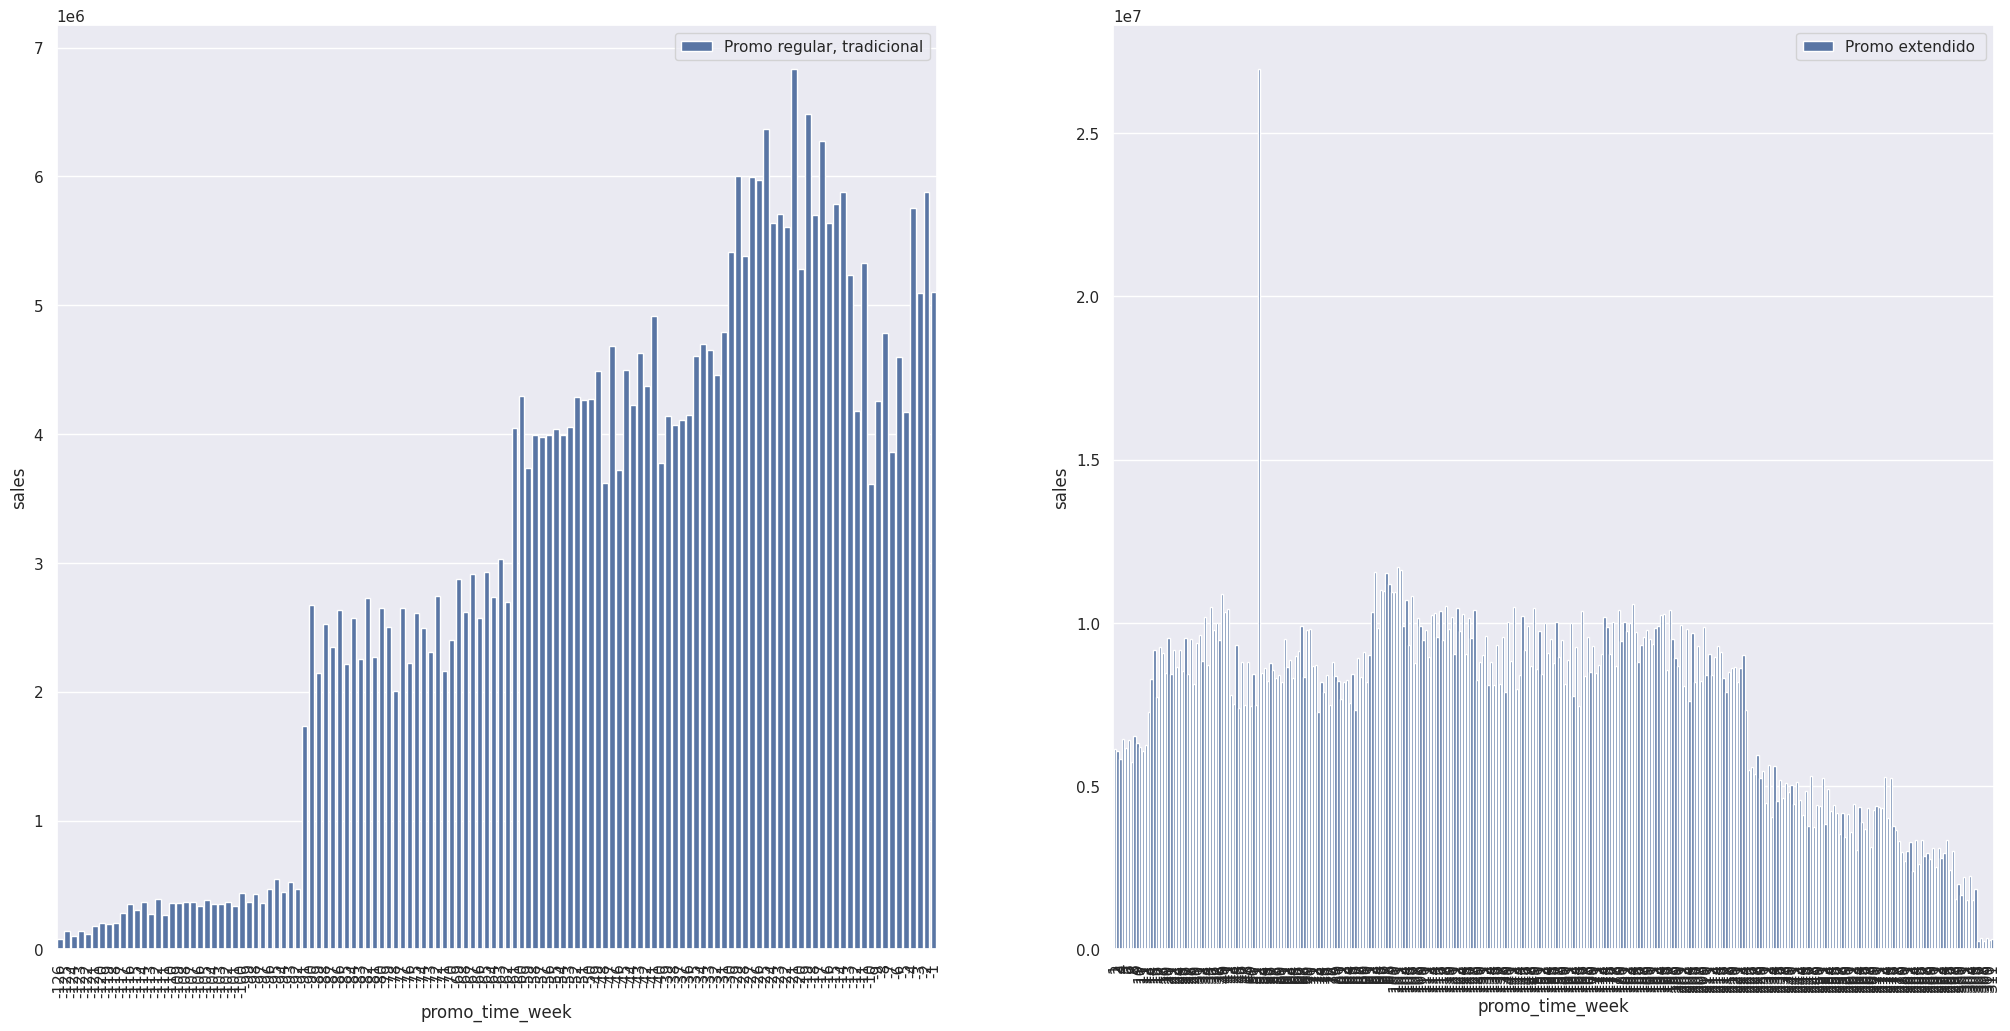

In [316]:
y='promo_time_week'
x='sales'
aux2=aux1[aux1['promo_time_week']>0] # Promo extendido
aux3=aux1[aux1['promo_time_week']<0] # Promo regular, tradicional

#plt.subplot(1,2,1)
#sns.barplot(x='promo_time_week', y='sales', data=aux2, label='Promo extendido ');
#plt.xticks(rotation=90);

plt.subplot(1,2,1)
sns.barplot(x='promo_time_week', y='sales', data=aux3, label='Promo regular, tradicional');
#plt.subplot(1,2,1)
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.barplot(x='promo_time_week', y='sales', data=aux2, label='Promo extendido ');
plt.xticks(rotation=90);


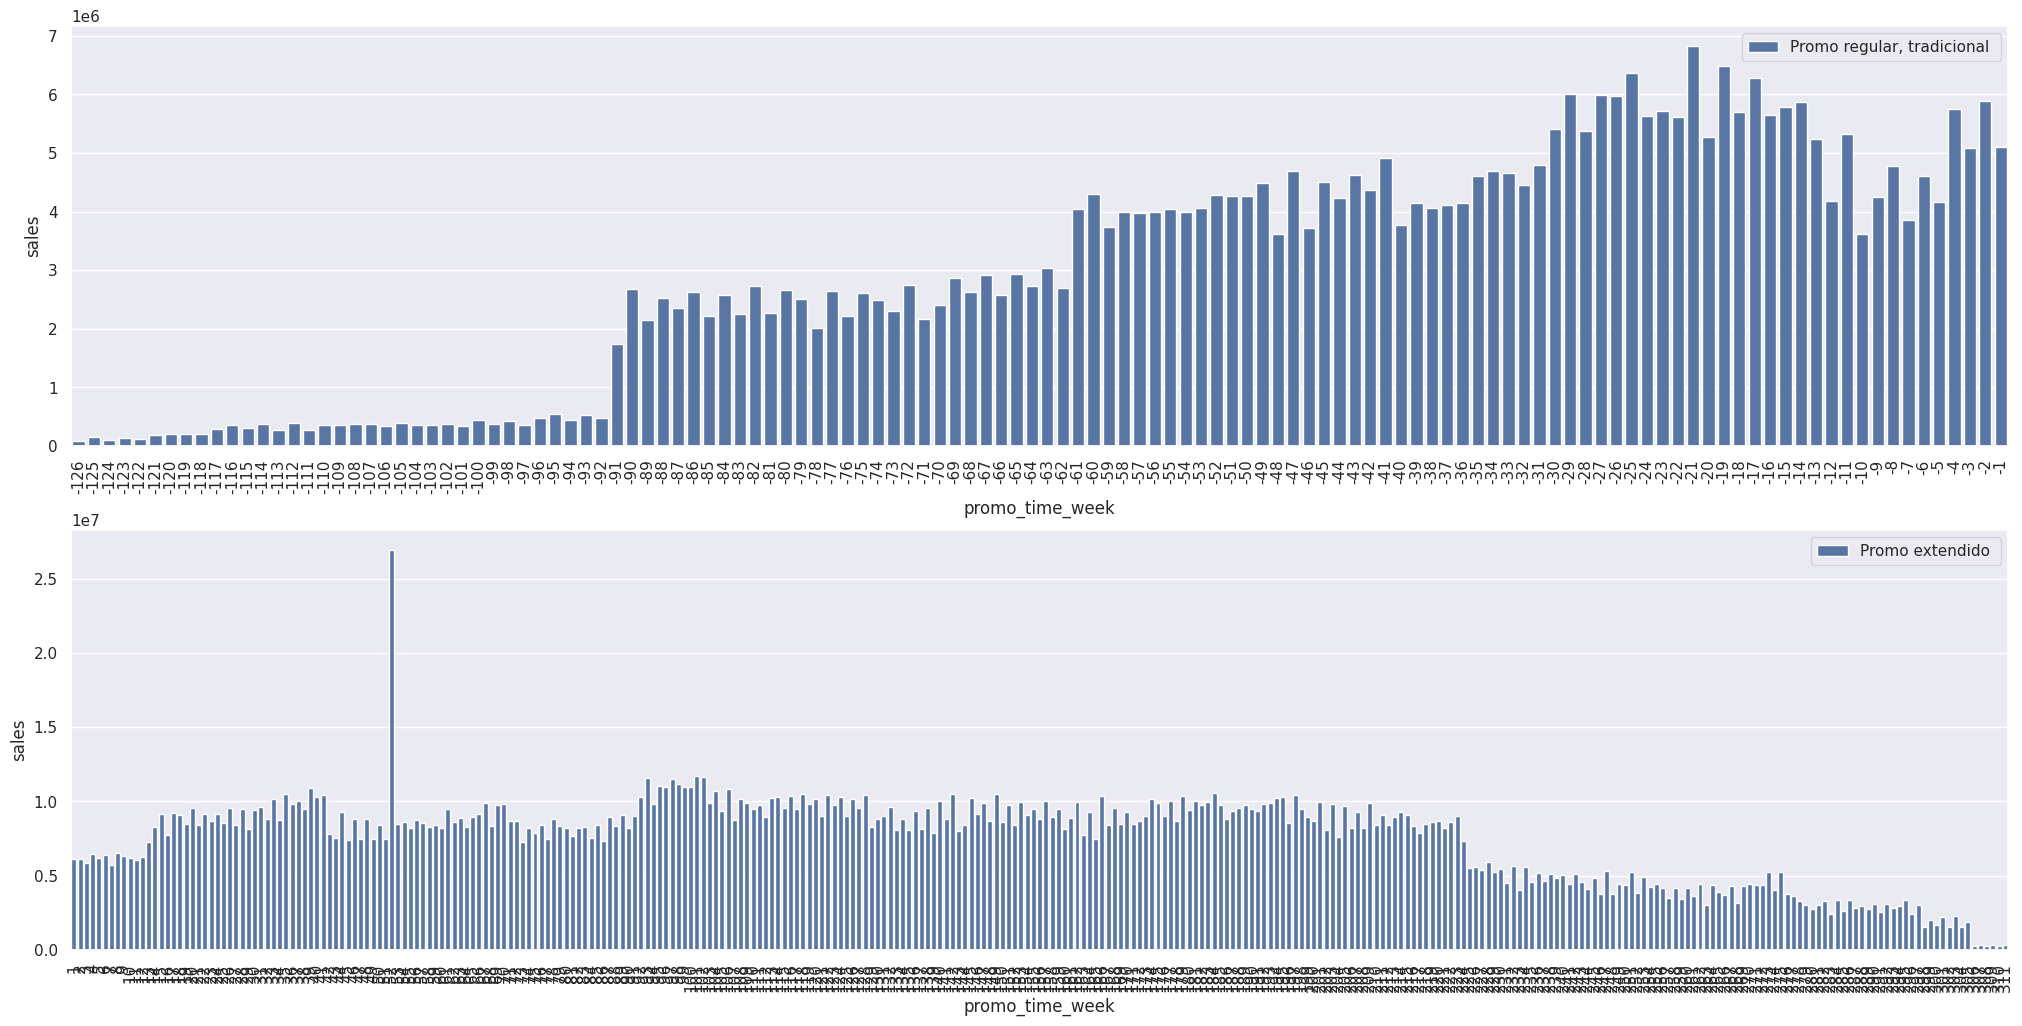

In [317]:
plt.subplot(2,1,2)
sns.barplot(x='promo_time_week', y='sales', data=aux2, label='Promo extendido ');
plt.xticks(rotation=90);

plt.subplot(2,1,1)
sns.barplot(x='promo_time_week', y='sales', data=aux3, label='Promo regular, tradicional ');
#plt.subplot(1,2,1)
plt.xticks(rotation=90);

#plt.subplot(1,2,2)
#sns.barplot(x='promo_time_week', y='sales', data=aux2, label='Promo extendido ');
#plt.xticks(rotation=90);


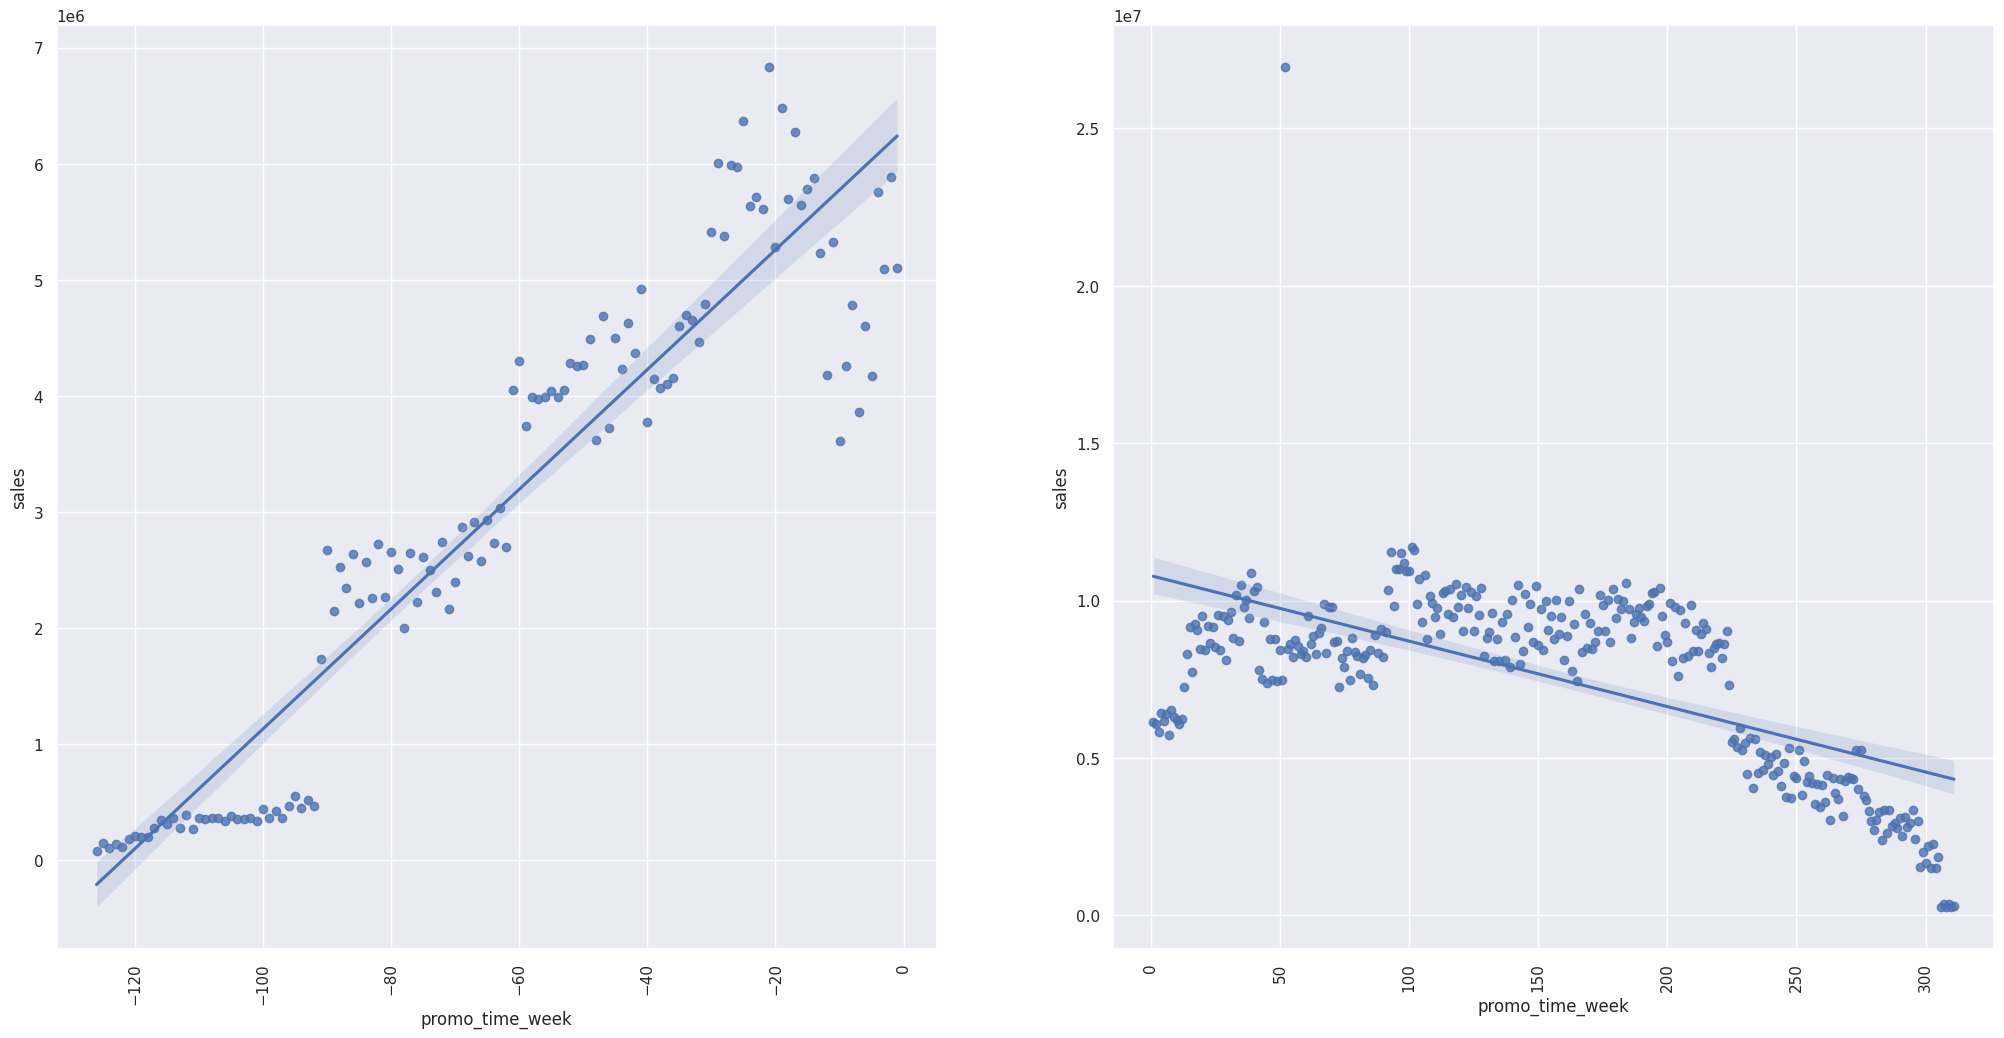

In [318]:
# os gráficos acima sugerem uma tendência
#verificando se realmente existe alguma tendência nos gráficos
plt.subplot(1,2,1)
sns.regplot(x='promo_time_week', y='sales', data=aux3, label='Promo regular, tradicional');
#plt.subplot(1,2,1)
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.regplot(x='promo_time_week', y='sales', data=aux2, label='Promo extendido ');
plt.xticks(rotation=90);


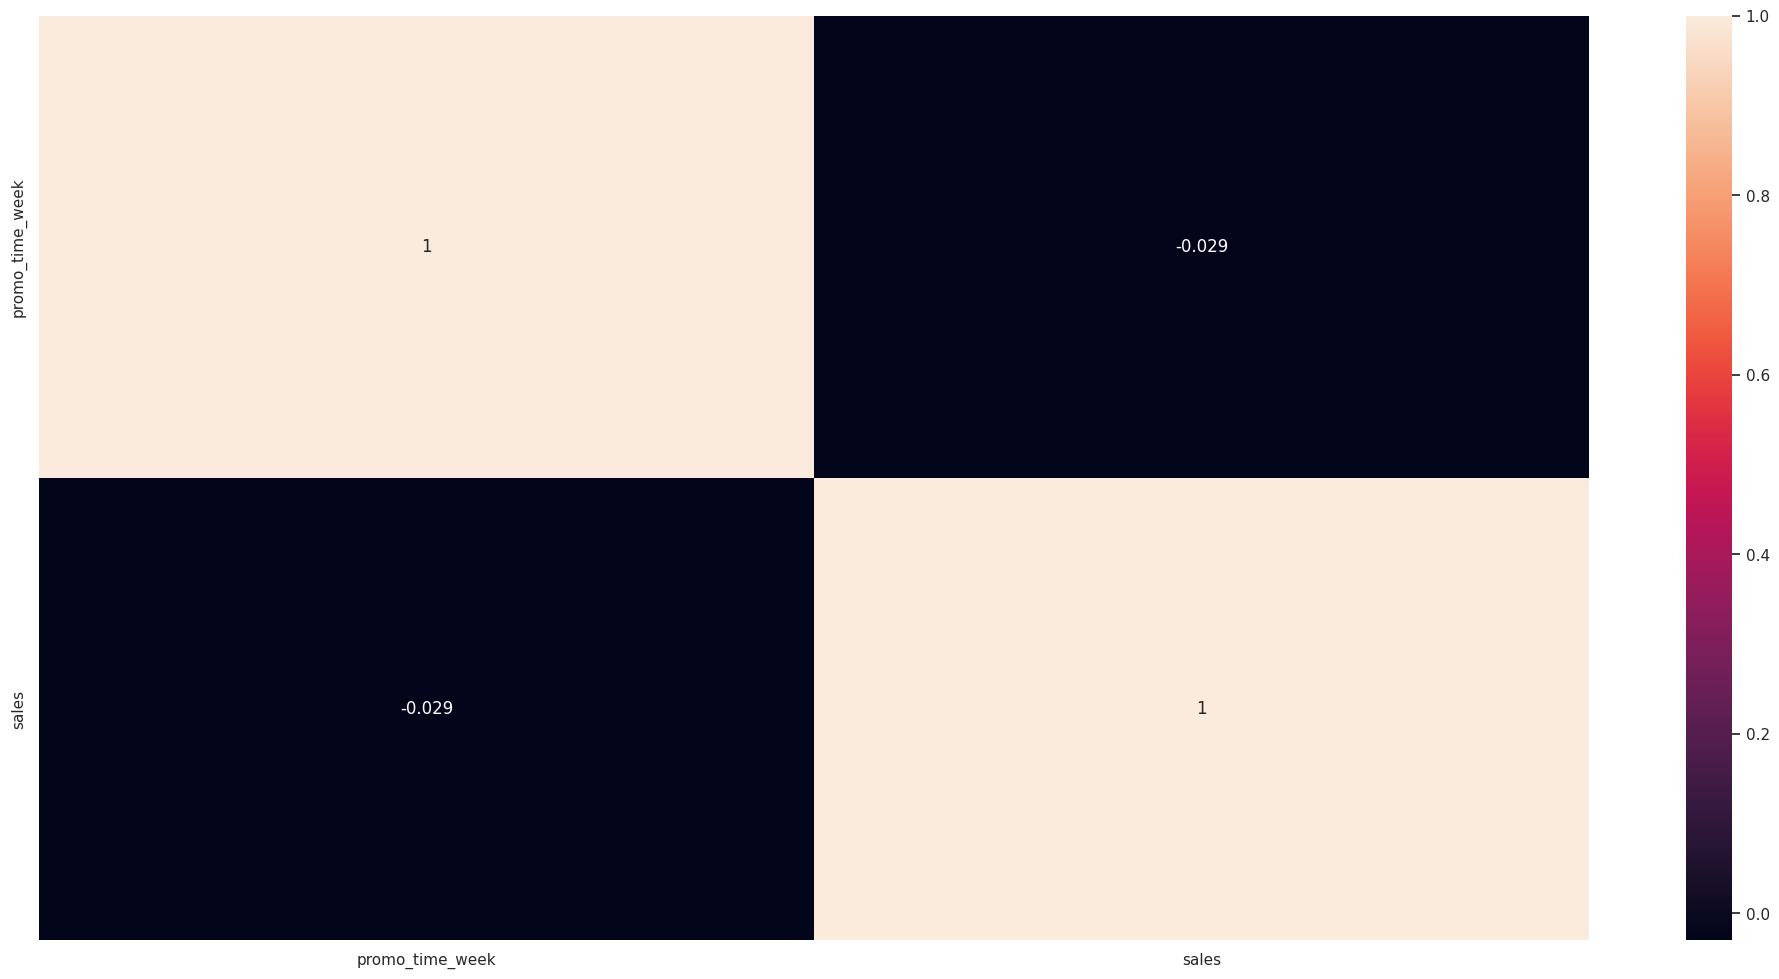

In [319]:
# Procurando encontrar a força do comportamento da correlação, usado o método corr, obedecendo a formula de pearson 19:31,
sns.heatmap(aux1.corr( method='pearson'), annot=True);
# correlação de 0.029 é uma correlação muito fraca

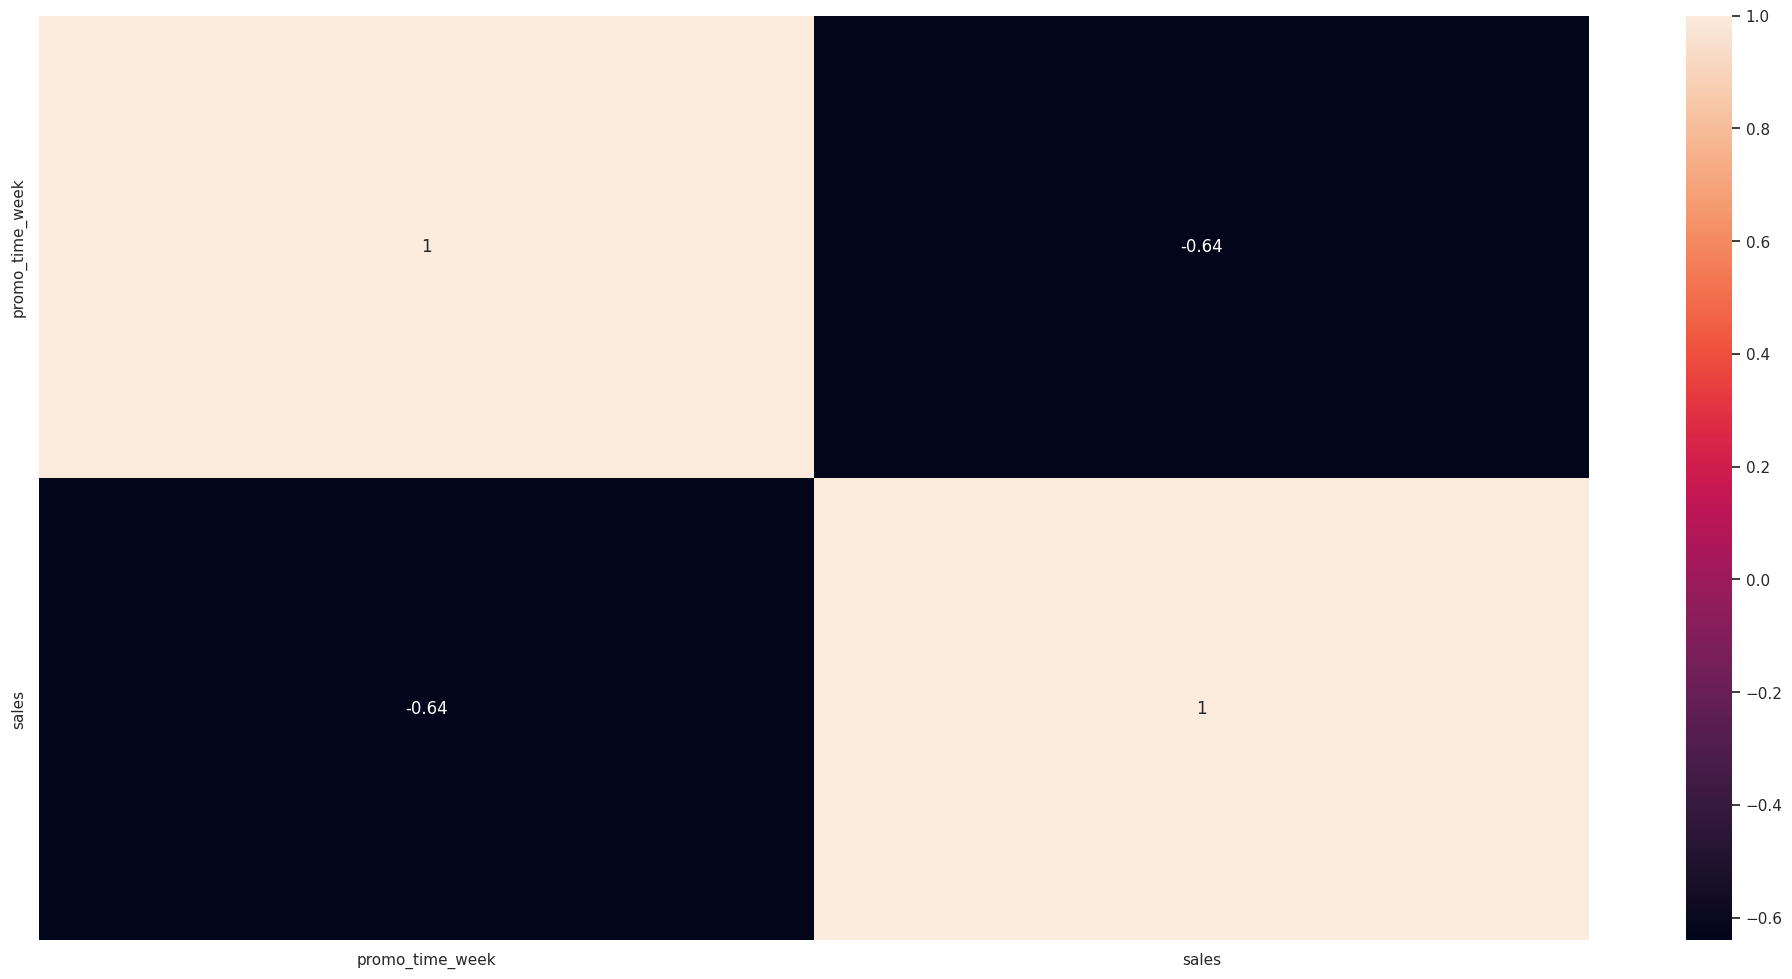

In [320]:
# Procurando encontrar a força do comportamento da correlação, usado o método corr, obedecendo a formula de pearson 19:31,
sns.heatmap(aux2.corr( method='pearson'), annot=True);
# correlação de 0.029 é uma correlação negativa e forte

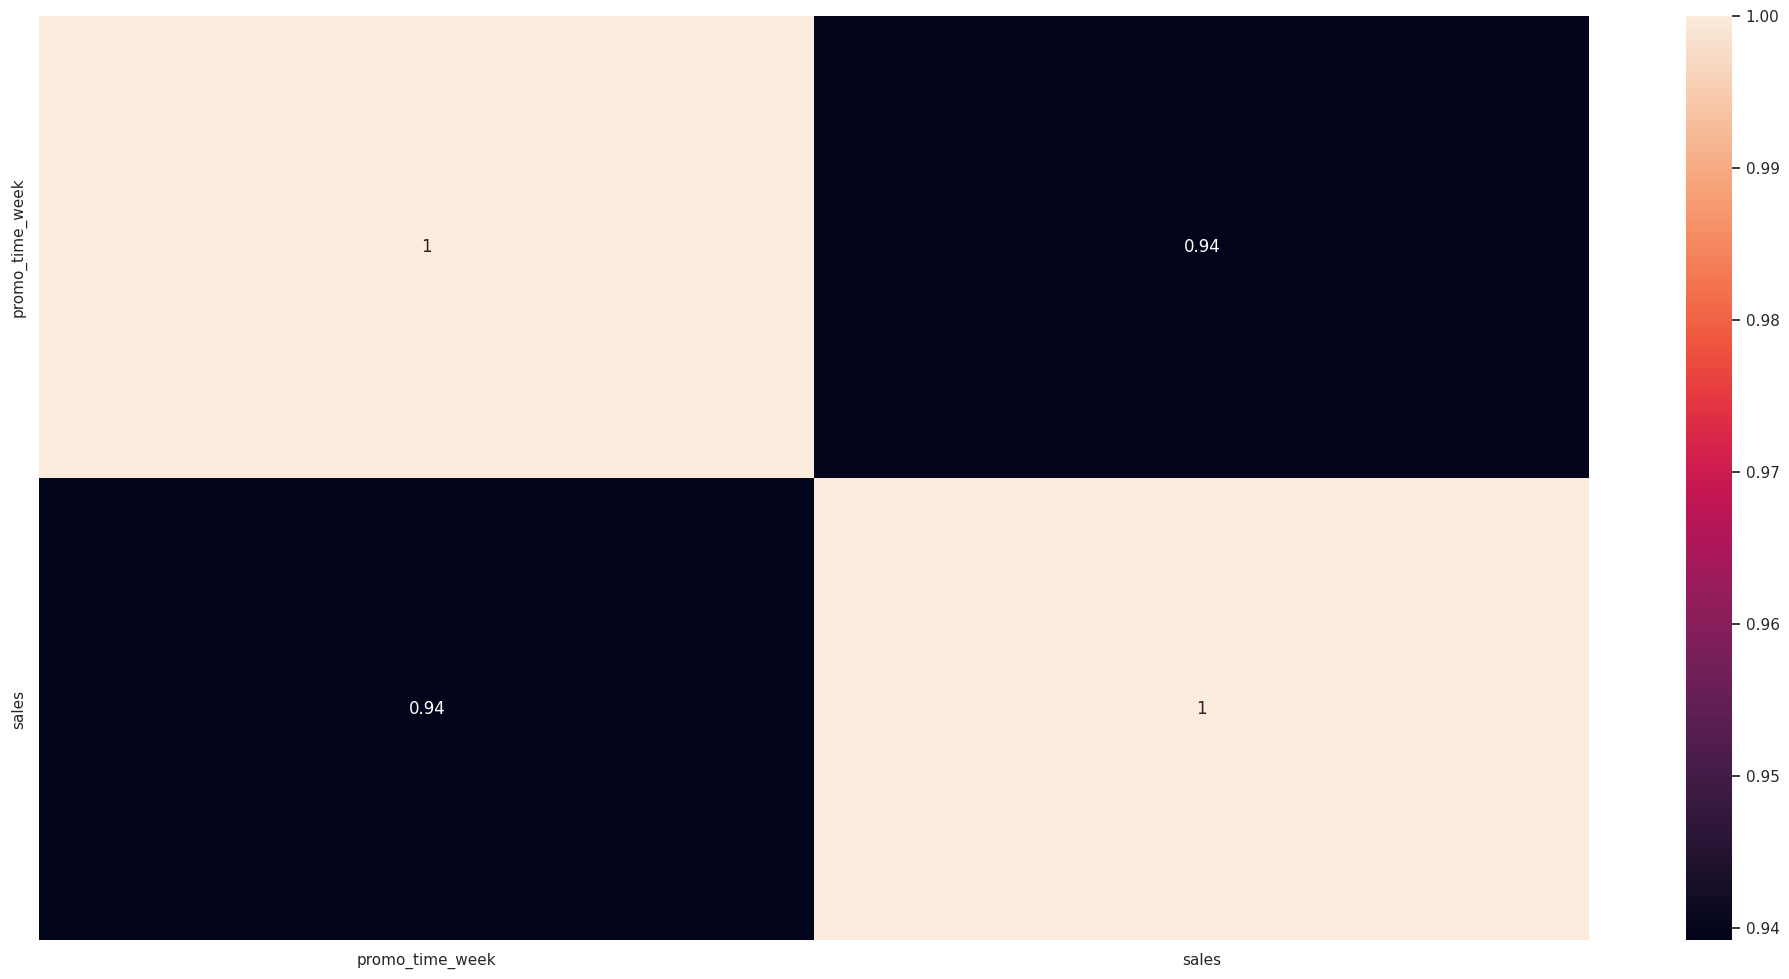

In [321]:
# Procurando encontrar a força da correlação, usado o método corr, obedecendo a formula de pearson 19:31,
sns.heatmap(aux3.corr( method='pearson'), annot=True);
# correlação de 0.94 é uma correlação positiva e muito forte

In [322]:
#import matplotlib.gridspec # as gridspec
from  matplotlib.gridspec import GridSpec # as gridspec, ModuleNotFoundError: No module named 'matplotlib.gridspec.GridSpec'; 'matplotlib.gridspec' is not a package

<Axes: >

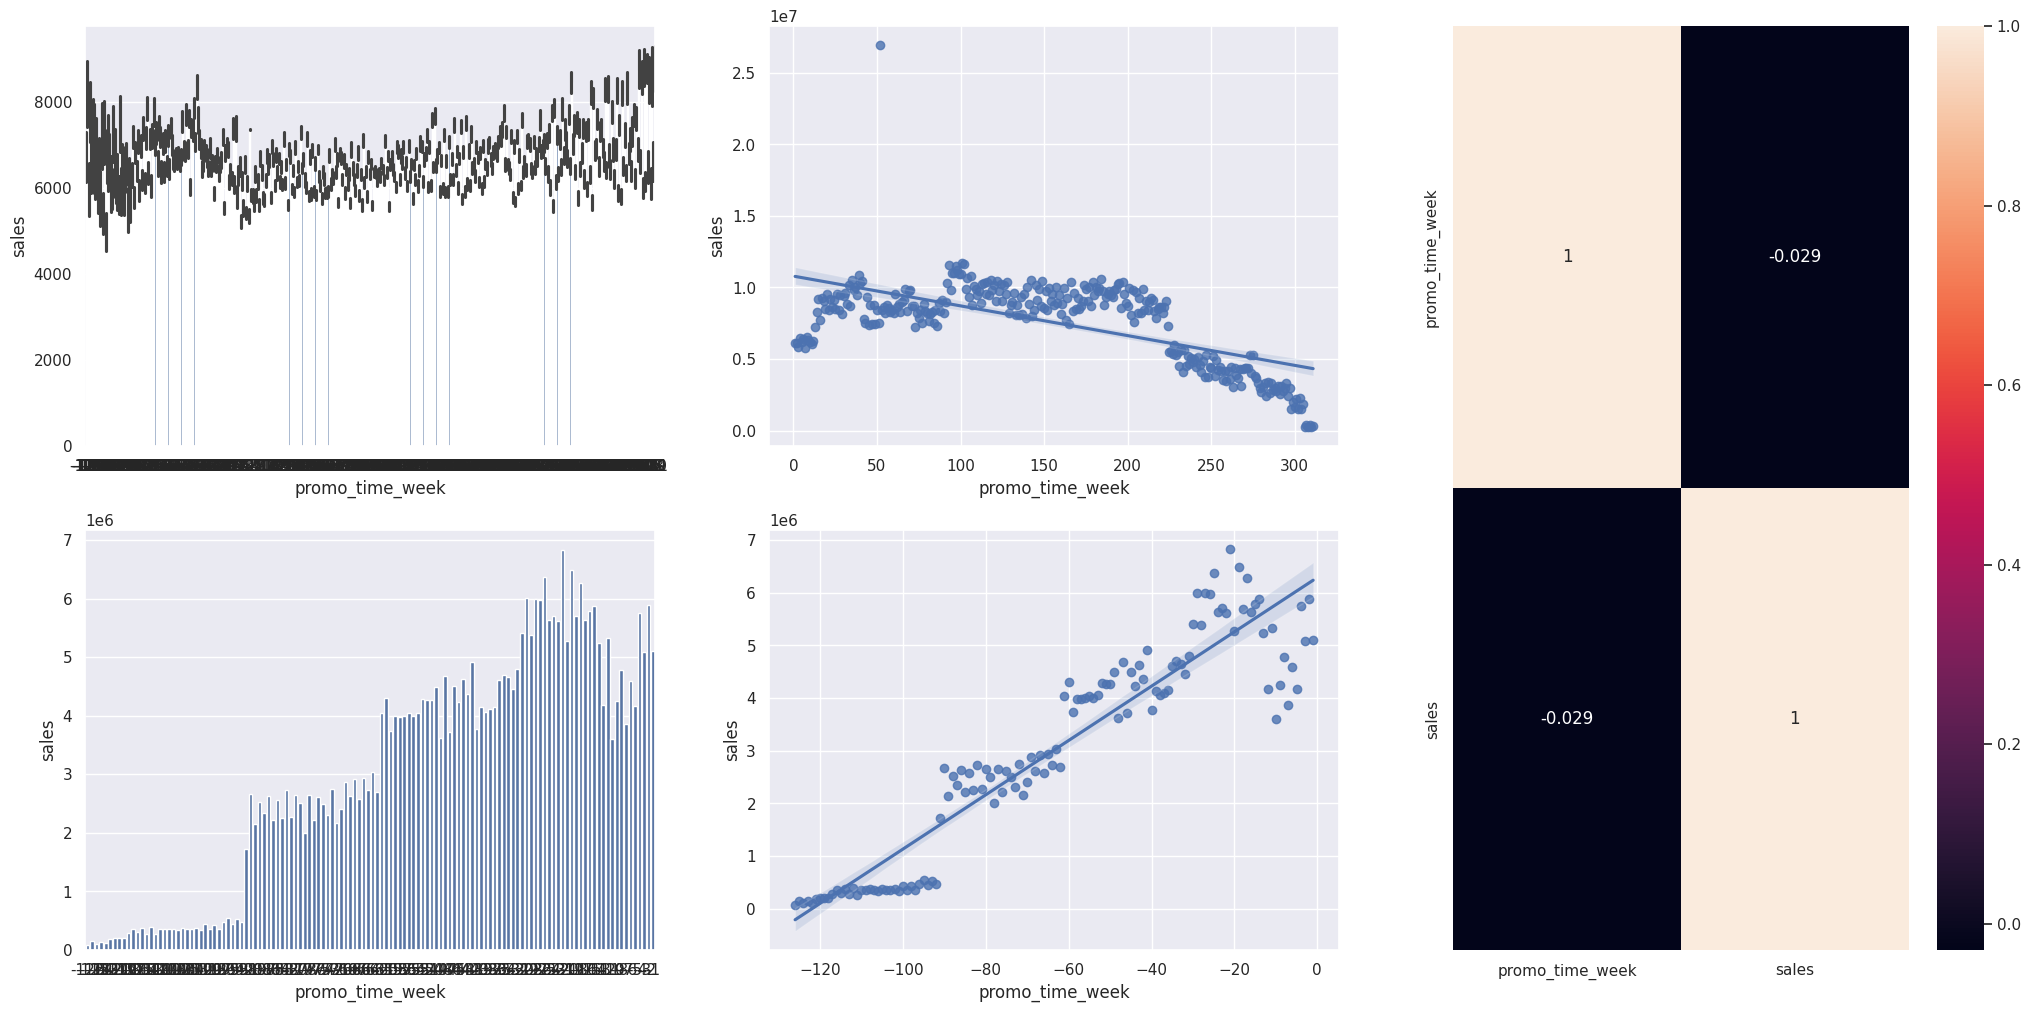

In [323]:
# grid=gridspec.GridSpec(2,3) #2 linhas e 3 colunas
grid=GridSpec(2,3) #2 linhas e 3 colunas

plt.subplot(grid[0,0])
# aux2=

x='promo_time_week'
y='sales'

# ValueError: Could not interpret value `promo_time_week` for `x`. An entry with this name does not appear in `data`.
# aux1.sample()
sns.barplot(x=x, y=y, data=df4);
#plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(x=x, y=y, data=aux2);

plt.subplot(grid[1,0])
sns.barplot(x=x, y=y, data=aux3);

plt.subplot(grid[1,1])
sns.regplot(x=x, y=y, data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

In [324]:
#aux3

#### ** <s> H5. Lojas com + dias de promoção, deveriam vender + #### ** Tempo **  </s>
#### ** H4. Lojas com promoções activas por mais tempo, com + dias de promoção, deveriam vender + **
#### Falsa, lojas com promoções activas por mais tempo vendem menos, depois de um certo período de promoção
#### vende regularmente até um certo tempo, depois decai
#### validar a hipotese vs

In [325]:
df4.sample(5)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,id,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,year_week,competition_open_since,competition_time_month,promo_since,promo_time_week
992007,443,3,2013-01-09,6026,1,regular_day,0,902681,d,basic,11400.0,12,2005,0,2,2013,0,2013,1,9,2013-01,2005-12-01,86,2013-01-07,0
396389,235,5,2014-06-27,5373,0,regular_day,0,422538,a,basic,5710.0,3,2012,1,37,2009,0,2014,6,27,2014-25,2012-03-01,28,2009-09-07,250
110836,452,4,2015-04-09,3822,0,regular_day,1,1013331,a,extended,1850.0,8,2013,1,5,2011,0,2015,4,9,2015-14,2013-08-01,20,2011-01-24,219
240206,881,4,2014-12-11,3732,0,regular_day,0,772167,a,basic,180.0,3,2008,1,31,2013,0,2014,12,11,2014-49,2008-03-01,82,2013-07-29,71
436483,189,4,2014-05-22,9129,1,regular_day,0,923255,d,basic,5760.0,7,2014,0,21,2014,0,2014,5,22,2014-20,2014-07-01,-2,2014-05-19,0


#### **H6. Lojas com + dias de promoções consecutivas deveriam vender +
#### ** FALSA ** , Lojas com + promoções consecutivas vendem menos

In [326]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index().sort_values(by=['sales'], ascending=True) #df.sort_values(by=['Column_name'], ascending=True)

,promo,promo2,sales
1,0,1,1267204512
3,1,1,1448760600
0,0,0,1458620310
2,1,0,1605214763


In [327]:
# a diferença existente entre as 4 vendas é significativa ?

In [328]:
#será que ao longo do tempo, o comportamento das vendas mudou tendo activado as duas promoções, a regular e a tradicional?
df4[((df4['promo']==1) & (df4['promo2']==1))]

In [ ]:
aux1=df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']]
aux1.plot()

In [ ]:
#agrupar, somar e fazer o reset_index
aux2=df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot()

In [ ]:
aux3=df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
#ax = aux3.plot()
aux4=df4[( df4['promo'] == 0 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux5=df4[( df4['promo'] == 0 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux3.plot()
aux2.plot(ax=ax)
aux4.plot(ax=ax)
aux5.plot(ax=ax)
ax.legend(labels=("Tradicional & Extraordinario","Tradicional","Sem promoção","Extraordinario"))

#### ** H7. Lojas abertas durante o feriado de natal deveriam vender menos. **
#### ** ** Verdade, Lojas abertas durante o feriado de natal vendem menos,
#### quanto a relevância,
#### mostra-se relevante dado o crescimento considerável de vendas para cada 1 dos feriados

In [ ]:
march_dates = (
        df4['date'].dt.month.eq(12) &
        df4['date'].dt.day.between(25, 31)
)
april_dates = (
        df4['date'].dt.month.eq(4) &
        df4['date'].dt.day.between(1, 25)
)
m = march_dates #| april_dates

filtered_df = df4[m][['date','sales']]#.groupby('date').sum().reset_index()
filtered_df.plot(y='sales',x='date')

In [ ]:
march_dates = (
        df4['date'].dt.month.eq(12) &
        df4['date'].dt.day.between(25, 31)
)
april_dates = (
        df4['date'].dt.month.eq(4) &
        df4['date'].dt.day.between(1, 25)
)
m = march_dates #| april_dates

filtered_df = df4[m][['date','sales']]#.groupby('date').sum().reset_index()
filtered_df.plot(y='sales',x='date')


In [ ]:
#df4[df4['state_holiday']!='regular_day'][['date','sales','state_holiday','school_holiday']].groupby('state_holiday').sum().reset_index()#.sample(5)
#aux=df4[df4['state_holiday']!='regular_day'][['sales','state_holiday']].groupby('state_holiday').sum().reset_index()#.sample(5)
#aux.plot(y='sales',x='state_holiday')
#sns.catplot(kind="bar", x='state_holiday',y='sales', data=aux)
#
#cols=pd.unique(df4['state_holiday'])
aux2=df4[df4['state_holiday']!='regular_day'][['sales','state_holiday','year']].groupby('year').sum().reset_index()#.sample(5)
#g =
#sns.catplot(kind="bar", x='year',y='sales', data=aux2, hue='state_holiday', alpha=.4, height=4) #label=cols )#'state_holiday')

#RuntimeError: In draw_glyphs_to_bitmap: Could not convert glyph to bitmap (raster overflow; error code 0x62

#g.fig.set_figheight(3.5)
#g.fig.set_figwidth(3)AU

#g.despine(left=True)

In [ ]:
aux3=df4[df4['state_holiday']!='regular_day'][['sales','state_holiday','year']].groupby(['state_holiday', 'year']).sum().reset_index()#.sample(5)

In [ ]:
aux3

In [ ]:
aux2

In [ ]:
#ValueError: Could not interpret value `year` for `x`. An entry with this name does not appear in `data`.
aux2.sample()

In [ ]:
plt.subplot(2,1,1)
#hue=
#sns.catplot(kind="bar", x='year',y='sales', data=aux2) #, alpha=.4, height=4) #label=cols )#'state_holiday')
#sns.catplot(kind="bar", x='year',y='sales', data=aux2) #, alpha=.4, height=4) #label=cols )#'state_holiday')
#sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2, alpha=0.7)

#ValueError: Could not interpret value `year` for `x`. An entry with this name does not appear in `data`.
#year_week	sales
#sns.barplot(x='year', y='sales', data=aux2, alpha=0.7)
sns.barplot(x='year_week', y='sales', data=aux2, alpha=0.7)
#ValueError: Could not interpret value `year` for `hue`. An entry with this name does not appear in `data`.
plt.show()
plt.subplot(2,1,2)
#hue=
#sns.catplot(kind="bar", x='state_holiday',y='sales', data=aux3) #, alpha=.4, height=4) #label=cols )#'state_holiday')
sns.barplot(x='state_holiday', y='sales', hue='year', data=aux3, alpha=0.7)

#?? todo: to see sns.catplot vs sns.barplot
#barplot
#Show point estimates and confidence intervals using bars.
#catplot
#Combine a categorical plot with a FacetGrid.

#?? todo: aux4:count, quantos feriados públicos temos/ano
plt.show()


#### ** H8. Lojas ao longo do ano deveriam vender +
#### ** ** Falsa, as lojas ao longo do ano vendem -
#### Quanto a relevância,
#### a variável ano é ou não relevante para o modelo
#### existe uma variação acentuada das vendas ao longo dos anos?
#### o ano de 2015 tem vendas de meses em falta
#### o ano tem 12 meses contudo o 2015 tem vendas em apenas x meses
#### que tal montar uma serie que identifica o data e consider as vendas e fazer uma previsão para os meses #### em falta, fazer as análises considerando os períodos idénticos


In [ ]:
#as vendas do ano 2015 terminam em Agosto, pode ser a causa de baixa venda comparando com os restantes anos

In [ ]:
#KeyError: 'year'
#aux1=promo&promo2
aux1=df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year', 'sales']]
aux1.sample()

In [ ]:
Falta o primeiro grafico

In [ ]:
aux2.sample()

In [ ]:
#KeyError: 'promo_time_week'
aux2.sample()
# de
# year_week	sales
# para
# year	sales	state_holiday

In [ ]:
# grid=gridspec.GridSpec(2,3) #2 linhas e 3 colunas
grid=GridSpec(2,3) #2 linhas e 3 colunas

plt.subplot(grid[0,0])
# aux2=

x='promo_time_week'
y='sales'

# ValueError: Could not interpret value `promo_time_week` for `x`. An entry with this name does not appear in `data`.
# aux1.sample()
##KeyError: 'year'
sns.barplot(x=x, y=y, data=df4);
#plt.xticks(rotation=90)

#plt.subplot(1,3,1)
#aux2=df4[df4['state_holiday']!='regular_day'][['sales','state_holiday','year']].groupby('year').sum().reset_index()#.sample(5)
#g =
#sns.catplot(kind="bar", x='year',y='sales', data=df4) #aux2, )#hue='state_holiday', alpha=.4, height=4) #label=cols )#'state_holiday')
#https://seaborn.pydata.org/examples/grouped_barplot.html

plt.subplot(grid[0,1])
##KeyError: 'promo_time_week'
x='year_week'
#year_week	sales
## The above exception was the direct cause of the following exception:
## UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching
## types (dtype('<U7'), dtype('float64')) -> None
##trocar o tipo de grafico
###sns.regplot(x=x, y=y, data=aux2);
#plt.subplot(1,3,2)

#KeyError: 'year'
#sns.regplot(x='year', y='sales', data=aux1, label='Promo extendido ');


#plt.xticks(rotation=90);


#plt.subplot(grid[1,0])
#sns.barplot(x=x, y=y, data=aux3);
sns.barplot(x=x, y=y, data=aux2);

plt.subplot(grid[0,2])
#sns.regplot(x=x, y=y, data=aux3);

#plt.subplot(grid[:,2])
#sns.heatmap(aux1.corr(method='pearson'), annot=True)
#plt.subplot(1,3,3)

aux1=df4[['sales','year']].groupby('year').sum().reset_index()
# aux1 todas as vendas independente do período
# verificando o grau de correlação entre as variáveis year and sales
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#g.fig.set_figheight(3.5)
#g.fig.set_figwidth(3)

#g.despine(left=True)



#### ** H9. Lojas no 2o semestre deveriam vender + #### ** **
#### Falsa, as lojas no 2o semestre vendem -,
#### cada 1 dos meses tem vendas inferiores a 5.0 no 1o semestre do acumulado de vendas por mês é superior a 5.0 logo
#### as vendas do 1 semestre são superiores as do 2o semestre
#### contudo, como o ano 2015 esta imcompleto, sugere-se a adicinas os meses de 1 -> 7,
#### isto é fazer-se uma análise exploratória apenas com os dados dos anos 2013 e 2014, pois estão completos

In [ ]:
#procurando valor do ano
#df4['year'].sample()
#não era necessário considerar os meses no intervalo de 1 a 12
#aux=df4[df4['month'].between(1, 12)][['month','sales','year']].groupby(['year','month']).sum().reset_index()
aux=df4[df4['month'].between(1, 12)][['month','sales','year']].groupby(['year','month']).sum().reset_index()
#criar dois tipos de dados, anos completos e incompletos de  2015
plt.subplot(4,1,1)
sns.pointplot(x='year',y='sales', hue='month', data=aux)
plt.subplot(4,1,2)
sns.pointplot(x='year',y='sales',data=aux)

aux1=df4[['month','sales','year']].groupby(['year','month']).sum().reset_index()
plt.subplot(4,1,3)
sns.pointplot(x='year',y='sales', hue='month', data=aux1)
plt.subplot(4,1,4)
sns.pointplot(x='year',y='sales',data=aux1)

In [ ]:
#como ter informação do segundo semestre
#df4.sample()
#agrupar por mes
plt.subplot(4,1,1)
aux=df4[df4['month'].between(1, 12)][['month','sales','year']].groupby(['month','year']).sum().reset_index()
#df4[df4['month'].between(1, 12)][['month','sales','year']].groupby('month').sum().reset_index()
sns.pointplot(x='month',y='sales',data=aux)

#considerar as vendas por ano
plt.subplot(4,1,2)
#agrupar por ano
sns.pointplot(x='year',y='sales', hue='month',data=aux)
semestre1=df4[df4['date'].dt.month.between(1, 6)][['month','sales','year']].groupby(['month','year']).sum().reset_index()
semestre2=df4[df4['date'].dt.month.between(7, 12)][['month','sales','year']].groupby(['month','year']).sum().reset_index()
#df4['date'].dt.month.between(1, 6)
plt.subplot(4,1,3)
sns.pointplot(x='month',y='sales',data=semestre1, label='primeiro semestre')

plt.subplot(4,1,4)
sns.pointplot(x='month',y='sales',data=semestre2, label='segundo semestre')

In [ ]:
#como ter informação do segundo semestre
#df4.sample()
#agrupar por mes
plt.subplot(4,1,1)
aux=df4[df4['month'].between(1, 12)][['month','sales','year']].groupby(['month','year']).sum().reset_index()
#df4[df4['month'].between(1, 12)][['month','sales','year']].groupby('month').sum().reset_index()
sns.pointplot(x='month',y='sales',data=aux)

#considerar as vendas por ano
plt.subplot(4,1,2)
#agrupar por ano
sns.pointplot(x='year',y='sales', hue='month',data=aux)
semestre1=df4[df4['date'].dt.month.between(1, 6)][['month','sales','year']].groupby(['month','year']).sum().reset_index()
semestre2=df4[df4['date'].dt.month.between(7, 12)][['month','sales','year']].groupby(['month','year']).sum().reset_index()
#df4['date'].dt.month.between(1, 6)
plt.subplot(4,1,3)
sns.pointplot(x='month',y='sales',data=semestre1, label='primeiro semestre')

plt.subplot(4,1,4)
sns.pointplot(x='month',y='sales',data=semestre2, label='segundo semestre')

In [ ]:
#os meses do ano 2015 sem vendas são de 8 a 12
aux.sample()

#### ** H10. Lojas do dia 10 de cada mês deveriam vender + **
#### ** **

In [ ]:
#df4.sample()
#linha vs coluna
#vendas vs day
day_sales=df4[['day','sales']].groupby('day').sum().reset_index()
day_sales.sample()
# todo: grafico de [barra ,regressão,correlação](day vs sales) e bara(before_or_after_10 vs sales)

In [ ]:
aux.sample(10)

In [ ]:
#quais os dados que temos?
df4.sample()

In [ ]:

#df4['after_or_before_10']=df4['day'].apply(lambda x: 'before' if x['day']<11 else 'after')
#between
#TypeError: 'int' object is not subscriptable
# x['date'], TypeError: 'Timestamp' object is not subscriptable
#apply
#df2['state_holiday']=df2['state_holiday'].apply(lambda x: 'public holiday' if x=='a' else 'Easter holiday' if x=='b'  else 'Christmas' if x=='c' else 'regular_day')
df4['after_or_before_10']=df4['day'].apply(lambda x: 'before' if x<=10 else 'after')
df4['after_or_before_10']

In [ ]:
#como ter informação do segundo semestre
#df4.sample()
#agrupar por mes
plt.subplot(4,1,1)
#aux=df4[df4['day'].between(1, 12)][['day','month','sales','year']].groupby(['day','month','year']).sum().reset_index()
aux=df4[df4['day'].between(1, 12)][['day','month','sales']].groupby(['day','month']).sum().reset_index()
#df4[df4['month'].between(1, 12)][['month','sales','year']].groupby('month').sum().reset_index()
#ValueError: Length of list vectors must match length of `data` when both are used,
# but `data` has length 31 and the vector passed to `hue` has length 2
sns.pointplot(x='day',y='sales',data=aux) #, hue=['month'])
# ValueError: Length of list vectors must match length of `data` when both are used,
# but `data` has length 31 and the vector passed to `hue` has length 1.

#considerar as vendas por ano
plt.subplot(4,1,2)
#sns.pointplot(x='month',y='sales',data=aux, hue=['day'])
#ValueError: Length of list vectors must match length of `data` when both are used,
#but `data` has length 144 and the vector passed to `hue` has length 1.
#agrupar por ano
#sns.pointplot(x='year',y='sales', hue='month',data=aux)
apply
df4['after_or_before_10']=df4['day'].apply(lambda x: 'before' if x['day']<11 else 'after')
sales_until_10=df4[df4['date'].dt.day.between(1, 10)][['day','month','sales','year']].groupby(['day','month','year']).sum().reset_index()
sales_after_10=df4[df4['date'].dt.day.between(11, 31)][['day','month','sales','year']].groupby(['day','month','year']).sum().reset_index()
#df4['date'].dt.month.between(1, 6)
plt.subplot(4,1,3)
#sns.pointplot(x='day',y='sales',data=sales_until_10, label='sales until day 10', hue=['month','year'] )
sns.pointplot(x='day',y='sales',data=sales_until_10, label='sales until day 10')#, hue=['month'] )

plt.subplot(4,1,4)
sns.pointplot(x='day',y='sales',data=sales_after_10, label='sales after day 10')#, hue=['year'] )
#sns.pointplot(x='day',y='sales',data=sales_after_10, label='sales after dia 10', hue=['month','year'])

In [ ]:
sales_after_10.sample()

In [ ]:
#sales_after_10=sales_after_10[['day','sales']].groupby(['day']).sum().reset_index()
#sales_after_10=df4[df4['date'].dt.day.between(11, 31)][['day','month','sales','year']]
#.groupby(['day','month','year']).sum().reset_index()
#sales_until_10=sales_until_10[['day','sales']].groupby(['day']).sum().reset_index() # df4[df4['date'].dt.day.between(1, 10)][['day','month','sales','year']].groupby(['day','month','year']).sum().reset_index()
#sales_after_10=df4[df4['date'].dt.day.between(11, 31)][['day','month','sales','year']].groupby(['day','month','year']).sum().reset_index()
#df4['date'].dt.month.between(1, 6)
plt.subplot(2,1,1)
#sns.pointplot(x='day',y='sales',data=sales_until_10, label='sales until day 10', hue=['month','year'] )
sns.barplot(x='day',y='sales',data=sales_until_10, label='sales until day 10')#, hue=['month'] )

plt.subplot(2,1,2)
sns.barplot(x='day',y='sales',data=sales_after_10, label='sales after day 10')#, hue=['year'] )
#sns.pointplot(x='day',y='sales',data=sales_after_10, label='sales after dia 10', hue=['month','year'])

In [ ]:
#sales_after_10=sales_after_10[['day','sales']].sum().reset_index()

#sales_until_10=sales_until_10[['day','sales']].sum().reset_index()

plt.subplot(2,1,1)
#sns.pointplot(x='day',y='sales',data=sales_until_10, label='sales until day 10', hue=['month','year'] )
sns.countplot(x='day',data=sales_until_10, label='sales until day 10')#, hue=['month'] )
#sns.countplot(x='day',y='sales',data=sales_until_10, label='sales until day 10')#, hue=['month'] )

plt.subplot(2,1,2)
#sns.countplot(x='day',y='sales',data=sales_after_10, label='sales after day 10')#, hue=['year'] )
sns.countplot(x='day',data=sales_after_10, label='sales after day 10')#, hue=['year'] )
#sns.pointplot(x='day',y='sales',data=sales_after_10, label='sales after dia 10', hue=['month','year'])

#### ** H10. Lojas aos finais de semana, deveriam vender -
#### ** **

#### ** H10. Lojas durante os feriados escolares deveriam vender -
#### ** **

#### ** H7. Lojas com + dias de promoções consecutivas deveriam vender + ** Tempo **
#### ** H7. Lojas com competidores + próximos deveriam vender menos.**

#### ** H7. Lojas com + dias de promoções consecutivas deveriam vender + ** Tempo **
#### ** H7. Lojas com competidores + próximos deveriam vender menos.**

#### **H2. Lojas com competidores + próximos deveriam vender menos.**

#### **H2. Lojas com competidores + próximos deveriam vender menos.**

#### [4., 5., 6.] Lojas [promoções activas por mais tempo, com + [dias de promoção, promoções consecutivas]] deveriam vender +
** Tempo **

### 4.3. Análise Multivariada

#### **H4. Lojas com promoções activas por mais tempo, com + dias de promoção, deveriam vender + **
#### Falsa, lojas com promoções activas por mais tempo vendem menos, depois de um certo período de promoção
# vende regularmente até um certo tempo, depois decai
# validar a hipotese vs
# a variável é relevante para o modelo ?

In [ ]:
#!git init

In [ ]:
#!git config --global init.defaultBranch main

In [ ]:
#!git branch -

In [ ]:
#!git clone https://github.com/cabicho/ds_in_deploy.git

In [ ]:
#!cd ds_in_deploy/

In [ ]:
#!ls

In [ ]:
#!git clone -b modulo04_exploratory_data_analysis --single-branch https://github.com/cabicho/ds_in_deploy.git

In [ ]:
#!ls drive/MyDrive/ds_in_deploy/m05/m04_v01_h6_store_sales_prediction.ipynb

In [ ]:
#!pip install import_ipynb


In [ ]:
#import import_ipynb

In [ ]:
#import drive/MyDrive/ds_in_deploy/m05/m04_v01_h6_store_sales_prediction.ipynb #/content/drive/MyDrive/CSRNet-pytorch/make_dataset.ipynb

#fazer a importação de dum arquivo

https://colab.research.google.com/drive/13QbpDpdiNgrvYkzvcEsup2ZUxcGKYUhO#scrollTo=3q_33E5QdiEz

# 5.0. PASSO 05 - DATA PREPARATION

In [ ]:
df5=df4.copy()

##5.1 Normalization

##5.1 Rescaling
# ??? month	day day_of_week year_week-actualmente temos problemas nesta variável pois não é inteiro

###Quais as variáveis que vamos aplicar o rescaling ? Whats variables will be apply rescaling?
### Selecting numerical variables

In [ ]:

#qual a escala a ser usada, (Min-Max ou Robust) scaler
#   year	 competition_time_month  promo_time_week competition_distance
var_numerical=df5.select_dtypes(include=['int64','float64'])
var_numerical.sample(3)

In [ ]:
#df5.sample() # why year_week is not a numeric variable?
# como convertemos o promo_time_week?
#df2['promo_time_week']=((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

In [ ]:
lista=[ 'year','competition_time_month','promo_time_week', 'competition_distance']

In [ ]:
sns.boxplot(df5[lista])

In [ ]:
lista_much_outliers = [ 'promo_time_week', 'competition_distance']
lista_fews_outliers = ['year','competition_time_month']

In [ ]:
#encontrado os parametros da fórmula e logo aplica nos dados, obtendo assim 1 nova variável mas na mesma escala
rs  = RobustScaler()
mms = MinMaxScaler()

In [ ]:
# much outliers, muito discrepantes
def trans_robust( i):
    df5[i]=rs.fit_transform(df5[[i]].values)
    df5[i].sample(5)

for i in lista_much_outliers: #to range(len(lista)):
  trans_robust(i) #lista[i])

In [ ]:
#fews outliers, alguns valores discrepantes
def trans_minmax( i):
    df5[i]=mms.fit_transform(df5[[i]].values)
    df5[i].sample(5)
#lista_fews_outliers=['year','competition_time_month']
for i in lista_fews_outliers: #to range(len(lista)):
  trans_minmax(i) #lista[i])

In [ ]:
len(lista)

In [ ]:
#showing the distribution of variables
lista = lista_much_outliers + lista_fews_outliers
j=1
for i in lista:
  plt.subplot(len(lista)*2,1,j)
  j=j+2
  sns.histplot(df5[i])

In [ ]:
sns.boxplot(df5[lista])

## 5.1 Normalization

##5.3.1 Encoding

In [ ]:
# https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02
#1.7
cat_attributes = df5.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']) #include=['object']
obj_attributes = df5.select_dtypes(include=['object']) #include=['object']


In [ ]:
#StateHoliday - indicates a state holiday. Normally all stores, with few exceptions,
#are closed on state holidays. Note that all schools are closed on public holidays and weekends.
#a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df5=pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#StoreType - differentiates between 4 different store models: a, b, c, d
#store_type = [a,b,c], existe uma ordem?, está em falra o re,
# que tal adicionar o feriado escolar com um dos dias esta na mesma variável que os restantes feriados
#trocando letras por números
le = LabelEncoder()
df5['store_type']=le.fit_transform(df5['store_type']) #trocando letras por números

#Assortment - describes an assortment level: a = basic, b = extra, c = extended,  exite um ordem => 3) Ordinal Encoding
assort_dict = {'basic':1, 'extra':2, 'extended':3}
#update values of assortment to ordinal encoding
df5['assortment']=df5.assortment.map(assort_dict)


In [ ]:
df5.assortment.sample(3)

##5.3.2 Response Variable Transformation

In [ ]:
sns.displot(df5.sales)

In [ ]:
#df5.sales = np.loglp.df5.sales
df5.sales = np.log1p(df5.sales)


In [ ]:
sns.displot(df5.sales) #o grafico já apresenta uma distribuição mais próxima da normal

##5.3.3 Nature Transformation

In [ ]:

#day_week, day, moth, year, week_year
#https://medium.com/@axelazara6/why-we-need-encoding-cyclical-features-79ecc3531232
new_values=[]
def encode(data, col, max_val):
  sin_= col+'_sin'
  new_values.append(sin_)
  #data[col+'_sin']=np.sin(2*np.pi*data.col)/max_val
  #df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )
  data[sin_]=np.sin(2*np.pi*data[col])/max_val
  cos_ = col+'_cos'
  new_values.append(cos_)
  #data[col+'_cos']=np.cos(2*np.pi*data.col)/max_val
  data[cos_]=np.cos(2*np.pi*data[col])/max_val
  return data
  #print(sin_, cos_)


In [ ]:
df5.sample()

In [ ]:
# because 'year_week':52 then => can't multiply sequence by non-int of type 'float'
#dict_lista={'day_of_week':7, 'month':12, 'day':30, 'year_week':52} #,#day:31 como maximo ?, 60 week_for_year? <=max(12)meses/ano * max(5)semanas/mes #'competition_time_month'}
#df6=df5.copy() # todo coment
#listing variables to be transformed
dict_lista={'day_of_week':7, 'month':12, 'day':30} #, 'year_week':52} 356 days of year by 7 days of week then 52 weeks by year, every 52 weeks we have 1 year
for key, value in dict_lista.items():
  df5=encode(df5.copy(), key, value) #chante to df5
  #encode(df5, key, value)
  #print(key, value)

In [ ]:
#df6.sample()
#df6[new_values].sample() # chanche to df5
df5[new_values].sample() # chanche to df5

# 6.0. PASSO 06 - FEATURE SELECTION

In [ ]:
#df7=df6.copy() #
df6=df5.copy()
#df7[new_values].sample() #
df6[new_values].sample()

In [ ]:
#list(dict_lista.keys()) #+new_values
#no_in_dic_lista=['day_of_week','promo_since','competition_since','year_week'] #"['competition_since'] not in index"
no_in_dic_lista=['day_of_week','promo_since','year_week']
dict_lista_final=list(dict_lista.keys())+no_in_dic_lista
#df8=df7.copy()
#df8=df8.drop(dict_lista_final)
#df8[dict_lista_final].sample()
df6[dict_lista_final].sample()

## 6.1. Split Dataframe Into Training and Test Dataset

In [ ]:
cols_drop = dict_lista_final
df6 = df6.drop(cols_drop, axis=1)
df6.sample()

In [ ]:
day=df6[['date','store']].groupby('store').max().reset_index()['date'][0]
day #Timestamp('2013-01-01 00:00:00')
datetime.timedelta(days=6*7) #datetime.timedelta(days=42)
max_date_train = day-datetime.timedelta(days=6*7)
max_date_train#[0] # = min_date_test Timestamp('2012-11-20 00:00:00')

# training dataset
df6_train = df6[df6['date']< max_date_train] #df6['date']< '2015-06-05'] #max_date_train
#df6[df6_train].sample()
df6_train.sample(10) #608130, 969198
X_train = df6_train.copy()
y_train = X_train['sales']

# test dataset
df6_test = df6[df6['date']>= max_date_train] #df6['date']< '2015-06-05'] #max_date_train
#df6[df6_train].sample()
df6_test.sample(10) # 2015-07-17
X_test = df6_test.copy()
y_test = X_test['sales']

In [ ]:
print('Train Min Date: {}'.format(df6_train.date.min()))
print('Train Max Date: {}'.format(df6_train.date.max()))

print('\nTest Min Date: {}'.format(df6_test.date.min()))
print('Test Max Date: {}'.format(df6_test.date.max()))

## 6.1. Boruta as Feature Selection

In [ ]:
#fd6_train.sample()

#df6 = df6.drop(cols_drop, axis=1)
#df6_train.sample(10)[['date','sales']]
x_train_n = df6_train.drop(['date','sales'], axis=1).values
y_train_n = df6_train['sales'].values.ravel() # para colocar dentro de 1 vector

df6_test.drop(['date','sales'], axis=1).values #sample(10) # 2015-07-17


In [ ]:
#define train and test dataset for Boruta
#x_train_n
#y_train_n

x_train_n = df6_train.drop(['date','sales','competition_open_since','competition_distance'], axis=1).values
#df6_train.dtypes

y_train_n = df6_train['sales'].values.ravel() # para colocar dentro de 1 vector
print(" x_train_n.dtype {}, y_train_n.dtype {}".format(x_train_n.dtype,y_train_n.dtype))
df6_train.isna().sum()

In [ ]:
# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)#(n_jobs=1)

In [ ]:
x_train_n #.isna().sum()

In [ ]:
y_train_n

In [ ]:
# define Boruta
# Mascarando dtypes para rodar o boruta
#np.float = float
#np.int = int
#np.object = object
#np.bool = bool
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

In [ ]:
#cols_selected = boruta.support_.tolist()
#cols_selected #
#cols_selected = boruta.support_.tolist()cols_selected

cols_selected =[True,True, False, False, True, True, True, True, False, True, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False]

### 6.2.1. Best Features from Boruta

In [ ]:
#best features
#X_train_fs = X_train.drop(['date','sales'], axis=1) df6_train
X_train_fs = df6_train.drop(['date','sales','competition_open_since','competition_distance'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta #.sample() #AttributeError: 'list' object has no attribute 'sample'
# [1:'store',2:'promo',3:'store_type',4:'assortment',5:'competition_open_since_month',6:'competition_open_since_year',7:'promo2_since_week',8:'competition_time_month',9:'promo_time_week']
# H3. Lojas com competidores à + tempo deveriam vender +.# **False, lojas com COMPETIDORES à + tempo vendem MENOS
# 4-9:'competition_open_since_month' mostrou-se relevante para o modelo, 5-8:'competition_open_since_year'
#**H6. Lojas com + dias de promoções consecutivas deveriam vender +, ** FALSA ** , Lojas com + promoções consecutivas vendem menos
# 2-9: 'promo'

In [ ]:
#not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))
cols_not_selected_boruta #['day_cos','day_of_week_cos','day_of_week_sin','day_sin','id','is_promo','month_cos','month_sin','promo2',
 #'promo2_since_year','school_holiday','state_holiday_Christmas','state_holiday_Easter holiday','state_holiday_public holiday','state_holiday_regular_day','year']
#X_train_fs.columns

In [ ]:
#feature to add
feature_to_add = ['date','sales']

# final features
#cols_selected_boruta.extend(feature_to_add)

#cols_selected_boruta

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [ ]:
x_train = X_train[cols_selected_boruta] #X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1. Average Model

In [ ]:
aux1=x_test.copy()

#add sales collumns
aux1['sales']=y_test.copy()

In [ ]:
# prediction
# calcu avarage salling of each of the stores
aux2=aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})

In [ ]:
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

In [344]:
#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))

In [346]:
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1343.785013,0.454421,1843.604875


## 7.2. Linear Regression Model

In [350]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result #.RMSE[0] #2744.045828082333
# if lr_result.RMSE[0]> baseline_result.RMSE[0] os dados tem comportamento complexo, não linear

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1926.498253,0.301085,2744.045828


In [ ]:
# o erro do modelo linear regression(2744.045828) é maior que o erro do modelo de média(1843.604875)

## 7.3. Linear Regression Regularized Model

In [352]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result #.RMSE[0] #2744.045828082333
# if lr_result.RMSE[0]> baseline_result.RMSE[0] os dados tem comportamento complexo, sendo pior que da regressão linear normal
# por tando dos 3 modelos o da média mostrou-se melhor com erro de RMSE menor (1843.604875) que os restantes dois

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1937.958635,0.287934,2830.016804
